<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Belgium/Umicore/Umicore_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "UMIBEEUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-25 16:01:08,363 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-25 16:01:08,368 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for UMIBEEUR
2019-08-25 16:05:05,219 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-25 16:13:20,209 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-25 16:17:35,166 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-25 16:21:13,584 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-25 16:25:14,359 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-25 16:29:18,356 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-25 16:33:18,230 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-25 16:37:18,619 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-25 16:50:26,992 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_UMIBEEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-UMIBEEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-UMIBEEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.39313  0.39368  0.39041  0.39291  1.853781
2018-01-02 09:00:00  0.39304  0.39357  0.39098  0.39217  2.540398
2018-01-02 10:00:00  0.39218  0.39498  0.39218  0.39412  1.927084
2018-01-02 11:00:00  0.39403  0.39497  0.39245  0.39459  1.878809
2018-01-02 12:00:00  0.39459  0.39538  0.39275  0.39467  1.138801
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.34768  0.35076  0.34653  0.34827  0.097786
2018-12-31 09:00:00  0.34837  0.35018  0.34739  0.34927  0.164891
2018-12-31 10:00:00  0.34938  0.35008  0.34877  0.34987  0.127985
2018-12-31 11:00:00  0.34969  0.34969  0.34647  0.34657  0.126841
2018-12-31 12:00:00  0.34644  0.34758  0.34544  0.34737  0.139223

[2276 rows x 5 columns]

Open         High          Low        Close       Volume
count  2276.000000  2276.000000  2276.000000  2276.000000  2276.000000
mean      0.450531     0.452259     0.448705     0.450477     2.554685
std       0.043798     0.043662     0.043942     0.043809     1.901031
min       0.335330     0.338180     0.335330     0.337280     0.005587
25%       0.422888     0.424780     0.420970     0.422770     1.251239
50%       0.458280     0.459685     0.456440     0.458185     2.236246
75%       0.485960     0.487182     0.484435     0.485765     3.430533
max       0.536060     0.539070     0.529660     0.531880    20.846529

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.43714  0.43803  0.43619  0.43659  2.795759    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.435500  0.425646  0.433190  0.437494  0.435600  0.434108    0.435630    0.435455  0.430701  0.435791  0.436743  0.435895  0.436214  0.435791  0.436507  0.431061                0.438216                 0.435791                0.433366                0.439429                 0.435791                0.432154                0.440641                 0.435791                0.430941                0.441854                 0.435791                0.429729  0.435600  0.436552  0.432018                0.438025                 0.435600                0.433175                0.439237                 0.435600                0.431962                0.440450                 0.435600                0.430750                0.441662                 0.435600   
2018-01-09 14:00:00  0.43662  0.43798  0.43579  0.43588  2.878885    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.435519  0.425893  0.434158  0.437184  0.435662  0.434160    0.435655    0.435610  0.431287  0.436022  0.436310  0.436146  0.436234  0.436022  0.436235  0.431745                0.438052                 0.436022                0.433993                0.439067                 0.436022                0.432978                0.440082                 0.436022                0.431963                0.441097                 0.436022                0.430948  0.435662  0.436136  0.432645                0.437692                 0.435662                0.433632                0.438707                 0.435662                0.432617                0.439721                 0.435662                0.431603                0.440736                 0.435662   
2018-01-09 15:00:00  0.43587  0.43798  0.43587  0.43748 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000    2226.000000  2226.000000   2226.000000      2226.00000     2226.000000       2226.000000  2226.000000  2226.000000  2226.000000  2226.000000   2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000  2226.000000  2226.000000  2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000             2226.000000   
mean      0.451324     0.453051     0.449480     0.451254     2.560284    15.997754     2.019317   185.434412      30.424978    11.378706      0.034142         0.02381        0.002246          0.004043     6.597484     2.533693    26.942498     2.019317      2.005391    26.942498     0.451368     0.451650    -0.023312     0.451258     0.451392     0.451438     0.451424     0.451375     0.451492     0.451393     0.451254     0.451393     0.451347     0.451393     0.451295     0.451657                0.456885                 0.451393                0.445902                0.459631                 0.451393                0.443156                0.462376                 0.451393                0.440410                0.465122                 0.451393                0.437665     0.451392     0.451289     0.451619                0.456884                 0.451392                0.445901                0.459629                 0.451392                0.443155                0.462375   
std       0.043909     0.043771     0.044071     0.043933     1.916809     8.580275     1.412969   101.878449       0.852747     2.618495      0.181635         0.15249        0.047351          0.063471     3.352634     1.102800    14.554456     1.412969      1.404317    14.554456     0.043579     0.042864     0.452880     0.043990     0.043555     0.043496     0.043596     0.043690     0.043826     0.043619     0.043963     0.043647     0.043702     0.043619     0.043857     0.043004                0.043259                 0.043619                0.044300                0.043203                 0.043619                0.044757                0.043229                 0.043619                0.045288                0.043338                 0.043619                0.045891     0.043555     0.043842     0.043097                0.043198                 0.043555                0.044234                0.043143                 0.043555                0.044690                0.043171   
min       0.335330     0.338180     0.3353

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.507199  0.497038  0.519014  0.510329  0.133879    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.508598  0.449745  0.911991  0.516380  0.502449  0.489739    0.502542    0.504250  0.468100  0.505996  0.512905  0.506506  0.507317  0.505996  0.511237  0.476602                0.468893                 0.505996                0.517157                0.445525                 0.505996                0.524082                0.422646                 0.505996                0.530851                0.401650                 0.505996                0.537370  0.502449  0.511011  0.482081                0.476938                 0.502449                0.518169                0.452609                 0.502449                0.525143                0.428792                 0.502449                0.531856                0.406475                 0.502449   
2018-01-09 14:00:00  0.504608  0.496789  0.516956  0.506680  0.137868    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.508699  0.451111  0.912899  0.514774  0.502782  0.490021    0.502674    0.505069  0.470978  0.507219  0.510682  0.507825  0.507422  0.507219  0.509827  0.480343                0.468076                 0.507219                0.520404                0.443825                 0.507219                0.528273                0.420170                 0.507219                0.535949                0.398489                 0.507219                0.543340  0.502782  0.508840  0.485492                0.475237                 0.502782                0.520528                0.450055                 0.502782                0.528456                0.425495                 0.502782                0.536087                0.402531                 0.502782   
2018-01-09 15:00:00  0.500872  0.496789  

140120

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         4 hours 44 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 6 days
H2O cluster name:           H2O_from_python_unknownUser_h6qm0m
H2O cluster total nodes:    1
H2O cluster free memory:    8.39 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_165808_mod...  0.761878  0.631122              0.333145  0.455555  0.207531
1  DeepLearning_grid_1_AutoML_20190825_165808_mod...  0.755575  0.603439              0.270847  0.459022  0.210701
2  DeepLearning_grid_1_AutoML_20190825_165808_mod...  0.743778  3.573761              0.311005  0.602646  0.363182
3  DeepLearning_grid_1_AutoML_20190825_165808_mod...  0.739253  1.213594              0.317025  0.544755  0.296758
4  DeepLearning_grid_1_AutoML_20190825_165808_mod...  0.734486  0.722284              0.341548  0.515131  0.265360
5  DeepLearning_grid_1_AutoML_20190825_165808_mod...  0.733840  0.620595              0.350558  0.466217  0.217358
6  DeepLearning_grid_1_AutoML_20190825_165808_mod...  0.718164  1.210605              0.337993  0.627573  0.393848
7  DeepLearning_grid_1_AutoML_20190825_165808_mod...  0.679501  0.653470              0.342760  0.481088  0.231446
8              DeepLearning_1_AutoML_20190825_165808  0.635504  0.671699              0.500000  0.489168  0.239286
9  DeepLearning_grid_1_AutoML_20190825_165808_mod...  0.595346  0.682203              0.381828  0.495506  0.245526

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.004799
1            CDLSTALLEDPATTERN             0.607501           0.607501    0.002915
2               CDLEVENINGSTAR             0.601419           0.601419    0.002886
3            CDL3WHITESOLDIERS             0.581025           0.581025    0.002788
4              CDLHOMINGPIGEON             0.578285           0.578285    0.002775
...                        ...                  ...                ...         ...
1031  BBANDS_middleband_12_4_3             0.160624           0.160624    0.000771
1032   BBANDS_lowerband_20_3_2             0.160534           0.160534    0.000770
1033   BBANDS_lowerband_20_5_3             0.159432           0.159432    0.000765
1034   BBANDS_lowerband_12_7_3             0.158464           0.158464    0.000760
1035  BBANDS_middleband_14_6_4             0.156784           0.156784    0.000752

[1036 rows x 4 columns]

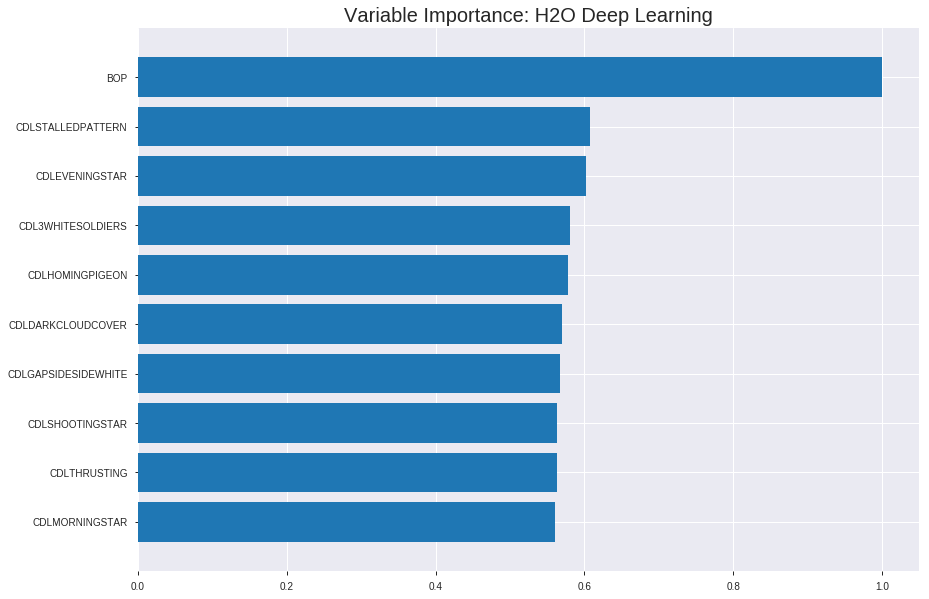

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_165808_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18934968555238535
RMSE: 0.43514329312582234
LogLoss: 0.564765672670386
Mean Per-Class Error: 0.2708501660831313
AUC: 0.7906030862535036
pr_auc: 0.7432503264982767
Gini: 0.5812061725070072
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3290776853947254: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      557  289  0.3416   (289.0/846.0)
1      144  567  0.2025   (144.0/711.0)
Total  701  856  0.2781   (433.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.329078     0.723676  247
max f2                       0.116745     0.833333  341
max f0point5                 0.379758     0.695641  227
max accuracy                 0.379758     0.727039  227
max precision                0.998704     1         0
max recall                   0.000605438  1         399
max specificity              0.998704     1         0
max absolute_mcc             0.366204     0.456703  232
max min_per_class_accuracy   0.400124     0.721519  217
max mean_per_class_accuracy  0.366204     0.72915   232

Gains/Lift Table: Avg response rate: 45.66 %, avg score: 41.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.974854           2.18987   2.18987            1                0.987018   1                           0.987018            0.0225035       0.0225035                  118.987   118.987
    2        0.0205523                   0.949339           1.91614   2.05301            0.875            0.960298   0.9375                      0.973658            0.0196906       0.0421941                  91.6139   105.301
    3        0.0301863                   0.932339           2.04388   2.05009            0.933333         0.938335   0.93617                     0.962385            0.0196906       0.0618847                  104.388   105.009
    4        0.0404624                   0.911114           1.64241   1.94655            0.75             0.920283   0.888889                    0.951692            0.0168776       0.0787623                  64.2405   94.6554
    5        0.0500963                   0.897199           1.89789   1.9372             0.866667         0.902948   0.884615                    0.942318            0.0182841       0.0970464                  89.789    93.7196
    6        0.100193                    0.810955           1.82489   1.88105            0.833333         0.857326   0.858974                    0.899822            0.0914205       0.188467                   82.4895   88.1045
    7        0.150289                    0.756606           1.68452   1.81554            0.769231         0.781702   0.82906                     0.860449            0.0843882       0.272855                   68.4518   81.5536
    8        0.200385                    0.694662           1.54414   1.74769            0.705128         0.727275   0.798077                    0.827155            0.0773558       0.350211                   54.4142   74.7687
    9        0.299936                    0.583355           1.45521   1.65061            0.664516         0.638631   0.753747                    0.764583            0.144866        0.495077                   45.5206   65.0611
    10       0.400128                    0.474397           1.15109   1.52553            0.525641         0.522227   0.696629                    0.703897            0.115331        0.610408                   15.1087   52.553
    11       0.500321                    0.379441           1.37569   1.49552            0.628205         0.428794   0.682927                    0.648805            0.137834        0.748242                   37.569    49.5523
    12       0.599872                    0.292103           0.861821  1.39036            0.393548         0.331254   0.634904                    0.596107            0.0857947       0.834037                   -13.8179  39.0359
    13       0.700064                    0.205808           0.65977   1.2858             0.301282         0.247377   0.587156                    0.546197            0.0661041       0.900141                   -34.023   28.5797
    14       0.799615                    0.130674           0.551     1.19432            0.251613         0.169432   0.545382                    0.49929             0.0548523       0.954993                   -44.9     19.4317
    15       0.899807                    0.0534019          0.266715  1.09103            0.121795         0.0894024  0.498216                    0.45365             0.0267229       0.981716                   -73.3285  9.1029
    16       1                           1.69656e-05        0.182489  1                  0.0833333        0.0206946  0.456647                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.22024417882457648
RMSE: 0.46930179929825167
LogLoss: 0.6404876251498166
Mean Per-Class Error: 0.3153225145479879
AUC: 0.7267949348414064
pr_auc: 0.6497961136671849
Gini: 0.4535898696828129
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2881916140058352: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  129  0.5181   (129.0/249.0)
1      23   173  0.1173   (23.0/196.0)
Total  143  302  0.3416   (152.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.288192     0.694779  270
max f2                       0.078484     0.831202  352
max f0point5                 0.45708      0.627224  207
max accuracy                 0.45708      0.67191   207
max precision                0.994699     1         0
max recall                   0.00225376   1         397
max specificity              0.994699     1         0
max absolute_mcc             0.288192     0.38757   270
max min_per_class_accuracy   0.506488     0.662651  189
max mean_per_class_accuracy  0.304716     0.684677  263

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 46.96 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.976177           2.27041    2.27041            1                0.987365   1                           0.987365            0.0255102       0.0255102                  127.041   127.041
    2        0.0202247                   0.96947            1.70281    2.01814            0.75             0.97341    0.888889                    0.981162            0.0153061       0.0408163                  70.2806   101.814
    3        0.0314607                   0.959662           1.81633    1.94606            0.8              0.965992   0.857143                    0.975745            0.0204082       0.0612245                  81.6327   94.6064
    4        0.0404494                   0.945742           2.27041    2.01814            1                0.950802   0.888889                    0.970202            0.0204082       0.0816327                  127.041   101.814
    5        0.0516854                   0.931865           2.27041    2.07298            1                0.939734   0.913043                    0.963578            0.0255102       0.107143                   127.041   107.298
    6        0.101124                    0.874873           1.1352     1.61451            0.5              0.901348   0.711111                    0.933155            0.0561224       0.163265                   13.5204   61.4512
    7        0.150562                    0.828274           1.3416     1.5249             0.590909         0.852112   0.671642                    0.906544            0.0663265       0.229592                   34.1605   52.4901
    8        0.2                         0.779424           1.44481    1.5051             0.636364         0.799992   0.662921                    0.880205            0.0714286       0.30102                    44.4805   50.5102
    9        0.301124                    0.677608           1.31179    1.44018            0.577778         0.728647   0.634328                    0.829308            0.132653        0.433673                   31.1791   44.0184
    10       0.4                         0.569183           1.2384     1.39031            0.545455         0.615522   0.61236                     0.776462            0.122449        0.556122                   23.8404   39.0306
    11       0.501124                    0.469053           1.31179    1.37446            0.577778         0.522939   0.605381                    0.725303            0.132653        0.688776                   31.1791   37.4462
    12       0.6                         0.365216           0.877203   1.29252            0.386364         0.423821   0.569288                    0.67562             0.0867347       0.77551                    -12.2797  29.2517
    13       0.698876                    0.262785           1.0836     1.26296            0.477273         0.313536   0.55627                     0.624393            0.107143        0.882653                   8.36039   26.296
    14       0.8                         0.148117           0.655896   1.18622            0.288889         0.208615   0.522472                    0.571837            0.0663265       0.94898                    -34.4104  18.6224
    15       0.898876                    0.050115           0.464402   1.10682            0.204545         0.102588   0.4875                      0.520219            0.0459184       0.994898                   -53.5598  10.6824
    16       1                           9.50143e-06        0.0504535  1                  0.0222222        0.0194585  0.440449  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:01:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 17:01:34  3 min 24.142 sec  498 obs/sec       0.732177  1             1140       0.584195         3.10406             -0.375474      0.662871        0.3468             2.05301          0.402697                         0.669741           6.0574                -0.820031        0.595238          0.303162             1.51361            0.492135
    2019-08-25 17:01:47  3 min 37.575 sec  537 obs/sec       5.04689   7             7858       0.594416         4.27913             -0.424026      0.648705        0.314086           1.62676          0.411047                         0.694809           10.5195               -0.958826        0.539341          0.17404              1.24872            0.494382
    2019-08-25 17:01:59  3 min 49.024 sec  544 obs/sec       8.72447   12            13584      0.594903         2.97811             -0.426362      0.697953        0.328492           1.91614          0.376365                         0.653              3.9745                -0.730177        0.690005          0.487641             2.27041            0.386517
    2019-08-25 17:02:10  4 min  0.062 sec  550 obs/sec       12.3263   17            19192      0.57737          2.74945             -0.343524      0.661297        0.37102            2.05301          0.375723                         0.680844           8.25629               -0.880877        0.562659          0.197653             1.45955            0.496629
    2019-08-25 17:02:23  4 min 12.865 sec  555 obs/sec       16.6224   23            25881      0.479835         0.848407            0.0720592      0.782478        0.734506           2.05301          0.293513                         0.537673           1.11886               -0.17301         0.707073          0.629974             2.27041            0.350562
    2019-08-25 17:02:35  4 min 25.621 sec  560 obs/sec       20.9692   29            32649      0.480927         0.759865            0.0678285      0.756685        0.704563           2.05301          0.337829                         0.535272           1.16542               -0.162553        0.68644           0.641777             2.27041            0.465169
    2019-08-25 17:02:48  4 min 38.521 sec  564 obs/sec       25.3815   35            39519      0.480701         0.710744            0.0687056      0.729368        0.696137           2.05301          0.425177                         0.513669           0.785533              -0.0706105       0.686337          0.613048             2.27041            0.402247
    2019-08-25 17:03:01  4 min 51.386 sec  567 obs/sec       29.7823   41            46371      0.435143         0.564766            0.236864       0.790603        0.74325            2.18987          0.278099                         0.469302           0.640488              0.106347         0.726795          0.649796             2.27041            0.341573
    2019-08-25 17:03:14

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.004798889310753908
CDLSTALLEDPATTERN         0.6075006723403931     0.6075006723403931   0.0029153284827701247
CDLEVENINGSTAR            0.6014192700386047     0.6014192700386047   0.0028861445062696783
CDL3WHITESOLDIERS         0.5810250043869019     0.5810250043869019   0.0027882746828330456
CDLHOMINGPIGEON           0.5782849192619324     0.5782849192619324   0.002775125317616274
---                       ---                    ---                  ---
BBANDS_middleband_12_4_3  0.1606239527463913     0.1606239527463913   0.000770816569885698
BBANDS_lowerband_20_3_2   0.16053418815135956    0.16053418815135956  0.000770385799530116
BBANDS_lowerband_20_5_3   0.15943153202533722    0.15943153202533722  0.0007650942748335101
BBANDS_lowerband_12_7_3   0.1584642231464386     0.1584642231464386   0.0007604522665943662
BBANDS_middleband_14_6_4  0.15678441524505615    0.15678441524505615  0.0007523910544123021


See the whole table with table.as_data_frame()


('accuracy', 0.7219730941704036)

('F1', 0.7208480565371025)

('auc', 0.7618778280542986)

('logloss', 0.6311219518794547)

('mean_per_class_error', 0.2774725274725275)

('rmse', 0.4555553025137053)

('mse', 0.20753063364835353)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


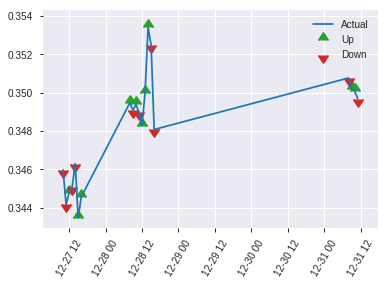


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20753063364835353
RMSE: 0.4555553025137053
LogLoss: 0.6311219518794547
Mean Per-Class Error: 0.2774725274725275
AUC: 0.7618778280542986
pr_auc: 0.6674972972392784
Gini: 0.5237556561085972
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1322524516492856: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      42   77   0.6471   (77.0/119.0)
1      2    102  0.0192   (2.0/104.0)
Total  44   179  0.3543   (79.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.132252     0.720848  178
max f2                       0.132252     0.857143  178
max f0point5                 0.509695     0.698529  109
max accuracy                 0.509695     0.721973  109
max precision                0.866053     0.794872  38
max recall                   0.0237633    1         204
max specificity              0.99183      0.991597  0
max absolute_mcc             0.509695     0.444087  109
max min_per_class_accuracy   0.515222     0.714286  108
max mean_per_class_accuracy  0.509695     0.722527  109

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 47.76 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.985983           0.714744   0.714744           0.333333         0.99026    0.333333                    0.99026             0.00961538      0.00961538                 -28.5256  -28.5256
    2        0.0224215                   0.977791           1.07212    0.857692           0.5              0.978325   0.4                         0.985486            0.00961538      0.0192308                  7.21154   -14.2308
    3        0.0313901                   0.970115           2.14423    1.22527            1                0.974592   0.571429                    0.982374            0.0192308       0.0384615                  114.423   22.5275
    4        0.0403587                   0.96148            1.07212    1.19124            0.5              0.968415   0.555556                    0.979272            0.00961538      0.0480769                  7.21154   19.1239
    5        0.0538117                   0.947927           2.14423    1.42949            1                0.954808   0.666667                    0.973156            0.0288462       0.0769231                  114.423   42.9487
    6        0.103139                    0.907247           1.55944    1.49164            0.727273         0.922185   0.695652                    0.948778            0.0769231       0.153846                   55.9441   49.1639
    7        0.152466                    0.879414           1.9493     1.63971            0.909091         0.895027   0.764706                    0.931388            0.0961538       0.25                       94.9301   63.9706
    8        0.201794                    0.83349            1.55944    1.62009            0.727273         0.857691   0.755556                    0.913373            0.0769231       0.326923                   55.9441   62.0085
    9        0.300448                    0.704293           1.46198    1.56817            0.681818         0.770565   0.731343                    0.866481            0.144231        0.471154                   46.1976   56.8169
    10       0.399103                    0.588757           1.16958    1.46964            0.545455         0.644237   0.685393                    0.811544            0.115385        0.586538                   16.958    46.9641
    11       0.502242                    0.499315           1.39841    1.45501            0.652174         0.539843   0.678571                    0.755748            0.144231        0.730769                   39.8411   45.5014
    12       0.600897                    0.353898           0.877185   1.36015            0.409091         0.431956   0.634328                    0.702588            0.0865385       0.817308                   -12.2815  36.0146
    13       0.699552                    0.225829           0.58479    1.2508             0.272727         0.285514   0.583333                    0.64377             0.0576923       0.875                      -41.521   25.0801
    14       0.798206                    0.13508            0.97465    1.21667            0.454545         0.177816   0.567416                    0.58618             0.0961538       0.971154                   -2.53497  21.667
    15       0.896861                    0.0378685          0.19493    1.10428            0.0909091        0.0817576  0.515                       0.530694            0.0192308       0.990385                   -80.507   10.4279
    16       1                           0.000748707        0.0932274  1                  0.0434783        0.0161575  0.466368

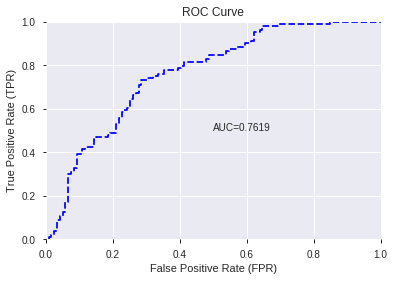

This function is available for GLM models only


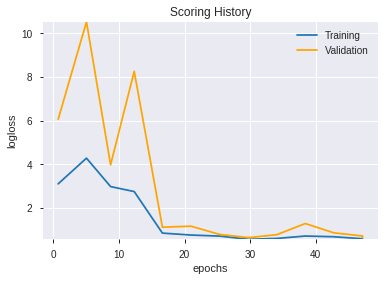

--2019-08-25 17:31:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_165808_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_165808_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a49b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_173202_model_9  0.767776  0.578329              0.288219  0.446243  0.199133
1  DeepLearning_grid_1_AutoML_20190825_173202_model_5  0.767534  0.584255              0.282199  0.450438  0.202895
2  DeepLearning_grid_1_AutoML_20190825_173202_model_8  0.764948  0.573798              0.297794  0.444488  0.197569
3  DeepLearning_grid_1_AutoML_20190825_173202_model_6  0.763009  0.582233              0.282805  0.446532  0.199391
4               DeepLearning_1_AutoML_20190825_173202  0.744505  0.604479              0.275048  0.455555  0.207530
5  DeepLearning_grid_1_AutoML_20190825_173202_model_7  0.743213  0.665979              0.321792  0.486974  0.237144
6  DeepLearning_grid_1_AutoML_20190825_173202_model_4  0.708872  0.746753              0.320661  0.492615  0.242670
7  DeepLearning_grid_1_AutoML_20190825_173202_model_2  0.707660  0.784548              0.321833  0.494862  0.244888
8  DeepLearning_grid_1_AutoML_20190825_173202_model_3  0.699499  0.820428              0.372212  0.490328  0.240421
9  DeepLearning_grid_1_AutoML_20190825_173202_model_1  0.696267  0.977334              0.374030  0.516726  0.267006

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.043850
1    CDLCLOSINGMARUBOZU             0.827108           0.827108    0.036269
2           CDLLONGLINE             0.812745           0.812745    0.035639
3                   SUB             0.643158           0.643158    0.028202
4                   DIV             0.639066           0.639066    0.028023
5          HT_TRENDMODE             0.571994           0.571994    0.025082
6                SAREXT             0.570015           0.570015    0.024995
7           CDLBELTHOLD             0.521200           0.521200    0.022855
8                TRANGE             0.494508           0.494508    0.021684
9         CDLHANGINGMAN             0.488780           0.488780    0.021433
10                 hour             0.476551           0.476551    0.020897
11       STOCHRSI_fastk             0.473253           0.473253    0.020752
12      CDLHOMINGPIGEON             0.466996           0.466996    0.020478
13    CDLSTALLEDPATTERN             0.464392           0.464392    0.020364
14            CORREL_20             0.450899           0.450899    0.019772
15            CDLHAMMER             0.446333           0.446333    0.019572
16   CDLEVENINGDOJISTAR             0.444664           0.444664    0.019498
17    CDLINVERTEDHAMMER             0.441378           0.441378    0.019354
18    CDL3WHITESOLDIERS             0.440337           0.440337    0.019309
19       CDLEVENINGSTAR             0.438762           0.438762    0.019240
20  CDLRISEFALL3METHODS             0.436602           0.436602    0.019145
21   CDLMORNINGDOJISTAR             0.435075           0.435075    0.019078
22       CDLMORNINGSTAR             0.433446           0.433446    0.019007
23         CDLTHRUSTING             0.431551           0.431551    0.018923
24      CDLSHOOTINGSTAR             0.427376           0.427376    0.018740
25  CDLGAPSIDESIDEWHITE             0.426759           0.426759    0.018713
26          CDLPIERCING             0.425635           0.425635    0.018664
27        CDLHIKKAKEMOD             0.424785           0.424785    0.018627
28    CDLDARKCLOUDCOVER             0.424747           0.424747    0.018625
29     CDLSTICKSANDWICH             0.424372           0.424372    0.018609
30   CDLIDENTICAL3CROWS             0.424363           0.424363    0.018608
31            CDLONNECK             0.419135           0.419135    0.018379
32               ULTOSC             0.417268           0.417268    0.018297
33      CDLADVANCEBLOCK             0.410474           0.410474    0.017999
34            CORREL_14             0.396583           0.396583    0.017390
35        days_in_month             0.392283           0.392283    0.017202
36     CDLDRAGONFLYDOJI             0.386582           0.386582    0.016952
37            CDLTAKURI             0.381461           0.381461    0.016727
38       is_month_start             0.379736           0.379736    0.016651
39         is_month_end             0.372008           0.372008    0.016313
40       CDL3LINESTRIKE             0.363703           0.363703    0.015948
41                  OBV             0.363367           0.363367    0.015934
42                  day             0.356995           0.356995    0.015654
43    CDLGRAVESTONEDOJI             0.353453           0.353453    0.015499
44               Volume             0.347728           0.347728    0.015248
45       CDLHARAMICROSS             0.340658           0.340658    0.014938
46          HT_DCPERIOD             0.333624           0.333624    0.014629
47       CDLMATCHINGLOW             0.328757           0.328757    0.014416
48                ADOSC             0.319341           0.319341    0.014003
49            CORREL_24             0.315069           0.315069    0.013816

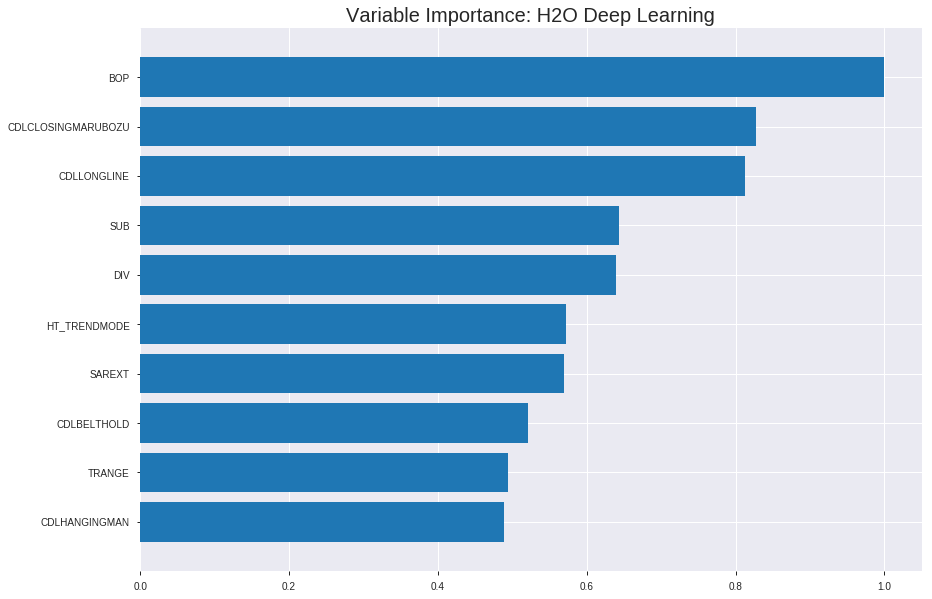

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_173202_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18362799922367337
RMSE: 0.4285183767630898
LogLoss: 0.5471205755350242
Mean Per-Class Error: 0.2594562647754137
AUC: 0.8050759260921754
pr_auc: 0.7536671152845209
Gini: 0.6101518521843508
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44301488739579536: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      558  288  0.3404   (288.0/846.0)
1      127  584  0.1786   (127.0/711.0)
Total  685  872  0.2665   (415.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.443015     0.73784   210
max f2                       0.212112     0.834143  318
max f0point5                 0.51951      0.720893  160
max accuracy                 0.497941     0.737958  176
max precision                0.943471     1         0
max recall                   0.0460437    1         397
max specificity              0.943471     1         0
max absolute_mcc             0.443015     0.482635  210
max min_per_class_accuracy   0.485268     0.735225  184
max mean_per_class_accuracy  0.463437     0.740544  196

Gains/Lift Table: Avg response rate: 45.66 %, avg score: 45.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.856623           1.91614   1.91614            0.875            0.873719  0.875                       0.873719            0.0196906       0.0196906                  91.6139   91.6139
    2        0.0205523                   0.839118           2.05301   1.98457            0.9375           0.846821  0.90625                     0.86027             0.021097        0.0407876                  105.301   98.4573
    3        0.0301863                   0.816103           2.18987   2.05009            1                0.828763  0.93617                     0.850215            0.021097        0.0618847                  118.987   105.009
    4        0.0404624                   0.803226           1.77927   1.98131            0.8125           0.809088  0.904762                    0.83977             0.0182841       0.0801688                  77.9272   98.1314
    5        0.0500963                   0.784546           1.60591   1.90912            0.733333         0.792358  0.871795                    0.830652            0.0154712       0.0956399                  60.5907   90.912
    6        0.100193                    0.725654           1.79682   1.85297            0.820513         0.755774  0.846154                    0.793213            0.0900141       0.185654                   79.6819   85.297
    7        0.150289                    0.679389           1.71259   1.80618            0.782051         0.698211  0.824786                    0.761546            0.0857947       0.271449                   71.2593   80.6178
    8        0.200385                    0.645906           1.60029   1.75471            0.730769         0.661366  0.801282                    0.736501            0.0801688       0.351617                   60.0292   75.4706
    9        0.299936                    0.576943           1.59649   1.70219            0.729032         0.612623  0.777302                    0.695385            0.158931        0.510549                   59.6488   70.2193
    10       0.400128                    0.515086           1.34761   1.61341            0.615385         0.545774  0.736758                    0.657922            0.135021        0.64557                    34.7614   61.3406
    11       0.500321                    0.470255           1.12301   1.5152             0.512821         0.495519  0.691913                    0.6254              0.112518        0.758087                   12.3012   51.5201
    12       0.599872                    0.419379           0.890078  1.41146            0.406452         0.445726  0.64454                     0.595582            0.0886076       0.846695                   -10.9922  41.146
    13       0.700064                    0.345118           0.575544  1.29182            0.262821         0.391068  0.589908                    0.566313            0.0576653       0.90436                    -42.4456  29.1824
    14       0.799615                    0.227962           0.551     1.19959            0.251613         0.283667  0.547791                    0.531124            0.0548523       0.959212                   -44.9     19.9593
    15       0.899807                    0.144871           0.23864   1.09259            0.108974         0.184973  0.498929                    0.49258             0.02391         0.983122                   -76.136   9.25921
    16       1                           0.0225287          0.168452  1                  0.0769231        0.105127  0.456647                    0.45376             



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1970312859730937
RMSE: 0.4438820631351234
LogLoss: 0.5742487690127343
Mean Per-Class Error: 0.3088681255634784
AUC: 0.7643738218178838
pr_auc: 0.6892381318868358
Gini: 0.5287476436357677
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28129369300012286: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      119  130  0.5221   (130.0/249.0)
1      21   175  0.1071   (21.0/196.0)
Total  140  305  0.3393   (151.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281294     0.698603  275
max f2                       0.173567     0.831158  328
max f0point5                 0.502557     0.664474  132
max accuracy                 0.502557     0.696629  132
max precision                0.899793     1         0
max recall                   0.0520596    1         396
max specificity              0.899793     1         0
max absolute_mcc             0.281294     0.396385  275
max min_per_class_accuracy   0.424855     0.683673  192
max mean_per_class_accuracy  0.365185     0.691132  233

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 40.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.84323            1.81633   1.81633            0.8              0.857094   0.8                         0.857094            0.0204082       0.0204082                  81.6327   81.6327
    2        0.0202247                   0.827438           1.70281   1.76587            0.75             0.837111   0.777778                    0.848213            0.0153061       0.0357143                  70.2806   76.5873
    3        0.0314607                   0.811627           2.27041   1.94606            1                0.819925   0.857143                    0.83811             0.0255102       0.0612245                  127.041   94.6064
    4        0.0404494                   0.797705           1.70281   1.89201            0.75             0.804418   0.833333                    0.830623            0.0153061       0.0765306                  70.2806   89.2007
    5        0.0516854                   0.785873           1.81633   1.87555            0.8              0.793236   0.826087                    0.822495            0.0204082       0.0969388                  81.6327   87.5555
    6        0.101124                    0.70112            1.75441   1.81633            0.772727         0.748962   0.8                         0.786546            0.0867347       0.183673                   75.4406   81.6327
    7        0.150562                    0.630294           1.65121   1.76211            0.727273         0.660385   0.776119                    0.74512             0.0816327       0.265306                   65.1206   76.2108
    8        0.2                         0.592512           1.85761   1.78571            0.818182         0.611214   0.786517                    0.712019            0.0918367       0.357143                   85.7607   78.5714
    9        0.301124                    0.508005           1.26134   1.60962            0.555556         0.546187   0.708955                    0.656329            0.127551        0.484694                   26.1338   60.9618
    10       0.4                         0.44702            1.1352    1.49235            0.5              0.475184   0.657303                    0.611552            0.112245        0.596939                   13.5204   49.2347
    11       0.501124                    0.414117           1.05952   1.40501            0.466667         0.431849   0.618834                    0.575289            0.107143        0.704082                   5.95238   40.5006
    12       0.6                         0.353314           1.032     1.34354            0.454545         0.387179   0.59176                     0.544289            0.102041        0.806122                   3.20037   34.3537
    13       0.698876                    0.270295           0.928803  1.28486            0.409091         0.306775   0.565916                    0.510686            0.0918367       0.897959                   -7.11967  28.4861
    14       0.8                         0.195715           0.605442  1.19898            0.266667         0.234972   0.52809                     0.475835            0.0612245       0.959184                   -39.4558  19.898
    15       0.898876                    0.120816           0.258001  1.09547            0.113636         0.15546    0.4825                      0.440593            0.0255102       0.984694                   -74.1999  9.54719
    16       1                           0.0149463          0.151361  1                  0.0666667        0.0847521  0.440449                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:39:08  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 17:39:11  2 min 26.715 sec  509 obs/sec       0.786769  1             1225       0.455788         0.640995            0.162736       0.762902        0.693606           1.64241          0.315992                         0.46531            0.659146              0.121484         0.744539          0.668244             1.81633            0.323596
    2019-08-25 17:39:23  2 min 38.986 sec  804 obs/sec       6.99872   9             10897      0.445879         0.580116            0.198745       0.776905        0.716843           1.91614          0.298009                         0.456807           0.601172              0.153298         0.742982          0.662917             1.81633            0.319101
    2019-08-25 17:39:35  2 min 50.756 sec  946 obs/sec       14.7091   19            22902      0.437775         0.566005            0.227605       0.784454        0.728747           1.91614          0.319204                         0.447563           0.583991              0.187221         0.750553          0.672096             1.81633            0.334831
    2019-08-25 17:39:47  3 min  2.739 sec  997 obs/sec       22.4817   29            35004      0.436133         0.562239            0.23339        0.788924        0.732801           1.91614          0.282595                         0.451132           0.590894              0.174207         0.752244          0.677753             2.27041            0.341573
    2019-08-25 17:39:59  3 min 14.722 sec  1079 obs/sec      31.8311   41            49561      0.430953         0.551506            0.251489       0.794295        0.741099           1.91614          0.297367                         0.449106           0.586751              0.181606         0.758268          0.679104             1.36224            0.330337
    2019-08-25 17:40:10  3 min 26.451 sec  1133 obs/sec      41.1657   53            64095      0.428337         0.548809            0.26055        0.798694        0.750064           2.05301          0.287091                         0.452843           0.598228              0.16793          0.759538          0.695402             2.27041            0.316854
    2019-08-25 17:40:22  3 min 37.862 sec  1177 obs/sec      50.5157   65            78653      0.428518         0.547121            0.259924       0.805076        0.753667           1.91614          0.266538                         0.443882           0.574249              0.200534         0.764374          0.689238             1.81633            0.339326

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04384988783615185
CDLCLOSINGMARUBOZU  0.8271082639694214     0.8271082639694214   0.036268604603413405
CDLLONGLINE         0.8127446174621582     0.8127446174621582   0.03563876031515178
SUB                 0.6431580185890198     0.6431580185890198   0.028202406976050184
DIV                 0.6390662789344788     0.6390662789344788   0.028022984651143827
---                 ---                    ---                  ---
CDLHARAMICROSS      0.3406580686569214     0.3406580686569214   0.014937818101086119
HT_DCPERIOD         0.33362358808517456    0.33362358808517456  0.014629356917029431
CDLMATCHINGLOW      0.3287571370601654     0.3287571370601654   0.014415963585422653
ADOSC               0.3193405568599701     0.3193405568599701   0.01400304759984396
CORREL_24           0.31506916880607605    0.31506916880607605  0.013815747712776029


See the whole table with table.as_data_frame()


('accuracy', 0.7219730941704036)

('F1', 0.722689075630252)

('auc', 0.767776341305753)

('logloss', 0.5783287921197968)

('mean_per_class_error', 0.2792905623787977)

('rmse', 0.4462427395580453)

('mse', 0.1991325826082694)

deeplearning prediction progress: |███████████████████████████████████████| 100%


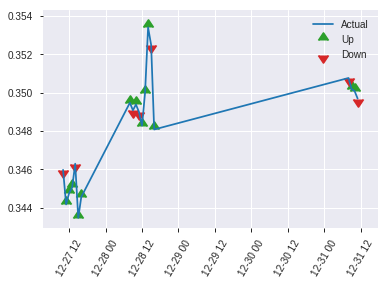


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1991325826082694
RMSE: 0.4462427395580453
LogLoss: 0.5783287921197968
Mean Per-Class Error: 0.2792905623787977
AUC: 0.767776341305753
pr_auc: 0.6935960571330095
Gini: 0.535552682611506
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.388599031896731: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      71   48   0.4034   (48.0/119.0)
1      18   86   0.1731   (18.0/104.0)
Total  89   134  0.296    (66.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388599     0.722689  133
max f2                       0.160945     0.845649  192
max f0point5                 0.442717     0.701923  103
max accuracy                 0.442717     0.721973  103
max precision                0.836419     1         0
max recall                   0.113095     1         209
max specificity              0.836419     1         0
max absolute_mcc             0.442717     0.441419  103
max min_per_class_accuracy   0.442717     0.701923  103
max mean_per_class_accuracy  0.442717     0.720709  103

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 42.40 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.818996           1.42949    1.42949            0.666667         0.830384   0.666667                    0.830384            0.0192308       0.0192308                  42.9487   42.9487
    2        0.0224215                   0.810089           1.07212    1.28654            0.5              0.813231   0.6                         0.823523            0.00961538      0.0288462                  7.21154   28.6538
    3        0.0313901                   0.804499           2.14423    1.53159            1                0.808314   0.714286                    0.819178            0.0192308       0.0480769                  114.423   53.1593
    4        0.0403587                   0.785549           2.14423    1.66774            1                0.79694    0.777778                    0.814236            0.0192308       0.0673077                  114.423   66.7735
    5        0.0538117                   0.780807           1.42949    1.60817            0.666667         0.783549   0.75                        0.806564            0.0192308       0.0865385                  42.9487   60.8173
    6        0.103139                    0.715173           1.9493     1.77132            0.909091         0.753873   0.826087                    0.781364            0.0961538       0.182692                   94.9301   77.1321
    7        0.152466                    0.638431           1.55944    1.70277            0.727273         0.67501    0.794118                    0.746955            0.0769231       0.259615                   55.9441   70.2771
    8        0.201794                    0.586438           1.36451    1.62009            0.636364         0.608062   0.755556                    0.713004            0.0673077       0.326923                   36.451    62.0085
    9        0.300448                    0.514537           1.26705    1.50416            0.590909         0.543426   0.701493                    0.657321            0.125           0.451923                   26.7045   50.4162
    10       0.399103                    0.468382           1.36451    1.46964            0.636364         0.4957     0.685393                    0.61737             0.134615        0.586538                   36.451    46.9641
    11       0.502242                    0.427115           1.30518    1.43587            0.608696         0.446125   0.669643                    0.582204            0.134615        0.721154                   30.5184   43.5869
    12       0.600897                    0.38835            1.07212    1.37615            0.5              0.412225   0.641791                    0.554297            0.105769        0.826923                   7.21154   37.6148
    13       0.699552                    0.323967           0.682255   1.27829            0.318182         0.362113   0.596154                    0.527194            0.0673077       0.894231                   -31.7745  27.8291
    14       0.798206                    0.227556           0.682255   1.20462            0.318182         0.272621   0.561798                    0.49573             0.0673077       0.961538                   -31.7745  20.4624
    15       0.896861                    0.140527           0.292395   1.10428            0.136364         0.183958   0.515                       0.461435            0.0288462       0.990385                   -70.7605  10.4279
    16       1                           0.0401936          0.0932274  1                  0.0434783        0.0982724  0.466368 

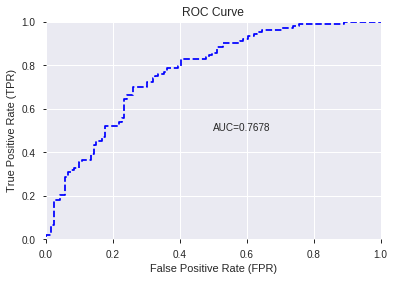

This function is available for GLM models only


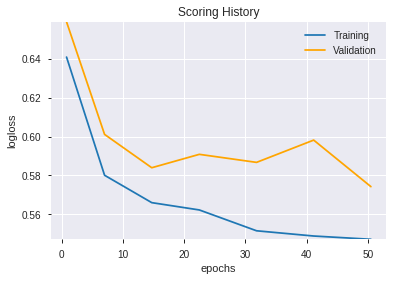

--2019-08-25 17:40:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.94.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.94.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_173202_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_173202_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a49b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'SUB',
 'DIV',
 'HT_TRENDMODE',
 'SAREXT',
 'CDLBELTHOLD',
 'TRANGE',
 'CDLHANGINGMAN',
 'hour',
 'STOCHRSI_fastk',
 'CDLHOMINGPIGEON',
 'CDLSTALLEDPATTERN',
 'CORREL_20',
 'CDLHAMMER',
 'CDLEVENINGDOJISTAR',
 'CDLINVERTEDHAMMER',
 'CDL3WHITESOLDIERS',
 'CDLEVENINGSTAR',
 'CDLRISEFALL3METHODS',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDLTHRUSTING',
 'CDLSHOOTINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLPIERCING',
 'CDLHIKKAKEMOD',
 'CDLDARKCLOUDCOVER',
 'CDLSTICKSANDWICH',
 'CDLIDENTICAL3CROWS',
 'CDLONNECK',
 'ULTOSC',
 'CDLADVANCEBLOCK',
 'CORREL_14',
 'days_in_month',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'is_month_start',
 'is_month_end',
 'CDL3LINESTRIKE',
 'OBV',
 'day',
 'CDLGRAVESTONEDOJI',
 'Volume',
 'CDLHARAMICROSS',
 'HT_DCPERIOD',
 'CDLMATCHINGLOW',
 'ADOSC',
 'CORREL_24']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_174035_model_1  0.750242  0.590467                0.2984  0.450343  0.202809

variable  relative_importance  scaled_importance  percentage
0                   SUB             0.897599           1.000000    0.144411
1                   BOP             0.806425           0.898424    0.129743
2                   DIV             0.333738           0.371812    0.053694
3                  hour             0.246587           0.274718    0.039672
4                SAREXT             0.239187           0.266474    0.038482
5    CDLCLOSINGMARUBOZU             0.187620           0.209024    0.030185
6             CDLHAMMER             0.186707           0.208007    0.030039
7                TRANGE             0.181693           0.202422    0.029232
8       CDLHOMINGPIGEON             0.177131           0.197338    0.028498
9                 ADOSC             0.160255           0.178537    0.025783
10       CDL3LINESTRIKE             0.154713           0.172363    0.024891
11     CDLSTICKSANDWICH             0.147874           0.164744    0.023791
12               ULTOSC             0.147733           0.164587    0.023768
13            CDLTAKURI             0.128104           0.142719    0.020610
14     CDLDRAGONFLYDOJI             0.118788           0.132339    0.019111
15      CDLADVANCEBLOCK             0.113644           0.126608    0.018284
16                  day             0.113095           0.125997    0.018195
17   CDLEVENINGDOJISTAR             0.112312           0.125125    0.018069
18    CDL3WHITESOLDIERS             0.110304           0.122887    0.017746
19   CDLIDENTICAL3CROWS             0.104896           0.116863    0.016876
20          HT_DCPERIOD             0.093331           0.103979    0.015016
21          CDLPIERCING             0.092648           0.103218    0.014906
22        CDLHIKKAKEMOD             0.091501           0.101940    0.014721
23  CDLRISEFALL3METHODS             0.091156           0.101555    0.014666
24            CDLONNECK             0.090052           0.100325    0.014488
25         CDLTHRUSTING             0.088556           0.098659    0.014247
26        CDLHANGINGMAN             0.086885           0.096797    0.013979
27       CDLEVENINGSTAR             0.085251           0.094977    0.013716
28            CORREL_20             0.081433           0.090723    0.013101
29    CDLGRAVESTONEDOJI             0.081286           0.090559    0.013078
30          CDLLONGLINE             0.071736           0.079919    0.011541
31               Volume             0.063625           0.070883    0.010236
32  CDLGAPSIDESIDEWHITE             0.058120           0.064751    0.009351
33            CORREL_14             0.051935           0.057860    0.008356
34            CORREL_24             0.046966           0.052324    0.007556
35    CDLINVERTEDHAMMER             0.044162           0.049200    0.007105
36       is_month_start             0.041686           0.046442    0.006707
37      CDLSHOOTINGSTAR             0.040703           0.045347    0.006549
38       CDLMATCHINGLOW             0.038359           0.042736    0.006171
39    CDLDARKCLOUDCOVER             0.037549           0.041833    0.006041
40       STOCHRSI_fastk             0.034782           0.038750    0.005596
41       CDLMORNINGSTAR             0.033992           0.037870    0.005469
42       CDLHARAMICROSS             0.021364           0.023801    0.003437
43   CDLMORNINGDOJISTAR             0.019231           0.021424    0.003094
44                  OBV             0.017820           0.019853    0.002867
45         HT_TRENDMODE             0.014732           0.016413    0.002370
46          CDLBELTHOLD             0.011482           0.012792    0.001847
47        days_in_month             0.008080           0.009002    0.001300
48    CDLSTALLEDPATTERN             0.005440           0.006061    0.000875
49         is_month_end             0.003307           0.003684    0.000532

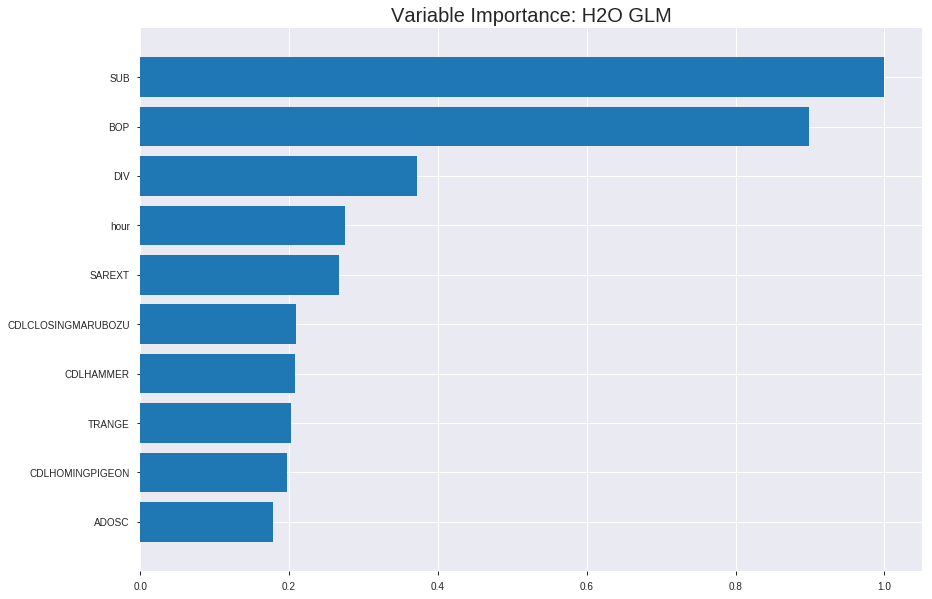

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_174035_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18781303811713282
RMSE: 0.4333740164305341
LogLoss: 0.5559020387481539
Null degrees of freedom: 1556
Residual degrees of freedom: 1506
Null deviance: 2146.7404074571314
Residual deviance: 1731.0789486617514
AIC: 1833.0789486617514
AUC: 0.7859497660871213
pr_auc: 0.7361906380688417
Gini: 0.5718995321742426
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3699606081763006: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      500  346  0.409    (346.0/846.0)
1      119  592  0.1674   (119.0/711.0)
Total  619  938  0.2987   (465.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369961     0.718011  240
max f2                       0.22825      0.828018  310
max f0point5                 0.537326     0.705434  164
max accuracy                 0.537326     0.722543  164
max precision                0.996587     1         0
max recall                   0.0478273    1         390
max specificity              0.996587     1         0
max absolute_mcc             0.537326     0.438336  164
max min_per_class_accuracy   0.462087     0.708038  196
max mean_per_class_accuracy  0.409185     0.715579  221

Gains/Lift Table: Avg response rate: 45.66 %, avg score: 45.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.92388            2.05301   2.05301            0.9375           0.969879   0.9375                      0.969879            0.021097        0.021097                   105.301   105.301
    2        0.0205523                   0.898286           2.18987   2.12144            1                0.911519   0.96875                     0.940699            0.0225035       0.0436006                  118.987   112.144
    3        0.0301863                   0.879563           1.89789   2.05009            0.866667         0.889299   0.93617                     0.924295            0.0182841       0.0618847                  89.789    105.009
    4        0.0404624                   0.854159           1.64241   1.94655            0.75             0.86525    0.888889                    0.909299            0.0168776       0.0787623                  64.2405   94.6554
    5        0.0500963                   0.839841           1.31392   1.82489            0.6              0.844126   0.833333                    0.896766            0.0126582       0.0914205                  31.3924   82.4895
    6        0.100193                    0.788523           1.74067   1.78278            0.794872         0.812981   0.814103                    0.854874            0.0872011       0.178622                   74.0669   78.2782
    7        0.150289                    0.741883           1.74067   1.76874            0.794872         0.763996   0.807692                    0.824581            0.0872011       0.265823                   74.0669   76.8744
    8        0.200385                    0.694793           1.65644   1.74067            0.75641          0.719067   0.794872                    0.798202            0.0829817       0.348805                   65.6443   74.0669
    9        0.299936                    0.611752           1.45521   1.64592            0.664516         0.650794   0.751606                    0.749277            0.144866        0.493671                   45.5206   64.5922
    10       0.400128                    0.525765           1.36165   1.57474            0.621795         0.571773   0.719101                    0.70483             0.136428        0.630098                   36.1652   57.474
    11       0.500321                    0.447386           0.982636  1.45617            0.448718         0.485388   0.664955                    0.660885            0.0984529       0.728551                   -1.73645  45.6167
    12       0.599872                    0.370737           1.01723   1.38332            0.464516         0.408488   0.631692                    0.618999            0.101266        0.829817                   1.72315   38.3325
    13       0.700064                    0.304427           0.673807  1.28178            0.307692         0.335455   0.585321                    0.578418            0.0675105       0.897328                   -32.6193  28.1779
    14       0.799615                    0.219542           0.536872  1.18904            0.245161         0.261196   0.542972                    0.538925            0.0534459       0.950774                   -46.3128  18.904
    15       0.899807                    0.128261           0.336904  1.09416            0.153846         0.174387   0.499643                    0.498334            0.0337553       0.984529                   -66.3096  9.41552
    16       1                           1.48334e-05        0.154414  1                  0.0705128        0.0822699  0.456647                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20090484266155903
RMSE: 0.44822409870684
LogLoss: 0.5825214908807007
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 611.0451593654886
Residual deviance: 518.4441268838236
AIC: 620.4441268838236
AUC: 0.7506249487746905
pr_auc: 0.6781204866575651
Gini: 0.5012498975493811
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3266042148029918: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      128  121  0.4859   (121.0/249.0)
1      28   168  0.1429   (28.0/196.0)
Total  156  289  0.3348   (149.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.326604     0.692784  257
max f2                       0.175267     0.8283    336
max f0point5                 0.41669      0.644876  212
max accuracy                 0.41669      0.689888  212
max precision                0.995466     1         0
max recall                   0.0648494    1         386
max specificity              0.995466     1         0
max absolute_mcc             0.41669      0.389218  212
max min_per_class_accuracy   0.449191     0.668367  193
max mean_per_class_accuracy  0.41669      0.695742  212

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 44.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.913895           1.81633   1.81633            0.8              0.965718   0.8                         0.965718            0.0204082       0.0204082                  81.6327   81.6327
    2        0.0202247                   0.903041           1.70281   1.76587            0.75             0.908307   0.777778                    0.940202            0.0153061       0.0357143                  70.2806   76.5873
    3        0.0314607                   0.86883            2.27041   1.94606            1                0.889168   0.857143                    0.921975            0.0255102       0.0612245                  127.041   94.6064
    4        0.0404494                   0.846708           1.70281   1.89201            0.75             0.857319   0.833333                    0.907607            0.0153061       0.0765306                  70.2806   89.2007
    5        0.0516854                   0.840409           2.27041   1.97427            1                0.844165   0.869565                    0.893815            0.0255102       0.102041                   127.041   97.4268
    6        0.101124                    0.777688           1.54801   1.76587            0.681818         0.804735   0.777778                    0.850265            0.0765306       0.178571                   54.8006   76.5873
    7        0.150562                    0.719973           1.85761   1.79599            0.818182         0.755628   0.791045                    0.81919             0.0918367       0.270408                   85.7607   79.5995
    8        0.2                         0.675859           1.1352    1.63265            0.5              0.696674   0.719101                    0.788905            0.0561224       0.326531                   13.5204   63.2653
    9        0.301124                    0.588497           1.4127    1.55879            0.622222         0.631186   0.686567                    0.73594             0.142857        0.469388                   41.2698   55.8788
    10       0.4                         0.50662            1.0836    1.44133            0.477273         0.546016   0.634831                    0.688992            0.107143        0.576531                   8.36039   44.1327
    11       0.501124                    0.437088           1.26134   1.40501            0.555556         0.470605   0.618834                    0.644923            0.127551        0.704082                   26.1338   40.5006
    12       0.6                         0.347941           0.928803  1.32653            0.409091         0.392629   0.58427                     0.603347            0.0918367       0.795918                   -7.11967  32.6531
    13       0.698876                    0.283249           0.825603  1.25566            0.363636         0.32232    0.553055                    0.563587            0.0816327       0.877551                   -17.4397  25.566
    14       0.8                         0.217458           0.554989  1.16709            0.244444         0.248937   0.514045                    0.523814            0.0561224       0.933673                   -44.5011  16.7092
    15       0.898876                    0.125414           0.567602  1.10115            0.25             0.170762   0.485                       0.484978            0.0561224       0.989796                   -43.2398  10.1148
    16       1                           0.00663298         0.100907  1                  0.0444444        0.0741806  0.440449                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-25 17:40:35  0.000 sec   2            .2E2      50            1.3646787817076373  1.3600633902756878
     2019-08-25 17:40:35  0.005 sec   4            .12E2     50            1.3568654625831136  1.352833394508514
     2019-08-25 17:40:35  0.010 sec   6            .76E1     51            1.3453683588969148  1.3422232015599118
     2019-08-25 17:40:35  0.015 sec   8            .47E1     51            1.3291892788030952  1.3273622356542893
     2019-08-25 17:40:35  0.020 sec   10           .29E1     51            1.307880676425768   1.3079317547399738
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-25 17:40:35  0.110 sec   42           .14E-2    51            1.110300776366744   1.1650853278712723
     2019-08-25 17:40:35  0.116 sec   44           .9E-3     51            1.1089997571572259  1.16581021488383
     2019-08-25 17:40:35  0.121 sec   46           .56E-3    51            1.1080510728831623  1.167300974899849
     2019-08-25 17:40:35  0.128 sec   48           .35E-3    51            1.1074647988713384  1.1693211266978476
     2019-08-25 17:40:35  0.132 sec   49           .21E-3    51            1.1071414530410661  1.1713218679124249


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7085201793721974)

('F1', 0.7228915662650602)

('auc', 0.7502424046541695)

('logloss', 0.5904674954176852)

('mean_per_class_error', 0.2858354880413704)

('rmse', 0.4503427245989841)

('mse', 0.20280856959923643)

glm prediction progress: |████████████████████████████████████████████████| 100%


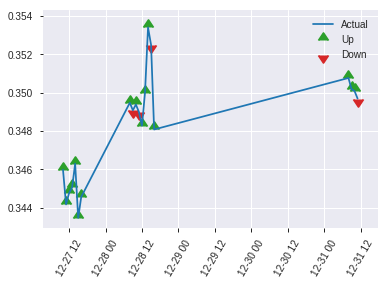


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20280856959923643
RMSE: 0.4503427245989841
LogLoss: 0.5904674954176852
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 308.21873965260795
Residual deviance: 263.3485029562876
AIC: 365.3485029562876
AUC: 0.7502424046541695
pr_auc: 0.6542026963411305
Gini: 0.5004848093083389
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37125979447597296: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   55   0.4622   (55.0/119.0)
1      14   90   0.1346   (14.0/104.0)
Total  78   145  0.3094   (69.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37126      0.722892  144
max f2                       0.269613     0.854271  180
max f0point5                 0.435829     0.678105  126
max accuracy                 0.435829     0.70852   126
max precision                0.991605     1         0
max recall                   0.113594     1         213
max specificity              0.991605     1         0
max absolute_mcc             0.435829     0.431549  126
max min_per_class_accuracy   0.519787     0.672269  108
max mean_per_class_accuracy  0.435829     0.714165  126

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 49.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.891679           1.42949    1.42949            0.666667         0.926636  0.666667                    0.926636            0.0192308       0.0192308                  42.9487   42.9487
    2        0.0224215                   0.880597           1.07212    1.28654            0.5              0.884057  0.6                         0.909604            0.00961538      0.0288462                  7.21154   28.6538
    3        0.0313901                   0.872516           1.07212    1.22527            0.5              0.876573  0.571429                    0.900167            0.00961538      0.0384615                  7.21154   22.5275
    4        0.0403587                   0.868999           1.07212    1.19124            0.5              0.871709  0.555556                    0.893843            0.00961538      0.0480769                  7.21154   19.1239
    5        0.0538117                   0.859589           1.42949    1.2508             0.666667         0.864893  0.583333                    0.886605            0.0192308       0.0673077                  42.9487   25.0801
    6        0.103139                    0.821444           1.75437    1.49164            0.818182         0.841494  0.695652                    0.86503             0.0865385       0.153846                   75.4371   49.1639
    7        0.152466                    0.775426           1.75437    1.57664            0.818182         0.791968  0.735294                    0.841392            0.0865385       0.240385                   75.4371   57.664
    8        0.201794                    0.736593           1.55944    1.57244            0.727273         0.758301  0.733333                    0.821081            0.0769231       0.317308                   55.9441   57.2436
    9        0.300448                    0.656507           1.26705    1.47216            0.590909         0.684855  0.686567                    0.77635             0.125           0.442308                   26.7045   47.2158
    10       0.399103                    0.60322            1.36451    1.44555            0.636364         0.629668  0.674157                    0.740092            0.134615        0.576923                   36.451    44.5549
    11       0.502242                    0.494277           1.0255     1.35929            0.478261         0.549717  0.633929                    0.700997            0.105769        0.682692                   2.55017   35.9289
    12       0.600897                    0.403101           1.26705    1.34414            0.590909         0.448906  0.626866                    0.659609            0.125           0.807692                   26.7045   34.4145
    13       0.699552                    0.345433           0.77972    1.26455            0.363636         0.370132  0.589744                    0.618785            0.0769231       0.884615                   -22.028   26.4546
    14       0.798206                    0.283098           0.682255   1.19258            0.318182         0.315392  0.55618                     0.581287            0.0673077       0.951923                   -31.7745  19.2578
    15       0.896861                    0.165288           0.38986    1.10428            0.181818         0.220391  0.515                       0.541588            0.0384615       0.990385                   -61.014   10.4279
    16       1                           0.0442794          0.0932274  1                  0.0434783        0.10945   0.466368                    

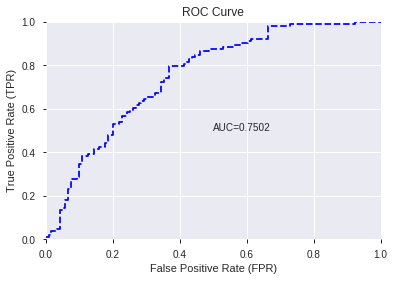

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


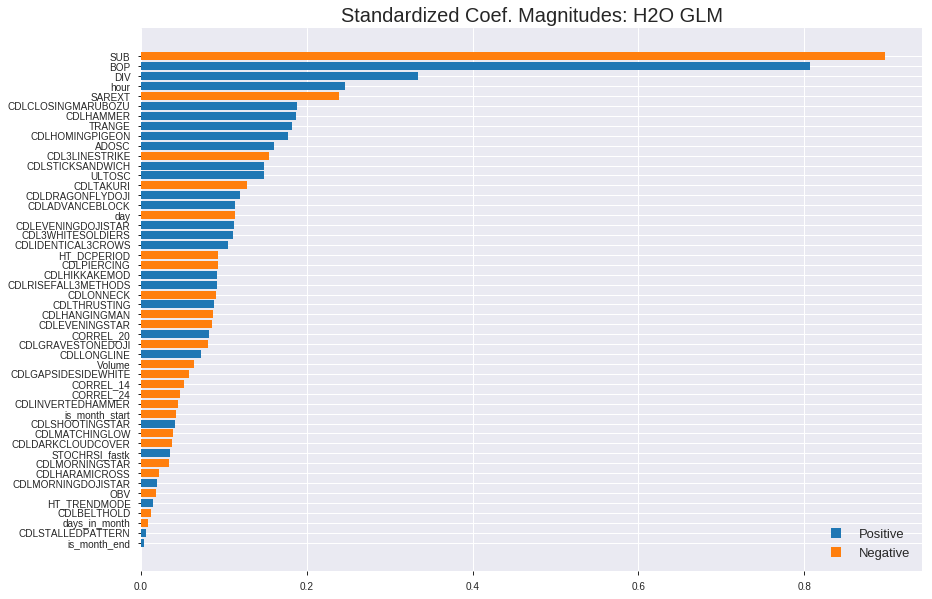

'log_likelihood'
--2019-08-25 17:40:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.18.64
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.18.64|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_174035_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_174035_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a49b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['SUB',
 'BOP',
 'DIV',
 'hour',
 'SAREXT',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'TRANGE',
 'CDLHOMINGPIGEON',
 'ADOSC',
 'CDL3LINESTRIKE',
 'CDLSTICKSANDWICH',
 'ULTOSC',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLADVANCEBLOCK',
 'day',
 'CDLEVENINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CDLIDENTICAL3CROWS',
 'HT_DCPERIOD',
 'CDLPIERCING',
 'CDLHIKKAKEMOD',
 'CDLRISEFALL3METHODS',
 'CDLONNECK',
 'CDLTHRUSTING',
 'CDLHANGINGMAN',
 'CDLEVENINGSTAR',
 'CORREL_20',
 'CDLGRAVESTONEDOJI',
 'CDLLONGLINE',
 'Volume',
 'CDLGAPSIDESIDEWHITE',
 'CORREL_14',
 'CORREL_24',
 'CDLINVERTEDHAMMER',
 'is_month_start',
 'CDLSHOOTINGSTAR',
 'CDLMATCHINGLOW',
 'CDLDARKCLOUDCOVER',
 'STOCHRSI_fastk',
 'CDLMORNINGSTAR',
 'CDLHARAMICROSS',
 'CDLMORNINGDOJISTAR',
 'OBV',
 'HT_TRENDMODE',
 'CDLBELTHOLD',
 'days_in_month',
 'CDLSTALLEDPATTERN',
 'is_month_end']

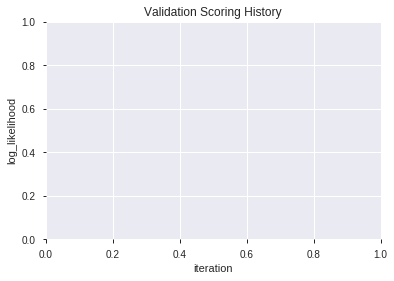

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_174046_model_2  0.785795  0.578825              0.254000  0.441909  0.195284
1  XGBoost_grid_1_AutoML_20190825_174046_model_3  0.783775  0.564709              0.292380  0.436418  0.190461
2  XGBoost_grid_1_AutoML_20190825_174046_model_1  0.783048  0.558829              0.257636  0.434758  0.189015
3               XGBoost_3_AutoML_20190825_174046  0.782321  0.560262              0.264181  0.434717  0.188978
4  XGBoost_grid_1_AutoML_20190825_174046_model_6  0.778281  0.577459              0.261797  0.440652  0.194174
5               XGBoost_1_AutoML_20190825_174046  0.770120  0.574984              0.270806  0.441981  0.195347
6  XGBoost_grid_1_AutoML_20190825_174046_model_7  0.769069  0.575571              0.261797  0.441196  0.194654
7               XGBoost_2_AutoML_20190825_174046  0.767857  0.570827              0.251616  0.440164  0.193744
8  XGBoost_grid_1_AutoML_20190825_174046_model_5  0.763251  0.584805              0.278644  0.446084  0.198991
9  XGBoost_grid_1_AutoML_20190825_174046_model_4  0.761797  0.580425              0.273796  0.444251  0.197359

variable  relative_importance  scaled_importance  percentage
0                  BOP          2442.983887           1.000000    0.313265
1                  SUB           509.788818           0.208675    0.065370
2                  DIV           482.472504           0.197493    0.061868
3               SAREXT           445.012482           0.182159    0.057064
4                 hour           400.252106           0.163837    0.051325
5               Volume           347.593994           0.142283    0.044572
6               TRANGE           332.045929           0.135918    0.042578
7                  OBV           330.735107           0.135382    0.042410
8            CORREL_20           310.349792           0.127037    0.039796
9                ADOSC           302.011505           0.123624    0.038727
10              ULTOSC           277.874695           0.113744    0.035632
11           CORREL_24           268.525604           0.109917    0.034433
12         HT_DCPERIOD           222.570282           0.091106    0.028540
13                 day           206.900497           0.084692    0.026531
14           CORREL_14           196.614212           0.080481    0.025212
15      STOCHRSI_fastk           195.350082           0.079964    0.025050
16  CDLCLOSINGMARUBOZU           142.786026           0.058447    0.018310
17           CDLHAMMER           102.591980           0.041995    0.013155
18   CDLGRAVESTONEDOJI            81.932205           0.033538    0.010506
19     CDLADVANCEBLOCK            71.349823           0.029206    0.009149
20         CDLLONGLINE            38.184761           0.015630    0.004896
21         CDLBELTHOLD            21.303329           0.008720    0.002732
22       days_in_month            13.818853           0.005657    0.001772
23        HT_TRENDMODE             9.616415           0.003936    0.001233
24        is_month_end             7.566429           0.003097    0.000970
25    CDLDRAGONFLYDOJI             7.510537           0.003074    0.000963
26      CDLMATCHINGLOW             6.734641           0.002757    0.000864
27      CDLEVENINGSTAR             6.125645           0.002507    0.000785
28       CDLHANGINGMAN             4.962595           0.002031    0.000636
29      CDLHARAMICROSS             4.611661           0.001888    0.000591
30    CDLSTICKSANDWICH             4.005905           0.001640    0.000514
31        CDLTHRUSTING             2.900805           0.001187    0.000372
32   CDLSTALLEDPATTERN             0.929313           0.000380    0.000119
33      is_month_start             0.443590           0.000182    0.000057

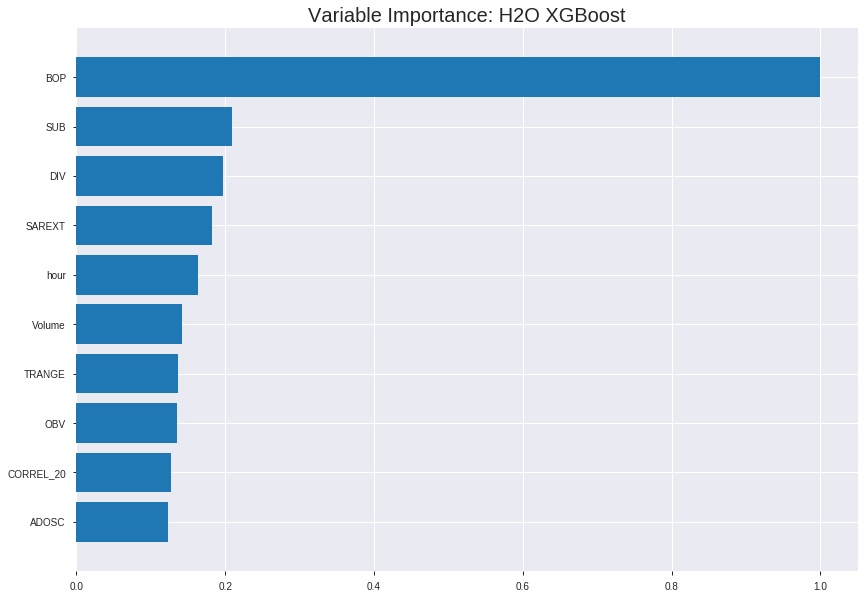

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_174046_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15037095358213026
RMSE: 0.38777693791937945
LogLoss: 0.47042619465540525
Mean Per-Class Error: 0.19790076906963527
AUC: 0.8829629297130869
pr_auc: 0.867374597470788
Gini: 0.7659258594261737
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5080571174621582: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      689  157  0.1856   (157.0/846.0)
1      150  561  0.211    (150.0/711.0)
Total  839  718  0.1972   (307.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.508057     0.785164  185
max f2                       0.257868     0.862069  297
max f0point5                 0.586262     0.803602  145
max accuracy                 0.530418     0.806037  173
max precision                0.869456     1         0
max recall                   0.123885     1         374
max specificity              0.869456     1         0
max absolute_mcc             0.530418     0.608193  173
max min_per_class_accuracy   0.500437     0.796062  189
max mean_per_class_accuracy  0.530418     0.802099  173

Gains/Lift Table: Avg response rate: 45.66 %, avg score: 45.74 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102762                   0.840969           2.18987    2.18987            1                0.855175  1                           0.855175            0.0225035       0.0225035                  118.987    118.987
    2        0.0205523                   0.824585           2.18987    2.18987            1                0.831621  1                           0.843398            0.0225035       0.045007                   118.987    118.987
    3        0.0301863                   0.814181           2.18987    2.18987            1                0.819119  1                           0.83565             0.021097        0.0661041                  118.987    118.987
    4        0.0404624                   0.801934           2.05301    2.15511            0.9375           0.808115  0.984127                    0.828657            0.021097        0.0872011                  105.301    115.511
    5        0.0500963                   0.79639            2.18987    2.1618             1                0.799079  0.987179                    0.822969            0.021097        0.108298                   118.987    116.18
    6        0.100193                    0.756875           2.10565    2.13372            0.961538         0.776756  0.974359                    0.799862            0.105485        0.213783                   110.565    113.372
    7        0.150289                    0.723196           1.99335    2.08693            0.910256         0.739775  0.952991                    0.779833            0.0998594       0.313643                   99.3346    108.693
    8        0.200385                    0.692606           1.90912    2.04248            0.871795         0.708756  0.932692                    0.762064            0.0956399       0.409283                   90.912     104.248
    9        0.299936                    0.628854           1.68126    1.92259            0.767742         0.659491  0.877944                    0.728019            0.16737         0.576653                   68.1258    92.2587
    10       0.400128                    0.548868           1.4178     1.79619            0.647436         0.589741  0.820225                    0.693394            0.142053        0.718706                   41.7803    79.6188
    11       0.500321                    0.478202           0.996673   1.63608            0.455128         0.514504  0.747112                    0.65757             0.0998594       0.818565                   -0.332684  63.608
    12       0.599872                    0.386612           0.762924   1.49118            0.348387         0.433455  0.680942                    0.620378            0.0759494       0.894515                   -23.7076   49.1177
    13       0.700064                    0.27906            0.547468   1.35611            0.25             0.330779  0.619266                    0.578931            0.0548523       0.949367                   -45.2532   35.6114
    14       0.799615                    0.203131           0.367334   1.23301            0.167742         0.238141  0.563052                    0.536503            0.0365682       0.985935                   -63.2666   23.3013
    15       0.899807                    0.138937           0.112301   1.10822            0.0512821        0.171265  0.506067                    0.495834            0.0112518       0.997187                   -88.7699   10.8223
    16       1                           0.0787901          0.0280753  1                  0.0128205        0.112118  0.456647    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1974839184057765
RMSE: 0.4443916272903626
LogLoss: 0.578504734818885
Mean Per-Class Error: 0.2953548889435291
AUC: 0.762498975493812
pr_auc: 0.691440662484205
Gini: 0.5249979509876239
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39031079411506653: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      154  95   0.3815   (95.0/249.0)
1      41   155  0.2092   (41.0/196.0)
Total  195  250  0.3056   (136.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390311     0.695067  224
max f2                       0.18543      0.820643  357
max f0point5                 0.631744     0.660828  97
max accuracy                 0.439317     0.696629  201
max precision                0.843804     1         0
max recall                   0.125457     1         390
max specificity              0.843804     1         0
max absolute_mcc             0.390311     0.409517  224
max min_per_class_accuracy   0.463428     0.688776  188
max mean_per_class_accuracy  0.390311     0.704645  224

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 45.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.814491           1.36224   1.36224            0.6              0.828414  0.6                         0.828414            0.0153061       0.0153061                  36.2245   36.2245
    2        0.0202247                   0.800473           2.27041   1.76587            1                0.80686   0.777778                    0.818835            0.0204082       0.0357143                  127.041   76.5873
    3        0.0314607                   0.790352           1.81633   1.78389            0.8              0.79685   0.785714                    0.810983            0.0204082       0.0561224                  81.6327   78.3892
    4        0.0404494                   0.782609           2.27041   1.89201            1                0.785823  0.833333                    0.805392            0.0204082       0.0765306                  127.041   89.2007
    5        0.0516854                   0.773643           1.81633   1.87555            0.8              0.779303  0.826087                    0.79972             0.0204082       0.0969388                  81.6327   87.5555
    6        0.101124                    0.722257           2.06401   1.96769            0.909091         0.747233  0.866667                    0.77406             0.102041        0.19898                    106.401   96.7687
    7        0.150562                    0.690993           1.3416    1.76211            0.590909         0.704566  0.776119                    0.751241            0.0663265       0.265306                   34.1605   76.2108
    8        0.2                         0.658927           1.75441   1.7602             0.772727         0.678815  0.775281                    0.733338            0.0867347       0.352041                   75.4406   76.0204
    9        0.301124                    0.599735           1.26134   1.59267            0.555556         0.627754  0.701493                    0.697881            0.127551        0.479592                   26.1338   59.2674
    10       0.4                         0.512998           1.1352    1.47959            0.5              0.551166  0.651685                    0.661614            0.112245        0.591837                   13.5204   47.9592
    11       0.501124                    0.444308           1.26134   1.43555            0.555556         0.477065  0.632287                    0.624373            0.127551        0.719388                   26.1338   43.555
    12       0.6                         0.372125           0.928803  1.35204            0.409091         0.403253  0.595506                    0.587934            0.0918367       0.811224                   -7.11967  35.2041
    13       0.698876                    0.314737           0.774003  1.27026            0.340909         0.339599  0.559486                    0.5528              0.0765306       0.887755                   -22.5997  27.0261
    14       0.8                         0.255172           0.554989  1.17985            0.244444         0.288052  0.519663                    0.519334            0.0561224       0.943878                   -44.5011  17.9847
    15       0.898876                    0.183302           0.464402  1.10115            0.204545         0.216762  0.485                       0.486051            0.0459184       0.989796                   -53.5598  10.1148
    16       1                           0.102187           0.100907  1                  0.0444444        0.15067   0.440449                    0.452136          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:40:50  0.630 sec   0                  0.5              0.693147            0.5             0                  1                0.543353                         0.5                0.693147              0.5               0                    1                  0.559551
    2019-08-25 17:40:50  0.690 sec   5                  0.476502         0.647038            0.815196        0.679429           1.85096          0.268465                         0.486906           0.667228              0.740493          0.604432             1.70281            0.323596
    2019-08-25 17:40:50  0.733 sec   10                 0.458714         0.612798            0.828422        0.786077           2.13513          0.260116                         0.476166           0.646169              0.749221          0.668821             2.27041            0.32809
    2019-08-25 17:40:50  0.780 sec   15                 0.444779         0.585974            0.83401         0.800365           2.05301          0.254978                         0.467079           0.62832               0.757561          0.684969             1.76587            0.341573
    2019-08-25 17:40:50  0.829 sec   20                 0.434547         0.565939            0.839007        0.806837           2.18987          0.240206                         0.460025           0.614294              0.760245          0.69365              1.81633            0.298876
    2019-08-25 17:40:50  0.882 sec   25                 0.426591         0.550046            0.84485         0.81883            2.06821          0.250482                         0.455087           0.604214              0.762345          0.690155             1.36224            0.292135
    2019-08-25 17:40:50  0.936 sec   30                 0.419678         0.536233            0.851562        0.825714           2.05301          0.242132                         0.452531           0.59865               0.761259          0.687789             1.36224            0.301124
    2019-08-25 17:40:50  0.988 sec   35                 0.414076         0.524706            0.854421        0.83015            2.05301          0.232498                         0.450639           0.594328              0.761013          0.688016             1.81633            0.301124
    2019-08-25 17:40:50  1.047 sec   40                 0.409093         0.514529            0.859831        0.83977            2.18987          0.231856                         0.448822           0.590192              0.760891          0.691289             2.27041            0.294382
    2019-08-25 17:40:50  1.100 sec   45                 0.404783         0.505547            0.864034        0.844479           2.18987          0.225434                         0.447739           0.587396              0.760583          0.69135              2.27041            0.31236
    2019-08-25 17:40:50  1.178 sec   50                 0.40079          0.497246            0.868675        0.850407           2.18987          0.22158                          0.447265           0.585925              0.759907          0.692262             2.27041            0.31236
    2019-08-25 17:40:50  1.235 sec   55                 0.397123         0.489763            0.873143        0.854268           2.18987          0.208092                         0.447062           0.584939              0.759087          0.69

Variable Importances: 


variable           relative_importance    scaled_importance       percentage
-----------------  ---------------------  ----------------------  ----------------------
BOP                2442.98388671875       1.0                     0.31326507241114016
SUB                509.788818359375       0.20867465443830197     0.0653704807329843
DIV                482.4725036621094      0.19749311744750542     0.061867695737894586
SAREXT             445.0124816894531      0.1821594010950124      0.05706417797439898
hour               400.2521057128906      0.1638373907780792      0.05132453208574724
---                ---                    ---                     ---
CDLHARAMICROSS     4.611660957336426      0.00188771648573192     0.0005913556415945129
CDLSTICKSANDWICH   4.0059051513671875     0.0016397591376452537   0.0005136792649912691
CDLTHRUSTING       2.9008045196533203     0.0011874022319277283   0.0003719716461659892
CDLSTALLEDPATTERN  0.9293127059936523     0.0003804006694623934   0.00011916624326438286
is_month_start     0.443589985370636      0.00018157712287101326  5.688177054439446e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7488789237668162)

('F1', 0.75)

('auc', 0.7857950872656755)

('logloss', 0.5788246788450573)

('mean_per_class_error', 0.24983839689722043)

('rmse', 0.4419091918923719)

('mse', 0.19528373387896916)

xgboost prediction progress: |████████████████████████████████████████████| 100%


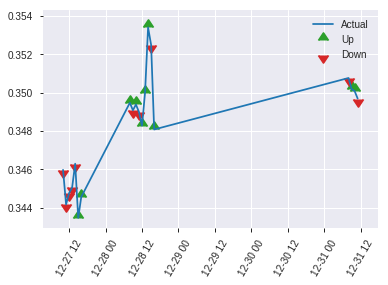


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19528373387896916
RMSE: 0.4419091918923719
LogLoss: 0.5788246788450573
Mean Per-Class Error: 0.24983839689722043
AUC: 0.7857950872656755
pr_auc: 0.6880160577503284
Gini: 0.571590174531351
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4567759335041046: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      78   41   0.3445   (41.0/119.0)
1      17   87   0.1635   (17.0/104.0)
Total  95   128  0.2601   (58.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456776     0.75      127
max f2                       0.297431     0.847176  185
max f0point5                 0.536833     0.737705  95
max accuracy                 0.536833     0.748879  95
max precision                0.771638     0.8       14
max recall                   0.244023     1         203
max specificity              0.836806     0.991597  0
max absolute_mcc             0.493663     0.499195  111
max min_per_class_accuracy   0.500168     0.739496  107
max mean_per_class_accuracy  0.493663     0.750162  111

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 49.38 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.809125           0.714744   0.714744           0.333333         0.822414  0.333333                    0.822414            0.00961538      0.00961538                 -28.5256  -28.5256
    2        0.0224215                   0.790831           2.14423    1.28654            1                0.796706  0.6                         0.812131            0.0192308       0.0288462                  114.423   28.6538
    3        0.0313901                   0.783181           2.14423    1.53159            1                0.787933  0.714286                    0.805217            0.0192308       0.0480769                  114.423   53.1593
    4        0.0403587                   0.778925           2.14423    1.66774            1                0.781266  0.777778                    0.799895            0.0192308       0.0673077                  114.423   66.7735
    5        0.0538117                   0.773655           1.42949    1.60817            0.666667         0.776516  0.75                        0.79405             0.0192308       0.0865385                  42.9487   60.8173
    6        0.103139                    0.733992           1.36451    1.49164            0.636364         0.758759  0.695652                    0.777172            0.0673077       0.153846                   36.451    49.1639
    7        0.152466                    0.698302           1.36451    1.45051            0.636364         0.719283  0.676471                    0.758443            0.0673077       0.221154                   36.451    45.0509
    8        0.201794                    0.664614           1.55944    1.47714            0.727273         0.687399  0.688889                    0.741077            0.0769231       0.298077                   55.9441   47.7137
    9        0.300448                    0.599939           1.85184    1.60017            0.863636         0.636789  0.746269                    0.706833            0.182692        0.480769                   85.1836   60.0172
    10       0.399103                    0.548611           1.55944    1.5901             0.727273         0.576476  0.741573                    0.67461             0.153846        0.634615                   55.9441   59.0104
    11       0.502242                    0.493663           1.30518    1.53159            0.608696         0.523324  0.714286                    0.643542            0.134615        0.769231                   30.5184   53.1593
    12       0.600897                    0.433501           0.77972    1.40815            0.363636         0.465738  0.656716                    0.614351            0.0769231       0.846154                   -22.028   40.8152
    13       0.699552                    0.366708           0.58479    1.29204            0.272727         0.396961  0.602564                    0.583693            0.0576923       0.903846                   -41.521   29.2036
    14       0.798206                    0.313676           0.58479    1.20462            0.272727         0.341084  0.561798                    0.553708            0.0576923       0.961538                   -41.521   20.4624
    15       0.896861                    0.252277           0.292395   1.10428            0.136364         0.28586   0.515                       0.524244            0.0288462       0.990385                   -70.7605  10.4279
    16       1                           0.200956           0.0932274  1                  0.0434783        0.228858  0.466368                  

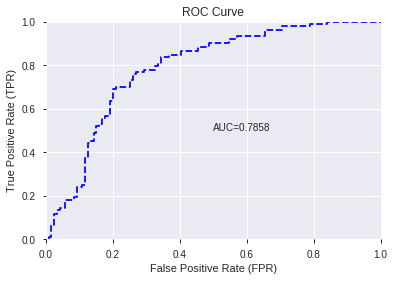

This function is available for GLM models only


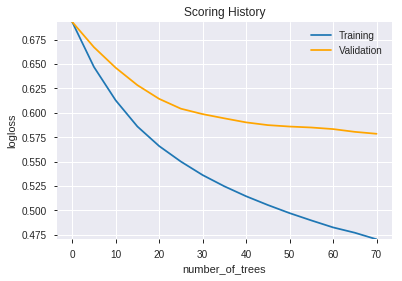

--2019-08-25 17:41:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_174046_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_174046_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a49b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'DIV',
 'SAREXT',
 'hour',
 'Volume',
 'TRANGE',
 'OBV',
 'CORREL_20',
 'ADOSC',
 'ULTOSC',
 'CORREL_24',
 'HT_DCPERIOD',
 'day',
 'CORREL_14',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'CDLGRAVESTONEDOJI',
 'CDLADVANCEBLOCK',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'days_in_month',
 'HT_TRENDMODE',
 'is_month_end',
 'CDLDRAGONFLYDOJI',
 'CDLMATCHINGLOW',
 'CDLEVENINGSTAR',
 'CDLHANGINGMAN',
 'CDLHARAMICROSS',
 'CDLSTICKSANDWICH',
 'CDLTHRUSTING',
 'CDLSTALLEDPATTERN',
 'is_month_start']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_174107_model_1  0.74596  0.59886              0.306157  0.453395  0.205567

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.550549           1.000000  2.998411e-02
1                          SUB             0.215659           0.391716  1.174525e-02
2                         hour             0.195659           0.355388  1.065600e-02
3                        ADOSC             0.180478           0.327815  9.829247e-03
4                    CDLHAMMER             0.180146           0.327212  9.811167e-03
...                        ...                  ...                ...           ...
1031   BBANDS_upperband_12_4_2             0.000060           0.000108  3.243395e-06
1032   BBANDS_middleband_8_2_3             0.000032           0.000058  1.733013e-06
1033  BBANDS_middleband_24_3_2             0.000024           0.000044  1.332507e-06
1034                   MA_14_3             0.000023           0.000042  1.251226e-06
1035  BBANDS_middleband_12_2_5             0.000015           0.000027  8.008590e-07

[1036 rows x 4 columns]

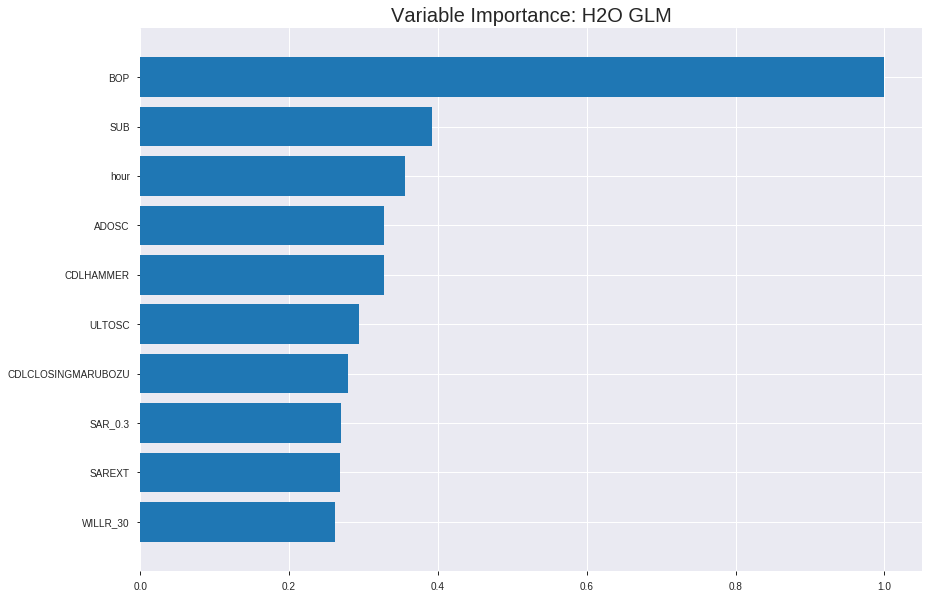

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_174107_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17581278773452536
RMSE: 0.4193003550374425
LogLoss: 0.5276193994985083
Null degrees of freedom: 1556
Residual degrees of freedom: 520
Null deviance: 2146.7404074571314
Residual deviance: 1643.006810038355
AIC: 3717.006810038355
AUC: 0.8154831373253134
pr_auc: 0.7753886016538603
Gini: 0.6309662746506268
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3252807326896594: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      454  392   0.4634   (392.0/846.0)
1      64   647   0.09     (64.0/711.0)
Total  518  1039  0.2929   (456.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.325281     0.739429  264
max f2                       0.299758     0.837357  276
max f0point5                 0.590083     0.728696  144
max accuracy                 0.428819     0.745022  214
max precision                0.987412     1         0
max recall                   0.0368134    1         391
max specificity              0.987412     1         0
max absolute_mcc             0.428819     0.495825  214
max min_per_class_accuracy   0.468283     0.736407  197
max mean_per_class_accuracy  0.428819     0.748646  214

Gains/Lift Table: Avg response rate: 45.66 %, avg score: 45.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.913946           2.18987   2.18987            1                0.941836   1                           0.941836            0.0225035       0.0225035                  118.987   118.987
    2        0.0205523                   0.882755           2.05301   2.12144            0.9375           0.896935   0.96875                     0.919385            0.021097        0.0436006                  105.301   112.144
    3        0.0301863                   0.862746           2.18987   2.14328            1                0.871009   0.978723                    0.903946            0.021097        0.0646976                  118.987   114.328
    4        0.0404624                   0.841908           1.77927   2.05083            0.8125           0.852391   0.936508                    0.890853            0.0182841       0.0829817                  77.9272   105.083
    5        0.0500963                   0.832729           1.7519    1.99335            0.8              0.83631    0.910256                    0.880364            0.0168776       0.0998594                  75.1899   99.3346
    6        0.100193                    0.772631           1.85297   1.92316            0.846154         0.801484   0.878205                    0.840924            0.092827        0.192686                   85.297    92.3158
    7        0.150289                    0.731152           1.62837   1.82489            0.74359          0.753512   0.833333                    0.811787            0.0815752       0.274262                   62.8367   82.4895
    8        0.200385                    0.695198           1.68452   1.7898             0.769231         0.712451   0.817308                    0.786953            0.0843882       0.35865                    68.4518   78.98
    9        0.299936                    0.624482           1.61062   1.73033            0.735484         0.659258   0.79015                     0.74457             0.160338        0.518987                   61.0617   73.0328
    10       0.400128                    0.536368           1.29146   1.62044            0.589744         0.584056   0.739968                    0.704377            0.129395        0.648383                   29.1464   62.0436
    11       0.500321                    0.44525            1.12301   1.52082            0.512821         0.494944   0.69448                     0.662437            0.112518        0.7609                     12.3012   52.0824
    12       0.599872                    0.375856           0.918334  1.42084            0.419355         0.407098   0.648822                    0.620063            0.0914205       0.852321                   -8.1666   42.0839
    13       0.700064                    0.299233           0.729958  1.32196            0.333333         0.337758   0.60367                     0.579659            0.0731364       0.925457                   -27.0042  32.196
    14       0.799615                    0.219464           0.310821  1.19608            0.141935         0.260061   0.546185                    0.53987             0.0309423       0.956399                   -68.9179  19.6075
    15       0.899807                    0.125471           0.294791  1.09572            0.134615         0.172749   0.500357                    0.498991            0.0295359       0.985935                   -70.5209  9.57182
    16       1                           0.00020196         0.140377  1                  0.0641026        0.0763656  0.456647                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20368343045842116
RMSE: 0.4513130071894906
LogLoss: 0.5880987055698198
Null degrees of freedom: 444
Residual degrees of freedom: -592
Null deviance: 611.0451593654886
Residual deviance: 523.4078479571397
AIC: 2597.40784795714
AUC: 0.741926891238423
pr_auc: 0.6663818791887408
Gini: 0.4838537824768461
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3630132821872863: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      129  120  0.4819   (120.0/249.0)
1      26   170  0.1327   (26.0/196.0)
Total  155  290  0.3281   (146.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363013     0.699588  255
max f2                       0.194173     0.834057  328
max f0point5                 0.567341     0.645161  147
max accuracy                 0.567341     0.685393  147
max precision                0.969416     1         0
max recall                   0.032495     1         395
max specificity              0.969416     1         0
max absolute_mcc             0.363013     0.401602  255
max min_per_class_accuracy   0.490789     0.668367  188
max mean_per_class_accuracy  0.414299     0.695312  231

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 46.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.9099             2.27041   2.27041            1                0.930361   1                           0.930361            0.0255102       0.0255102                  127.041   127.041
    2        0.0202247                   0.893176           1.70281   2.01814            0.75             0.898909   0.888889                    0.916382            0.0153061       0.0408163                  70.2806   101.814
    3        0.0314607                   0.872287           2.27041   2.10824            1                0.881859   0.928571                    0.904052            0.0255102       0.0663265                  127.041   110.824
    4        0.0404494                   0.863871           2.27041   2.14427            1                0.867685   0.944444                    0.895971            0.0204082       0.0867347                  127.041   114.427
    5        0.0516854                   0.853943           1.81633   2.07298            0.8              0.856926   0.913043                    0.887483            0.0204082       0.107143                   81.6327   107.298
    6        0.101124                    0.777158           1.3416    1.71542            0.590909         0.813983   0.755556                    0.851549            0.0663265       0.173469                   34.1605   71.542
    7        0.150562                    0.740766           1.44481   1.62656            0.636364         0.758207   0.716418                    0.8209              0.0714286       0.244898                   44.4805   62.6561
    8        0.2                         0.704579           1.1352    1.5051             0.5              0.72617    0.662921                    0.797483            0.0561224       0.30102                    13.5204   50.5102
    9        0.301124                    0.642246           1.36224   1.45713            0.6              0.671537   0.641791                    0.755188            0.137755        0.438776                   36.2245   45.7128
    10       0.4                         0.546988           1.54801   1.47959            0.681818         0.595132   0.651685                    0.715623            0.153061        0.591837                   54.8006   47.9592
    11       0.501124                    0.471318           0.958617  1.37446            0.422222         0.510496   0.605381                    0.67423             0.0969388       0.688776                   -4.13832  37.4462
    12       0.6                         0.412615           1.29      1.36054            0.568182         0.444899   0.599251                    0.636437            0.127551        0.816327                   29.0005   36.0544
    13       0.698876                    0.30906            0.825603  1.28486            0.363636         0.361775   0.565916                    0.597579            0.0816327       0.897959                   -17.4397  28.4861
    14       0.8                         0.222523           0.605442  1.19898            0.266667         0.265524   0.52809                     0.555605            0.0612245       0.959184                   -39.4558  19.898
    15       0.898876                    0.121692           0.309601  1.10115            0.136364         0.173499   0.485                       0.513574            0.0306122       0.989796                   -69.0399  10.1148
    16       1                           0.00468766         0.100907  1                  0.0444444        0.0723699  0.440449                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-25 17:41:10  0.000 sec   2            .2E2      1037          1.34939276070085    1.3466837060198236
     2019-08-25 17:41:12  1.700 sec   4            .14E2     1037          1.3418572784133274  1.3398706943497078
     2019-08-25 17:41:13  3.425 sec   6            .11E2     1037          1.3327258248062992  1.331930945697583
     2019-08-25 17:41:15  5.121 sec   8            .76E1     1037          1.3218334763984039  1.3225967091623603
     2019-08-25 17:41:17  6.829 sec   10           .56E1     1037          1.3090810234327     1.3117182465415096
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-25 17:41:48  37.715 sec  46           .18E-1    1037          1.0468301942560747  1.1766890626337023
     2019-08-25 17:41:49  39.428 sec  48           .13E-1    1037          1.0387230577288866  1.178307143219779
     2019-08-25 17:41:51  41.157 sec  50           .97E-2    1037          1.0308135091314574  1.181675707071583
     2019-08-25 17:41:53  42.879 sec  52           .71E-2    1037          1.0230490188645835  1.1873810288792725
     2019-08-25 17:41:54  44.626 sec  54           .51E-2    1037          1.0154032614132615  1.1958814725954094


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.695067264573991)

('F1', 0.7313432835820896)

('auc', 0.7459599224305107)

('logloss', 0.5988604347886656)

('mean_per_class_error', 0.29783451842275377)

('rmse', 0.4533952099156251)

('mse', 0.20556721637443373)

glm prediction progress: |████████████████████████████████████████████████| 100%


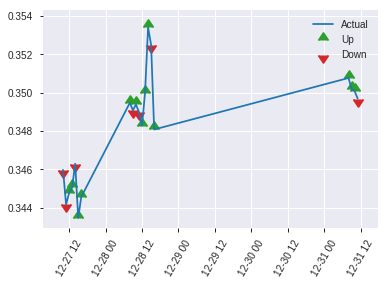


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20556721637443373
RMSE: 0.4533952099156251
LogLoss: 0.5988604347886656
Null degrees of freedom: 222
Residual degrees of freedom: -814
Null deviance: 308.21873965260795
Residual deviance: 267.09175391574485
AIC: 2341.091753915745
AUC: 0.7459599224305107
pr_auc: 0.6498057391097404
Gini: 0.49191984486102136
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2937515085098042: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   66   0.5546   (66.0/119.0)
1      6    98   0.0577   (6.0/104.0)
Total  59   164  0.3229   (72.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.293752     0.731343  163
max f2                       0.250895     0.848739  178
max f0point5                 0.39615      0.664557  131
max accuracy                 0.39615      0.695067  131
max precision                0.830474     0.8       14
max recall                   0.153389     1         197
max specificity              0.969885     0.991597  0
max absolute_mcc             0.293752     0.438452  163
max min_per_class_accuracy   0.49144      0.663866  109
max mean_per_class_accuracy  0.39615      0.702165  131

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 48.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.92004            0.714744  0.714744           0.333333         0.939137  0.333333                    0.939137            0.00961538      0.00961538                 -28.5256  -28.5256
    2        0.0224215                   0.879232           1.07212   0.857692           0.5              0.900985  0.4                         0.923876            0.00961538      0.0192308                  7.21154   -14.2308
    3        0.0313901                   0.858217           2.14423   1.22527            1                0.871646  0.571429                    0.908953            0.0192308       0.0384615                  114.423   22.5275
    4        0.0403587                   0.848724           2.14423   1.42949            1                0.850938  0.666667                    0.896061            0.0192308       0.0576923                  114.423   42.9487
    5        0.0538117                   0.837001           2.14423   1.60817            1                0.84397   0.75                        0.883038            0.0288462       0.0865385                  114.423   60.8173
    6        0.103139                    0.805966           1.55944   1.58487            0.727273         0.821783  0.73913                     0.853742            0.0769231       0.163462                   55.9441   58.4866
    7        0.152466                    0.768791           1.36451   1.51357            0.636364         0.785994  0.705882                    0.831824            0.0673077       0.230769                   36.451    51.3575
    8        0.201794                    0.731447           1.36451   1.47714            0.636364         0.748645  0.688889                    0.811491            0.0673077       0.298077                   36.451    47.7137
    9        0.300448                    0.652506           1.46198   1.47216            0.681818         0.691463  0.686567                    0.772079            0.144231        0.442308                   46.1976   47.2158
    10       0.399103                    0.581846           1.36451   1.44555            0.636364         0.615926  0.674157                    0.733479            0.134615        0.576923                   36.451    44.5549
    11       0.502242                    0.469271           1.0255    1.35929            0.478261         0.539396  0.633929                    0.693623            0.105769        0.682692                   2.55017   35.9289
    12       0.600897                    0.391554           1.26705   1.34414            0.590909         0.43232   0.626866                    0.650722            0.125           0.807692                   26.7045   34.4145
    13       0.699552                    0.322064           0.97465   1.29204            0.454545         0.357285  0.602564                    0.60934             0.0961538       0.903846                   -2.53497  29.2036
    14       0.798206                    0.251498           0.58479   1.20462            0.272727         0.282313  0.561798                    0.568921            0.0576923       0.961538                   -41.521   20.4624
    15       0.896861                    0.146067           0.38986   1.115              0.181818         0.191952  0.52                        0.527454            0.0384615       1                          -61.014   11.5
    16       1                           0.0224272          0         1                  0                0.084709  0.466368                    0.48179           

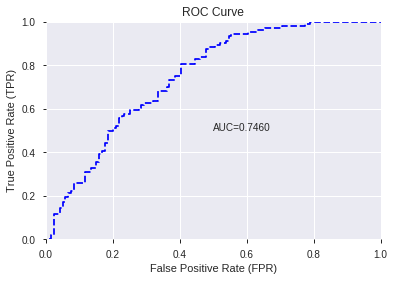

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


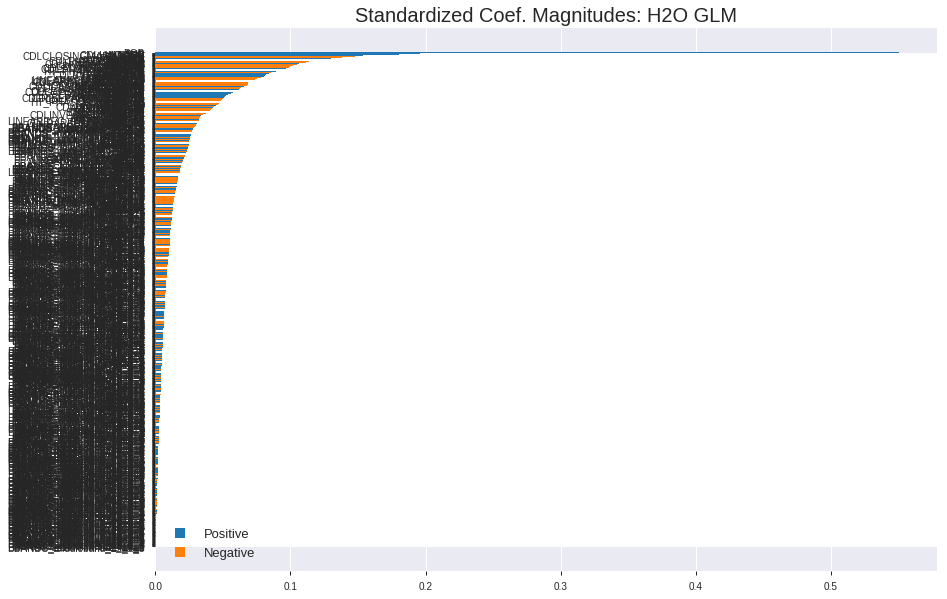

'log_likelihood'
--2019-08-25 17:42:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_174107_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_174107_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a49b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

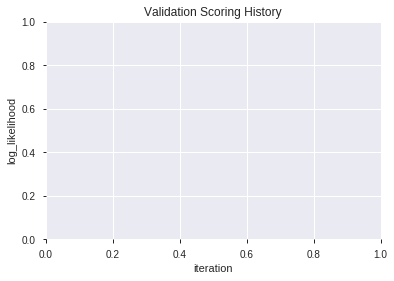

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190825_174220  0.791209  0.563870              0.304945  0.436632  0.190648
1  XGBoost_grid_1_AutoML_20190825_174220_model_3  0.790643  0.567360              0.270766  0.437256  0.191193
2  XGBoost_grid_1_AutoML_20190825_174220_model_7  0.789350  0.574128              0.275574  0.440489  0.194031
3  XGBoost_grid_1_AutoML_20190825_174220_model_2  0.788300  0.609132              0.273190  0.457275  0.209101
4               XGBoost_3_AutoML_20190825_174220  0.783856  0.583655              0.294158  0.445293  0.198286
5  XGBoost_grid_1_AutoML_20190825_174220_model_4  0.783613  0.559291              0.271412  0.434569  0.188850
6               XGBoost_1_AutoML_20190825_174220  0.782482  0.574100              0.268382  0.439732  0.193364
7  XGBoost_grid_1_AutoML_20190825_174220_model_1  0.781593  0.574835              0.283371  0.441736  0.195131
8  XGBoost_grid_1_AutoML_20190825_174220_model_6  0.769716  0.598632              0.277392  0.452382  0.204649
9  XGBoost_grid_1_AutoML_20190825_174220_model_5  0.753394  0.654576              0.291815  0.479790  0.230199

variable  relative_importance  scaled_importance  percentage
0                        BOP          1476.351440           1.000000    0.205655
1                        SUB           426.100861           0.288617    0.059356
2               STOCHF_fastk           272.122742           0.184321    0.037907
3                        DIV           253.548935           0.171740    0.035319
4                    WILLR_8           242.579269           0.164310    0.033791
..                       ...                  ...                ...         ...
261  BBANDS_upperband_24_0_4             2.186002           0.001481    0.000305
262              aroondown_8             1.826447           0.001237    0.000254
263                   VAR_12             1.271423           0.000861    0.000177
264               PLUS_DM_12             1.270433           0.000861    0.000177
265                   RSI_14             0.392803           0.000266    0.000055

[266 rows x 4 columns]

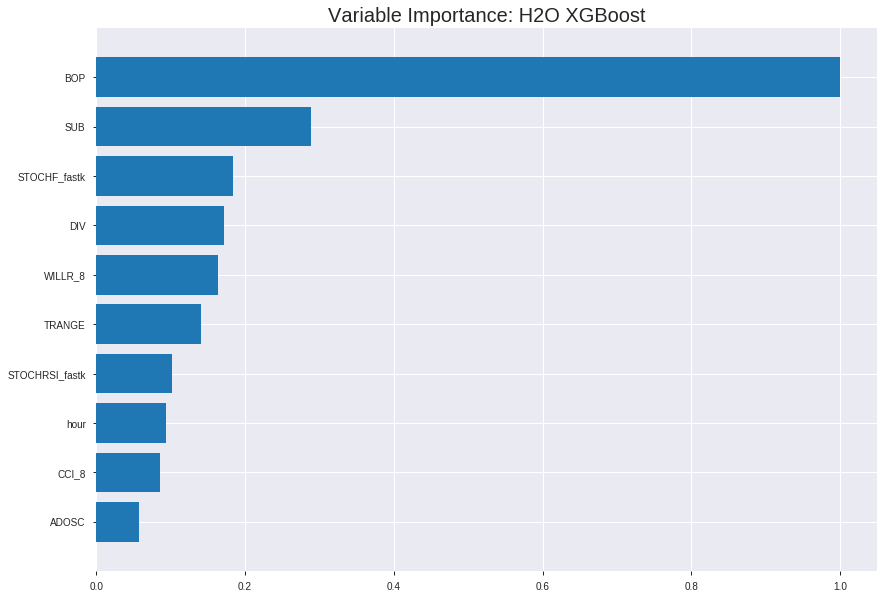

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190825_174220


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13303923545037705
RMSE: 0.3647454392454785
LogLoss: 0.43185317782393784
Mean Per-Class Error: 0.163763952479277
AUC: 0.9230406679235119
pr_auc: 0.9128058427766246
Gini: 0.8460813358470238
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4736807545026143: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      691  155  0.1832   (155.0/846.0)
1      104  607  0.1463   (104.0/711.0)
Total  795  762  0.1663   (259.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.473681     0.824168  198
max f2                       0.332732     0.887368  266
max f0point5                 0.608644     0.85866   132
max accuracy                 0.553433     0.842646  159
max precision                0.916673     1         0
max recall                   0.128121     1         369
max specificity              0.916673     1         0
max absolute_mcc             0.553433     0.684648  159
max min_per_class_accuracy   0.49129      0.833333  190
max mean_per_class_accuracy  0.553433     0.836236  159

Gains/Lift Table: Avg response rate: 45.66 %, avg score: 46.12 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.868084           2.18987    2.18987            1                0.883146  1                           0.883146            0.0225035       0.0225035                  118.987   118.987
    2        0.0205523                   0.852345           2.18987    2.18987            1                0.859828  1                           0.871487            0.0225035       0.045007                   118.987   118.987
    3        0.0301863                   0.833851           2.18987    2.18987            1                0.842503  1                           0.862237            0.021097        0.0661041                  118.987   118.987
    4        0.0404624                   0.82486            2.18987    2.18987            1                0.828472  1                           0.853661            0.0225035       0.0886076                  118.987   118.987
    5        0.0500963                   0.818175           2.04388    2.1618             0.933333         0.821232  0.987179                    0.847425            0.0196906       0.108298                   104.388   116.18
    6        0.100193                    0.768711           2.18987    2.17584            1                0.793371  0.99359                     0.820398            0.109705        0.218003                   118.987   117.584
    7        0.150289                    0.735623           2.0495     2.13372            0.935897         0.750518  0.974359                    0.797105            0.102672        0.320675                   104.95    113.372
    8        0.200385                    0.700318           2.07757    2.11969            0.948718         0.718052  0.967949                    0.777342            0.104079        0.424754                   107.757   111.969
    9        0.299936                    0.629064           1.92144    2.05389            0.877419         0.665878  0.937901                    0.740346            0.19128         0.616034                   92.1437   105.389
    10       0.400128                    0.549951           1.48799    1.91218            0.679487         0.590327  0.873194                    0.702781            0.149086        0.76512                    48.7991   91.2185
    11       0.500321                    0.464712           0.95456    1.72041            0.435897         0.508499  0.785623                    0.663875            0.0956399       0.860759                   -4.54398  72.0414
    12       0.599872                    0.375541           0.748795   1.55917            0.341935         0.420139  0.711991                    0.623426            0.0745429       0.935302                   -25.1205  55.9171
    13       0.700064                    0.289425           0.42113    1.3963             0.192308         0.334584  0.637615                    0.582087            0.0421941       0.977496                   -57.887   39.6295
    14       0.799615                    0.211289           0.15541    1.24181            0.0709677        0.251579  0.567068                    0.54094             0.0154712       0.992968                   -84.459   24.1808
    15       0.899807                    0.143447           0.0561506  1.10979            0.025641         0.178947  0.506781                    0.500632            0.00562588      0.998594                   -94.3849  10.9786
    16       1                           0.0614251          0.0140377  1                  0.00641026       0.106976  0.456647                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19755302204905997
RMSE: 0.4444693713283965
LogLoss: 0.5790132577786514
Mean Per-Class Error: 0.29844889763134175
AUC: 0.7603372674370954
pr_auc: 0.684370615917653
Gini: 0.5206745348741908
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31887373328208923: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      122  127  0.51     (127.0/249.0)
1      23   173  0.1173   (23.0/196.0)
Total  145  300  0.3371   (150.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318874     0.697581  270
max f2                       0.220079     0.816681  331
max f0point5                 0.609705     0.669399  119
max accuracy                 0.609705     0.698876  119
max precision                0.891579     1         0
max recall                   0.111959     1         389
max specificity              0.891579     1         0
max absolute_mcc             0.425852     0.40311   232
max min_per_class_accuracy   0.504659     0.694779  189
max mean_per_class_accuracy  0.445482     0.701551  221

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 46.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.853076           1.81633   1.81633            0.8              0.879449  0.8                         0.879449            0.0204082       0.0204082                  81.6327   81.6327
    2        0.0202247                   0.830132           1.70281   1.76587            0.75             0.835726  0.777778                    0.860017            0.0153061       0.0357143                  70.2806   76.5873
    3        0.0314607                   0.819542           1.81633   1.78389            0.8              0.824979  0.785714                    0.847503            0.0204082       0.0561224                  81.6327   78.3892
    4        0.0404494                   0.804347           1.70281   1.76587            0.75             0.813285  0.777778                    0.839899            0.0153061       0.0714286                  70.2806   76.5873
    5        0.0516854                   0.790819           1.81633   1.77684            0.8              0.797994  0.782609                    0.830789            0.0204082       0.0918367                  81.6327   77.6841
    6        0.101124                    0.746895           1.75441   1.76587            0.772727         0.765687  0.777778                    0.798961            0.0867347       0.178571                   75.4406   76.5873
    7        0.150562                    0.711449           1.75441   1.76211            0.772727         0.727918  0.776119                    0.775634            0.0867347       0.265306                   75.4406   76.2108
    8        0.2                         0.679605           1.65121   1.73469            0.727273         0.695692  0.764045                    0.755873            0.0816327       0.346939                   65.1206   73.4694
    9        0.301124                    0.609519           1.51361   1.66045            0.666667         0.642431  0.731343                    0.717777            0.153061        0.5                        51.3605   66.0448
    10       0.4                         0.562552           0.928803  1.47959            0.409091         0.585127  0.651685                    0.684987            0.0918367       0.591837                   -7.11967  47.9592
    11       0.501124                    0.496624           1.26134   1.43555            0.555556         0.526348  0.632287                    0.652974            0.127551        0.719388                   26.1338   43.555
    12       0.6                         0.398837           0.928803  1.35204            0.409091         0.449075  0.595506                    0.619373            0.0918367       0.811224                   -7.11967  35.2041
    13       0.698876                    0.303186           0.825603  1.27756            0.363636         0.344772  0.562701                    0.580523            0.0816327       0.892857                   -17.4397  27.7561
    14       0.8                         0.234695           0.353175  1.16071            0.155556         0.268824  0.511236                    0.541123            0.0357143       0.928571                   -64.6825  16.0714
    15       0.898876                    0.164593           0.516002  1.0898             0.227273         0.20187   0.48                        0.503805            0.0510204       0.979592                   -48.3998  8.97959
    16       1                           0.082855           0.201814  1                  0.0888889        0.128267  0.440449                    0.465829          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:42:24  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.543353                         0.5                0.693147              0.5               0                    1                  0.559551
    2019-08-25 17:42:25  0.575 sec   5                  0.472696         0.639689            0.835622        0.787192           2.18987          0.265254                         0.480223           0.654144              0.755225          0.660843             1.81633            0.303371
    2019-08-25 17:42:25  1.007 sec   10                 0.452351         0.600667            0.851714        0.830916           2.18987          0.236352                         0.467216           0.62862               0.759999          0.693715             2.27041            0.28764
    2019-08-25 17:42:26  1.437 sec   15                 0.435996         0.569304            0.861029        0.844676           2.18987          0.226076                         0.456742           0.607854              0.765081          0.68695              1.81633            0.296629
    2019-08-25 17:42:26  1.870 sec   20                 0.4233           0.544691            0.870383        0.854063           2.18987          0.216442                         0.451509           0.596868              0.764097          0.681803             1.81633            0.296629
    2019-08-25 17:42:26  2.310 sec   25                 0.412733         0.52423             0.879112        0.861373           2.18987          0.208735                         0.448176           0.589521              0.766054          0.682742             1.81633            0.310112
    2019-08-25 17:42:27  2.728 sec   30                 0.40386          0.506821            0.886407        0.870424           2.18987          0.19589                          0.445589           0.583894              0.766361          0.685129             1.81633            0.31236
    2019-08-25 17:42:27  3.169 sec   35                 0.395745         0.490974            0.893197        0.877709           2.18987          0.19332                          0.444449           0.580938              0.765173          0.685039             2.27041            0.303371
    2019-08-25 17:42:28  3.602 sec   40                 0.388565         0.476923            0.898807        0.883311           2.18987          0.192678                         0.444974           0.581358              0.761433          0.681652             1.81633            0.307865
    2019-08-25 17:42:28  4.015 sec   45                 0.382492         0.46514             0.904485        0.890384           2.18987          0.186898                         0.443263           0.577202              0.764517          0.686278             1.81633            0.31236
    2019-08-25 17:42:29  4.464 sec   50                 0.37684          0.454229            0.910514        0.897517           2.18987          0.184329                         0.444057           0.578454              0.762171          0.68371              1.81633            0.316854
    2019-08-25 17:42:29  4.899 sec   55                 0.371248         0.443541            0.91517         0.903063           2.18987          0.171484                         0.44378            0.577964              0.762028          0.68

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      1476.3514404296875     1.0                    0.20565512414045797
SUB                      426.1008605957031      0.288617499144843      0.059355667615741216
STOCHF_fastk             272.12274169921875     0.18432111369093682    0.037906581517817076
DIV                      253.54893493652344     0.1717402293201467     0.03531925818074549
WILLR_8                  242.5792694091797      0.16430997577282666    0.033791188465076304
---                      ---                    ---                    ---
BBANDS_upperband_24_0_4  2.186001777648926      0.001480678460280905   0.00030450911256117165
aroondown_8              1.826446533203125      0.0012371353345728734  0.0002544232208101313
VAR_12                   1.27142333984375       0.0008611928738821877  0.00017710872738711908
PLUS_DM_12               1.2704334259033203     0.0008605223601323304  0.0001769708327986543
RSI_14                   0.3928031921386719     0.0002660634733585844  5.471731664280111e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.726457399103139)

('F1', 0.7352941176470588)

('auc', 0.7912087912087913)

('logloss', 0.5638703410017905)

('mean_per_class_error', 0.2744828700711053)

('rmse', 0.43663202645783794)

('mse', 0.19064752652867809)

xgboost prediction progress: |████████████████████████████████████████████| 100%


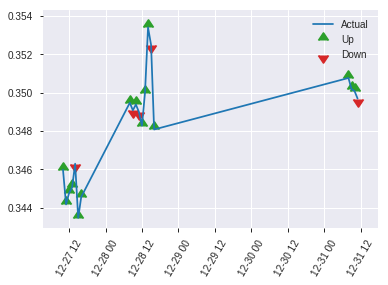


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19064752652867809
RMSE: 0.43663202645783794
LogLoss: 0.5638703410017905
Mean Per-Class Error: 0.2744828700711053
AUC: 0.7912087912087913
pr_auc: 0.7137125377697291
Gini: 0.5824175824175826
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3375486135482788: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      51   68   0.5714   (68.0/119.0)
1      4    100  0.0385   (4.0/104.0)
Total  55   168  0.3229   (72.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337549     0.735294  167
max f2                       0.293691     0.858586  177
max f0point5                 0.653752     0.719027  86
max accuracy                 0.653752     0.726457  86
max precision                0.854165     0.833333  5
max recall                   0.174753     1         207
max specificity              0.871995     0.991597  0
max absolute_mcc             0.337549     0.451483  167
max min_per_class_accuracy   0.600871     0.711538  104
max mean_per_class_accuracy  0.600871     0.725517  104

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 53.11 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.860684           1.42949    1.42949            0.666667         0.865941  0.666667                    0.865941            0.0192308       0.0192308                  42.9487   42.9487
    2        0.0224215                   0.855607           2.14423    1.71538            1                0.858478  0.8                         0.862956            0.0192308       0.0384615                  114.423   71.5385
    3        0.0313901                   0.848302           1.07212    1.53159            0.5              0.851668  0.714286                    0.859731            0.00961538      0.0480769                  7.21154   53.1593
    4        0.0403587                   0.847466           2.14423    1.66774            1                0.847845  0.777778                    0.85709             0.0192308       0.0673077                  114.423   66.7735
    5        0.0538117                   0.843516           1.42949    1.60817            0.666667         0.846103  0.75                        0.854343            0.0192308       0.0865385                  42.9487   60.8173
    6        0.103139                    0.792439           1.55944    1.58487            0.727273         0.810287  0.73913                     0.833273            0.0769231       0.163462                   55.9441   58.4866
    7        0.152466                    0.773263           2.14423    1.76584            1                0.784499  0.823529                    0.817493            0.105769        0.269231                   114.423   76.5837
    8        0.201794                    0.754743           1.36451    1.66774            0.636364         0.762801  0.777778                    0.804124            0.0673077       0.336538                   36.451    66.7735
    9        0.300448                    0.691669           1.46198    1.60017            0.681818         0.725707  0.746269                    0.778375            0.144231        0.480769                   46.1976   60.0172
    10       0.399103                    0.651012           1.55944    1.5901             0.727273         0.671864  0.741573                    0.752046            0.153846        0.634615                   55.9441   59.0104
    11       0.502242                    0.583813           0.932274   1.45501            0.434783         0.615217  0.678571                    0.723947            0.0961538       0.730769                   -6.77258  45.5014
    12       0.600897                    0.483836           0.97465    1.37615            0.454545         0.527721  0.641791                    0.691731            0.0961538       0.826923                   -2.53497  37.6148
    13       0.699552                    0.36966            0.682255   1.27829            0.318182         0.428165  0.596154                    0.654562            0.0673077       0.894231                   -31.7745  27.8291
    14       0.798206                    0.291015           0.877185   1.22872            0.409091         0.333809  0.573034                    0.614918            0.0865385       0.980769                   -12.2815  22.8717
    15       0.896861                    0.201924           0.097465   1.10428            0.0454545        0.239396  0.515                       0.57361             0.00961538      0.990385                   -90.2535  10.4279
    16       1                           0.123394           0.0932274  1                  0.0434783        0.161292  0.466368                   

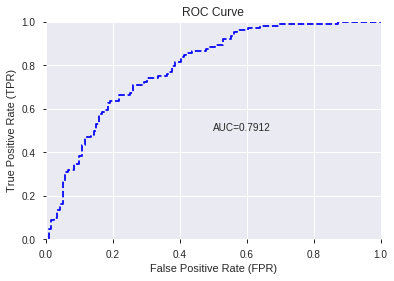

This function is available for GLM models only


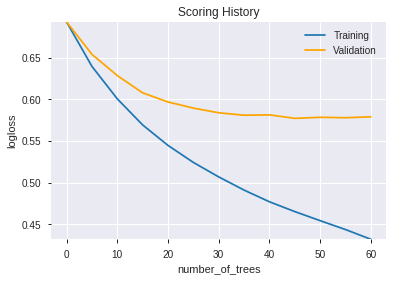

--2019-08-25 17:43:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.4
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.4|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


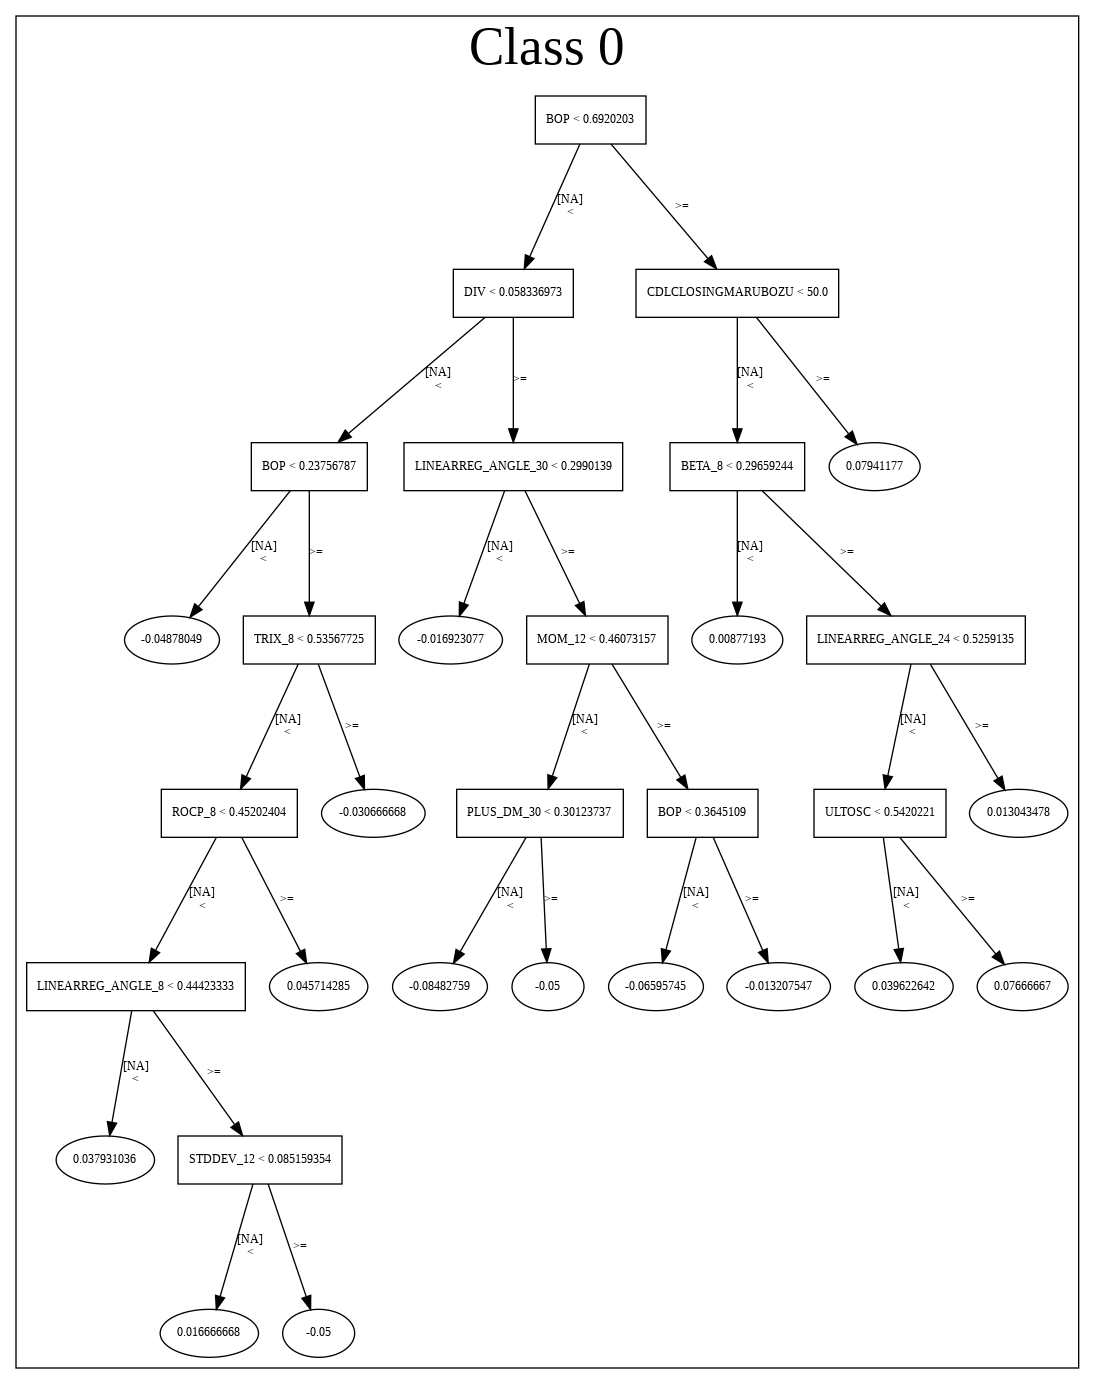

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190825_174220',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190825_174220',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a49b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_a49b',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_174311_model_6  0.768342  0.577249              0.286401  0.443641  0.196817
1  DeepLearning_grid_1_AutoML_20190825_174311_model_9  0.756949  0.598217              0.312783  0.456150  0.208073
2  DeepLearning_grid_1_AutoML_20190825_174311_model_5  0.754686  0.582888              0.308581  0.449831  0.202348
3  DeepLearning_grid_1_AutoML_20190825_174311_model_8  0.753636  0.591350              0.334963  0.453679  0.205825
4  DeepLearning_grid_1_AutoML_20190825_174311_model_3  0.737637  0.713136              0.321833  0.463058  0.214423
5  DeepLearning_grid_1_AutoML_20190825_174311_model_2  0.737153  0.875046              0.321792  0.505589  0.255621
6               DeepLearning_1_AutoML_20190825_174311  0.727376  0.673502              0.285795  0.474295  0.224956
7  DeepLearning_grid_1_AutoML_20190825_174311_model_4  0.703620  0.745355              0.346396  0.488593  0.238723
8  DeepLearning_grid_1_AutoML_20190825_174311_model_1  0.693843  0.914159              0.347649  0.496019  0.246035
9  DeepLearning_grid_1_AutoML_20190825_174311_model_7  0.687056  0.736769              0.357789  0.513645  0.263831

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.044474
1           CDLLONGLINE             0.687920           0.687920    0.030595
2    CDLCLOSINGMARUBOZU             0.644717           0.644717    0.028673
3                   DIV             0.608609           0.608609    0.027068
4        STOCHRSI_fastk             0.607524           0.607524    0.027019
5                  hour             0.580502           0.580502    0.025817
6                   SUB             0.576444           0.576444    0.025637
7           CDLBELTHOLD             0.565181           0.565181    0.025136
8                TRANGE             0.551905           0.551905    0.024546
9                SAREXT             0.542868           0.542868    0.024144
10         HT_TRENDMODE             0.532835           0.532835    0.023698
11            CORREL_20             0.487710           0.487710    0.021691
12      CDLHOMINGPIGEON             0.468222           0.468222    0.020824
13    CDLDARKCLOUDCOVER             0.466204           0.466204    0.020734
14      CDLSHOOTINGSTAR             0.463793           0.463793    0.020627
15               ULTOSC             0.461737           0.461737    0.020535
16   CDLMORNINGDOJISTAR             0.441461           0.441461    0.019634
17  CDLGAPSIDESIDEWHITE             0.436708           0.436708    0.019422
18       CDLMORNINGSTAR             0.435961           0.435961    0.019389
19            CORREL_14             0.435658           0.435658    0.019376
20  CDLRISEFALL3METHODS             0.435398           0.435398    0.019364
21    CDLSTALLEDPATTERN             0.433249           0.433249    0.019268
22        days_in_month             0.432892           0.432892    0.019253
23    CDL3WHITESOLDIERS             0.421378           0.421378    0.018741
24       CDLEVENINGSTAR             0.420755           0.420755    0.018713
25               Volume             0.419257           0.419257    0.018646
26         CDLTHRUSTING             0.410386           0.410386    0.018252
27            CDLHAMMER             0.406951           0.406951    0.018099
28     CDLSTICKSANDWICH             0.400981           0.400981    0.017833
29                  OBV             0.396988           0.396988    0.017656
30   CDLEVENINGDOJISTAR             0.396129           0.396129    0.017618
31          CDLPIERCING             0.395299           0.395299    0.017581
32        CDLHANGINGMAN             0.395230           0.395230    0.017578
33   CDLIDENTICAL3CROWS             0.393169           0.393169    0.017486
34                ADOSC             0.392860           0.392860    0.017472
35                  day             0.389769           0.389769    0.017335
36            CDLONNECK             0.380337           0.380337    0.016915
37        CDLHIKKAKEMOD             0.373435           0.373435    0.016608
38    CDLGRAVESTONEDOJI             0.369343           0.369343    0.016426
39      CDLADVANCEBLOCK             0.364373           0.364373    0.016205
40    CDLINVERTEDHAMMER             0.363608           0.363608    0.016171
41       CDL3LINESTRIKE             0.361490           0.361490    0.016077
42          HT_DCPERIOD             0.356294           0.356294    0.015846
43         is_month_end             0.350133           0.350133    0.015572
44       CDLHARAMICROSS             0.347610           0.347610    0.015460
45       is_month_start             0.345902           0.345902    0.015384
46            CORREL_24             0.341570           0.341570    0.015191
47     CDLDRAGONFLYDOJI             0.336167           0.336167    0.014951
48            CDLTAKURI             0.330387           0.330387    0.014694
49       CDLMATCHINGLOW             0.327532           0.327532    0.014567

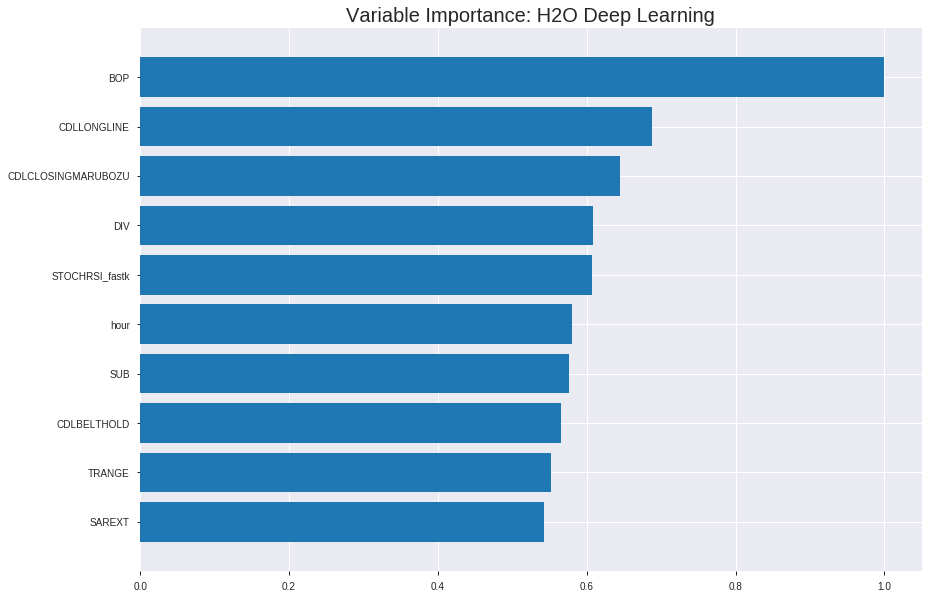

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_174311_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17577094472543253
RMSE: 0.41925045584403664
LogLoss: 0.5232802769021486
Mean Per-Class Error: 0.26466319537959726
AUC: 0.8142104983158938
pr_auc: 0.7789340919291763
Gini: 0.6284209966317875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4427415109012461: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      544  302  0.357    (302.0/846.0)
1      127  584  0.1786   (127.0/711.0)
Total  671  886  0.2755   (429.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442742     0.731371  226
max f2                       0.128579     0.841428  341
max f0point5                 0.584894     0.726061  157
max accuracy                 0.523082     0.737958  185
max precision                0.994397     1         0
max recall                   0.0244931    1         389
max specificity              0.994397     1         0
max absolute_mcc             0.523082     0.470258  185
max min_per_class_accuracy   0.498796     0.730496  198
max mean_per_class_accuracy  0.474668     0.735337  211

Gains/Lift Table: Avg response rate: 45.66 %, avg score: 46.10 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.965888           2.18987    2.18987            1                0.976642   1                           0.976642            0.0225035       0.0225035                  118.987   118.987
    2        0.0205523                   0.944046           1.91614    2.05301            0.875            0.956783   0.9375                      0.966712            0.0196906       0.0421941                  91.6139   105.301
    3        0.0301863                   0.926852           1.89789    2.0035             0.866667         0.934046   0.914894                    0.956287            0.0182841       0.0604782                  89.789    100.35
    4        0.0404624                   0.915122           2.18987    2.05083            1                0.921759   0.936508                    0.947518            0.0225035       0.0829817                  118.987   105.083
    5        0.0500963                   0.905              2.18987    2.07757            1                0.909481   0.948718                    0.940203            0.021097        0.104079                   118.987   107.757
    6        0.100193                    0.830567           1.99335    2.03546            0.910256         0.866363   0.929487                    0.903283            0.0998594       0.203938                   99.3346   103.546
    7        0.150289                    0.772233           1.62837    1.89976            0.74359          0.799681   0.867521                    0.868749            0.0815752       0.285513                   62.8367   89.9762
    8        0.200385                    0.712727           1.54414    1.81086            0.705128         0.741312   0.826923                    0.83689             0.0773558       0.362869                   54.4142   81.0857
    9        0.299936                    0.616214           1.56823    1.73033            0.716129         0.663471   0.79015                     0.779331            0.156118        0.518987                   56.8232   73.0328
    10       0.400128                    0.548087           1.24935    1.60989            0.570513         0.58086    0.735152                    0.729634            0.125176        0.644163                   24.9351   60.9891
    11       0.500321                    0.487295           1.09494    1.50677            0.5              0.514472   0.688062                    0.686546            0.109705        0.753868                   9.49367   50.6768
    12       0.599872                    0.414094           0.847693   1.39739            0.387097         0.453545   0.638116                    0.647879            0.0843882       0.838256                   -15.2307  39.7392
    13       0.700064                    0.295191           0.71592    1.29986            0.326923         0.369371   0.593578                    0.608019            0.07173         0.909986                   -28.408   29.9861
    14       0.799615                    0.149218           0.565129   1.20839            0.258065         0.216554   0.551807                    0.559282            0.0562588       0.966245                   -43.4871  20.8388
    15       0.899807                    0.0642421          0.252678   1.10197            0.115385         0.0987819  0.503212                    0.508006            0.0253165       0.991561                   -74.7322  10.1971
    16       1                           0.0013056          0.0842259  1                  0.0384615        0.0386512  0.456647  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19264510909227678
RMSE: 0.4389135553754028
LogLoss: 0.5700371998810719
Mean Per-Class Error: 0.27614539791820336
AUC: 0.7775694615195475
pr_auc: 0.6939575370481994
Gini: 0.5551389230390951
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29314259873320275: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  129  0.5181   (129.0/249.0)
1      17   179  0.0867   (17.0/196.0)
Total  137  308  0.3281   (146.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.293143     0.710317  276
max f2                       0.0905501    0.831897  342
max f0point5                 0.516937     0.682339  153
max accuracy                 0.461842     0.721348  191
max precision                0.901767     0.875     23
max recall                   0.0328184    1         391
max specificity              0.984383     0.995984  0
max absolute_mcc             0.458704     0.444551  196
max min_per_class_accuracy   0.463143     0.714859  189
max mean_per_class_accuracy  0.458704     0.723855  196

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 43.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.955413           1.81633   1.81633            0.8              0.968496   0.8                         0.968496            0.0204082       0.0204082                  81.6327   81.6327
    2        0.0202247                   0.935578           1.70281   1.76587            0.75             0.946437   0.777778                    0.958692            0.0153061       0.0357143                  70.2806   76.5873
    3        0.0314607                   0.922569           1.81633   1.78389            0.8              0.929142   0.785714                    0.948138            0.0204082       0.0561224                  81.6327   78.3892
    4        0.0404494                   0.913075           2.27041   1.89201            1                0.91819    0.833333                    0.941483            0.0204082       0.0765306                  127.041   89.2007
    5        0.0516854                   0.904231           2.27041   1.97427            1                0.908173   0.869565                    0.934242            0.0255102       0.102041                   127.041   97.4268
    6        0.101124                    0.819651           1.44481   1.71542            0.636364         0.860603   0.755556                    0.89824             0.0714286       0.173469                   44.4805   71.542
    7        0.150562                    0.696091           1.75441   1.72822            0.772727         0.747528   0.761194                    0.848753            0.0867347       0.260204                   75.4406   72.8221
    8        0.2                         0.648194           1.54801   1.68367            0.681818         0.668572   0.741573                    0.804213            0.0765306       0.336735                   54.8006   68.3673
    9        0.301124                    0.573009           1.56406   1.6435             0.688889         0.607077   0.723881                    0.738011            0.158163        0.494898                   56.4059   64.3504
    10       0.4                         0.494558           1.3416    1.56888            0.590909         0.537956   0.691011                    0.688559            0.132653        0.627551                   34.1605   56.8878
    11       0.501124                    0.457292           1.16043   1.48646            0.511111         0.472303   0.654709                    0.64492             0.117347        0.744898                   16.0431   48.6456
    12       0.6                         0.393626           0.619202  1.34354            0.272727         0.426106   0.59176                     0.608861            0.0612245       0.806122                   -38.0798  34.3537
    13       0.698876                    0.277435           1.0836    1.30676            0.477273         0.340114   0.575563                    0.570839            0.107143        0.913265                   8.36039   30.6762
    14       0.8                         0.145097           0.504535  1.20536            0.222222         0.205985   0.530899                    0.524719            0.0510204       0.964286                   -49.5465  20.5357
    15       0.898876                    0.0602318          0.206401  1.09547            0.0909091        0.0928772  0.4825                      0.477217            0.0204082       0.984694                   -79.3599  9.54719
    16       1                           0.00320812         0.151361  1                  0.0666667        0.0396387  0.440449                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:47:32  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 17:47:34  2 min 14.787 sec  932 obs/sec       1.41105   1             2197       0.485738         0.762067            0.0490872      0.752175        0.689356           1.77927          0.35517                          0.486409           0.73029               0.040007         0.723916          0.654001             2.27041            0.379775
    2019-08-25 17:47:40  2 min 21.109 sec  1638 obs/sec      8.49133   6             13221      0.436225         0.560063            0.233067       0.789833        0.735386           2.05301          0.287091                         0.445822           0.576546              0.193531         0.759374          0.671596             1.36224            0.355056
    2019-08-25 17:47:47  2 min 27.396 sec  2088 obs/sec      18.429    13            28694      0.428428         0.542604            0.260235       0.799596        0.757201           2.05301          0.307643                         0.445144           0.576356              0.195981         0.761526          0.682039             1.36224            0.357303
    2019-08-25 17:47:54  2 min 34.292 sec  2317 obs/sec      29.7836   21            46373      0.41925          0.52328             0.291591       0.81421         0.778934           2.18987          0.27553                          0.438914           0.570037              0.218332         0.777569          0.693958             1.81633            0.32809
    2019-08-25 17:48:00  2 min 40.925 sec  2454 obs/sec      41.0803   29            63962      0.412005         0.508434            0.315863       0.829328        0.795841           2.18987          0.260116                         0.442699           0.575382              0.204792         0.771095          0.688702             1.36224            0.352809
    2019-08-25 17:48:07  2 min 47.390 sec  2550 obs/sec      52.2942   37            81422      0.407045         0.498156            0.332236       0.836125        0.804616           2.18987          0.242132                         0.442647           0.578595              0.204977         0.771218          0.68735              1.36224            0.316854
    2019-08-25 17:48:13  2 min 53.790 sec  2625 obs/sec      63.5999   45            99025      0.398188         0.482234            0.360981       0.850632        0.826084           2.18987          0.248555                         0.444283           0.581375              0.199089         0.769097          0.688976             0.908163           0.339326
    2019-08-25 17:48:14  2 min 54.415 sec  2624 obs/sec      63.5999   45            99025      0.41925          0.52328             0.291591       0.81421         0.778934           2.18987          0.27553                          0.438914           0.570037              0.218332         0.777569          0.693958             1.81633            0.32809

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.044474428930282514
CDLLONGLINE         0.687919557094574      0.687919557094574    0.030594829451754055
CDLCLOSINGMARUBOZU  0.6447173357009888     0.6447173357009888   0.02867343532675472
DIV                 0.6086092591285706     0.6086092591285706   0.027067549241425508
STOCHRSI_fastk      0.6075241565704346     0.6075241565704346   0.02701928992482162
---                 ---                    ---                  ---
is_month_start      0.34590160846710205    0.34590160846710205  0.015383776502640539
CORREL_24           0.34157001972198486    0.34157001972198486  0.015191131566840613
CDLDRAGONFLYDOJI    0.3361673653125763     0.3361673653125763   0.014950851597274495
CDLTAKURI           0.3303874731063843     0.3303874731063843   0.014693794192125515
CDLMATCHINGLOW      0.3275315761566162     0.3275315761566162   0.014566779806200844


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7040358744394619)

('F1', 0.7295081967213114)

('auc', 0.7683419521654816)

('logloss', 0.577248907656606)

('mean_per_class_error', 0.286401098901099)

('rmse', 0.4436410553333207)

('mse', 0.19681738597726253)

deeplearning prediction progress: |███████████████████████████████████████| 100%


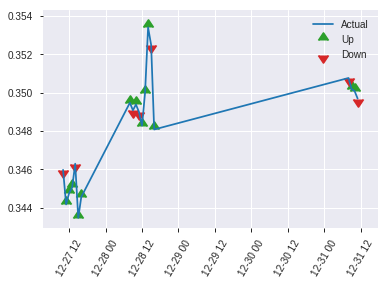


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19681738597726253
RMSE: 0.4436410553333207
LogLoss: 0.577248907656606
Mean Per-Class Error: 0.286401098901099
AUC: 0.7683419521654816
pr_auc: 0.702171237493495
Gini: 0.5366839043309632
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.415022816413919: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   51   0.4286   (51.0/119.0)
1      15   89   0.1442   (15.0/104.0)
Total  83   140  0.296    (66.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415023     0.729508  139
max f2                       0.190342     0.847315  179
max f0point5                 0.525458     0.686937  84
max accuracy                 0.432342     0.704036  133
max precision                0.977894     1         0
max recall                   0.0420954    1         217
max specificity              0.977894     1         0
max absolute_mcc             0.415023     0.440876  139
max min_per_class_accuracy   0.470505     0.680672  108
max mean_per_class_accuracy  0.415023     0.713599  139

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 45.13 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.946187           1.42949    1.42949            0.666667         0.961671   0.666667                    0.961671            0.0192308       0.0192308                  42.9487   42.9487
    2        0.0224215                   0.925904           2.14423    1.71538            1                0.938654   0.8                         0.952464            0.0192308       0.0384615                  114.423   71.5385
    3        0.0313901                   0.908779           2.14423    1.83791            1                0.91486    0.857143                    0.94172             0.0192308       0.0576923                  114.423   83.7912
    4        0.0403587                   0.894123           1.07212    1.66774            0.5              0.902355   0.777778                    0.932972            0.00961538      0.0673077                  7.21154   66.7735
    5        0.0538117                   0.855476           2.14423    1.78686            1                0.874567   0.833333                    0.918371            0.0288462       0.0961538                  114.423   78.6859
    6        0.103139                    0.784204           1.75437    1.77132            0.818182         0.818505   0.826087                    0.870609            0.0865385       0.182692                   75.4371   77.1321
    7        0.152466                    0.682182           1.55944    1.70277            0.727273         0.731404   0.794118                    0.825572            0.0769231       0.259615                   55.9441   70.2771
    8        0.201794                    0.628812           1.55944    1.66774            0.727273         0.64433    0.777778                    0.781268            0.0769231       0.336538                   55.9441   66.7735
    9        0.300448                    0.546104           1.26705    1.53617            0.590909         0.580768   0.716418                    0.715432            0.125           0.461538                   26.7045   53.6165
    10       0.399103                    0.515617           1.36451    1.49373            0.636364         0.534011   0.696629                    0.670587            0.134615        0.596154                   36.451    49.3734
    11       0.502242                    0.465193           1.11873    1.41672            0.521739         0.483595   0.660714                    0.632187            0.115385        0.711538                   11.8729   41.6724
    12       0.600897                    0.431506           1.16958    1.37615            0.545455         0.444748   0.641791                    0.601413            0.115385        0.826923                   16.958    37.6148
    13       0.699552                    0.361785           0.58479    1.26455            0.272727         0.395694   0.589744                    0.572401            0.0576923       0.884615                   -41.521   26.4546
    14       0.798206                    0.204259           0.77972    1.20462            0.363636         0.287668   0.561798                    0.53721             0.0769231       0.961538                   -22.028   20.4624
    15       0.896861                    0.110631           0.292395   1.10428            0.136364         0.159911   0.515                       0.495707            0.0288462       0.990385                   -70.7605  10.4279
    16       1                           0.0311884          0.0932274  1                  0.0434783        0.0650396  0.466368 

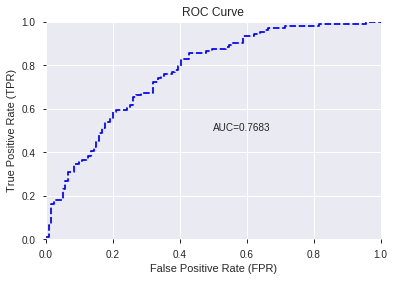

This function is available for GLM models only


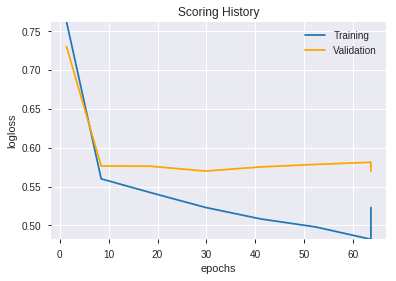

--2019-08-25 17:51:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


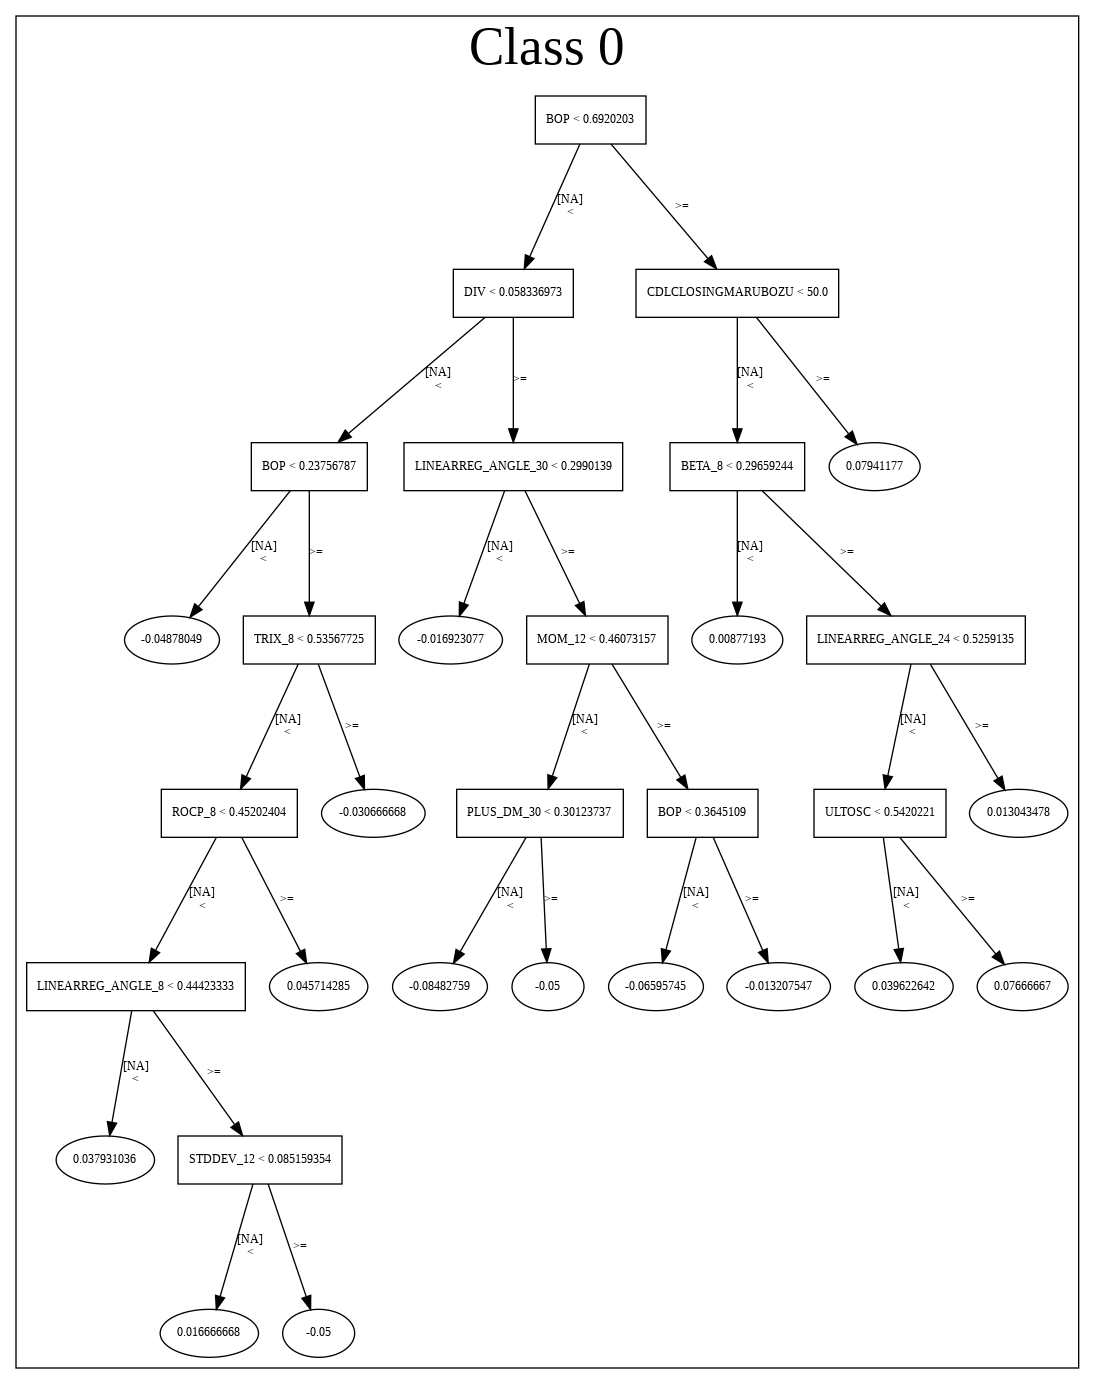

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_174311_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_174311_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a49b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'STOCHRSI_fastk',
 'hour',
 'SUB',
 'CDLBELTHOLD',
 'TRANGE',
 'SAREXT',
 'HT_TRENDMODE',
 'CORREL_20',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLSHOOTINGSTAR',
 'ULTOSC',
 'CDLMORNINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGSTAR',
 'CORREL_14',
 'CDLRISEFALL3METHODS',
 'CDLSTALLEDPATTERN',
 'days_in_month',
 'CDL3WHITESOLDIERS',
 'CDLEVENINGSTAR',
 'Volume',
 'CDLTHRUSTING',
 'CDLHAMMER',
 'CDLSTICKSANDWICH',
 'OBV',
 'CDLEVENINGDOJISTAR',
 'CDLPIERCING',
 'CDLHANGINGMAN',
 'CDLIDENTICAL3CROWS',
 'ADOSC',
 'day',
 'CDLONNECK',
 'CDLHIKKAKEMOD',
 'CDLGRAVESTONEDOJI',
 'CDLADVANCEBLOCK',
 'CDLINVERTEDHAMMER',
 'CDL3LINESTRIKE',
 'HT_DCPERIOD',
 'is_month_end',
 'CDLHARAMICROSS',
 'is_month_start',
 'CORREL_24',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLMATCHINGLOW']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_175159_model_1  0.750242  0.590467                0.2984  0.450343  0.202809

variable  relative_importance  scaled_importance  percentage
0                   SUB             0.897599           1.000000    0.144411
1                   BOP             0.806425           0.898424    0.129743
2                   DIV             0.333738           0.371812    0.053694
3                  hour             0.246587           0.274718    0.039672
4                SAREXT             0.239187           0.266474    0.038482
5    CDLCLOSINGMARUBOZU             0.187620           0.209024    0.030185
6             CDLHAMMER             0.186707           0.208007    0.030039
7                TRANGE             0.181693           0.202422    0.029232
8       CDLHOMINGPIGEON             0.177131           0.197338    0.028498
9                 ADOSC             0.160255           0.178537    0.025783
10       CDL3LINESTRIKE             0.154713           0.172363    0.024891
11     CDLSTICKSANDWICH             0.147874           0.164744    0.023791
12               ULTOSC             0.147733           0.164587    0.023768
13            CDLTAKURI             0.128104           0.142719    0.020610
14     CDLDRAGONFLYDOJI             0.118788           0.132339    0.019111
15      CDLADVANCEBLOCK             0.113644           0.126608    0.018284
16                  day             0.113095           0.125997    0.018195
17   CDLEVENINGDOJISTAR             0.112312           0.125125    0.018069
18    CDL3WHITESOLDIERS             0.110304           0.122887    0.017746
19   CDLIDENTICAL3CROWS             0.104896           0.116863    0.016876
20          HT_DCPERIOD             0.093331           0.103979    0.015016
21          CDLPIERCING             0.092648           0.103218    0.014906
22        CDLHIKKAKEMOD             0.091501           0.101940    0.014721
23  CDLRISEFALL3METHODS             0.091156           0.101555    0.014666
24            CDLONNECK             0.090052           0.100325    0.014488
25         CDLTHRUSTING             0.088556           0.098659    0.014247
26        CDLHANGINGMAN             0.086885           0.096797    0.013979
27       CDLEVENINGSTAR             0.085251           0.094977    0.013716
28            CORREL_20             0.081433           0.090723    0.013101
29    CDLGRAVESTONEDOJI             0.081286           0.090559    0.013078
30          CDLLONGLINE             0.071736           0.079919    0.011541
31               Volume             0.063625           0.070883    0.010236
32  CDLGAPSIDESIDEWHITE             0.058120           0.064751    0.009351
33            CORREL_14             0.051935           0.057860    0.008356
34            CORREL_24             0.046966           0.052324    0.007556
35    CDLINVERTEDHAMMER             0.044162           0.049200    0.007105
36       is_month_start             0.041686           0.046442    0.006707
37      CDLSHOOTINGSTAR             0.040703           0.045347    0.006549
38       CDLMATCHINGLOW             0.038359           0.042736    0.006171
39    CDLDARKCLOUDCOVER             0.037549           0.041833    0.006041
40       STOCHRSI_fastk             0.034782           0.038750    0.005596
41       CDLMORNINGSTAR             0.033992           0.037870    0.005469
42       CDLHARAMICROSS             0.021364           0.023801    0.003437
43   CDLMORNINGDOJISTAR             0.019231           0.021424    0.003094
44                  OBV             0.017820           0.019853    0.002867
45         HT_TRENDMODE             0.014732           0.016413    0.002370
46          CDLBELTHOLD             0.011482           0.012792    0.001847
47        days_in_month             0.008080           0.009002    0.001300
48    CDLSTALLEDPATTERN             0.005440           0.006061    0.000875
49         is_month_end             0.003307           0.003684    0.000532

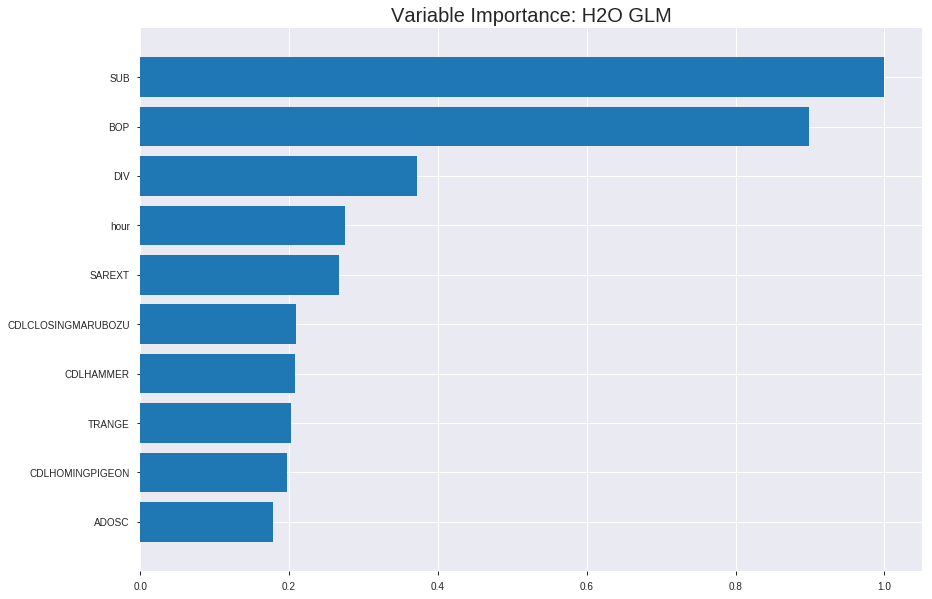

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_175159_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18781303811713282
RMSE: 0.4333740164305341
LogLoss: 0.5559020387481539
Null degrees of freedom: 1556
Residual degrees of freedom: 1506
Null deviance: 2146.7404074571314
Residual deviance: 1731.0789486617514
AIC: 1833.0789486617514
AUC: 0.7859497660871213
pr_auc: 0.7361906380688417
Gini: 0.5718995321742426
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3699606081763006: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      500  346  0.409    (346.0/846.0)
1      119  592  0.1674   (119.0/711.0)
Total  619  938  0.2987   (465.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369961     0.718011  240
max f2                       0.22825      0.828018  310
max f0point5                 0.537326     0.705434  164
max accuracy                 0.537326     0.722543  164
max precision                0.996587     1         0
max recall                   0.0478273    1         390
max specificity              0.996587     1         0
max absolute_mcc             0.537326     0.438336  164
max min_per_class_accuracy   0.462087     0.708038  196
max mean_per_class_accuracy  0.409185     0.715579  221

Gains/Lift Table: Avg response rate: 45.66 %, avg score: 45.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.92388            2.05301   2.05301            0.9375           0.969879   0.9375                      0.969879            0.021097        0.021097                   105.301   105.301
    2        0.0205523                   0.898286           2.18987   2.12144            1                0.911519   0.96875                     0.940699            0.0225035       0.0436006                  118.987   112.144
    3        0.0301863                   0.879563           1.89789   2.05009            0.866667         0.889299   0.93617                     0.924295            0.0182841       0.0618847                  89.789    105.009
    4        0.0404624                   0.854159           1.64241   1.94655            0.75             0.86525    0.888889                    0.909299            0.0168776       0.0787623                  64.2405   94.6554
    5        0.0500963                   0.839841           1.31392   1.82489            0.6              0.844126   0.833333                    0.896766            0.0126582       0.0914205                  31.3924   82.4895
    6        0.100193                    0.788523           1.74067   1.78278            0.794872         0.812981   0.814103                    0.854874            0.0872011       0.178622                   74.0669   78.2782
    7        0.150289                    0.741883           1.74067   1.76874            0.794872         0.763996   0.807692                    0.824581            0.0872011       0.265823                   74.0669   76.8744
    8        0.200385                    0.694793           1.65644   1.74067            0.75641          0.719067   0.794872                    0.798202            0.0829817       0.348805                   65.6443   74.0669
    9        0.299936                    0.611752           1.45521   1.64592            0.664516         0.650794   0.751606                    0.749277            0.144866        0.493671                   45.5206   64.5922
    10       0.400128                    0.525765           1.36165   1.57474            0.621795         0.571773   0.719101                    0.70483             0.136428        0.630098                   36.1652   57.474
    11       0.500321                    0.447386           0.982636  1.45617            0.448718         0.485388   0.664955                    0.660885            0.0984529       0.728551                   -1.73645  45.6167
    12       0.599872                    0.370737           1.01723   1.38332            0.464516         0.408488   0.631692                    0.618999            0.101266        0.829817                   1.72315   38.3325
    13       0.700064                    0.304427           0.673807  1.28178            0.307692         0.335455   0.585321                    0.578418            0.0675105       0.897328                   -32.6193  28.1779
    14       0.799615                    0.219542           0.536872  1.18904            0.245161         0.261196   0.542972                    0.538925            0.0534459       0.950774                   -46.3128  18.904
    15       0.899807                    0.128261           0.336904  1.09416            0.153846         0.174387   0.499643                    0.498334            0.0337553       0.984529                   -66.3096  9.41552
    16       1                           1.48334e-05        0.154414  1                  0.0705128        0.0822699  0.456647                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20090484266155903
RMSE: 0.44822409870684
LogLoss: 0.5825214908807007
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 611.0451593654886
Residual deviance: 518.4441268838236
AIC: 620.4441268838236
AUC: 0.7506249487746905
pr_auc: 0.6781204866575651
Gini: 0.5012498975493811
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3266042148029918: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      128  121  0.4859   (121.0/249.0)
1      28   168  0.1429   (28.0/196.0)
Total  156  289  0.3348   (149.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.326604     0.692784  257
max f2                       0.175267     0.8283    336
max f0point5                 0.41669      0.644876  212
max accuracy                 0.41669      0.689888  212
max precision                0.995466     1         0
max recall                   0.0648494    1         386
max specificity              0.995466     1         0
max absolute_mcc             0.41669      0.389218  212
max min_per_class_accuracy   0.449191     0.668367  193
max mean_per_class_accuracy  0.41669      0.695742  212

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 44.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.913895           1.81633   1.81633            0.8              0.965718   0.8                         0.965718            0.0204082       0.0204082                  81.6327   81.6327
    2        0.0202247                   0.903041           1.70281   1.76587            0.75             0.908307   0.777778                    0.940202            0.0153061       0.0357143                  70.2806   76.5873
    3        0.0314607                   0.86883            2.27041   1.94606            1                0.889168   0.857143                    0.921975            0.0255102       0.0612245                  127.041   94.6064
    4        0.0404494                   0.846708           1.70281   1.89201            0.75             0.857319   0.833333                    0.907607            0.0153061       0.0765306                  70.2806   89.2007
    5        0.0516854                   0.840409           2.27041   1.97427            1                0.844165   0.869565                    0.893815            0.0255102       0.102041                   127.041   97.4268
    6        0.101124                    0.777688           1.54801   1.76587            0.681818         0.804735   0.777778                    0.850265            0.0765306       0.178571                   54.8006   76.5873
    7        0.150562                    0.719973           1.85761   1.79599            0.818182         0.755628   0.791045                    0.81919             0.0918367       0.270408                   85.7607   79.5995
    8        0.2                         0.675859           1.1352    1.63265            0.5              0.696674   0.719101                    0.788905            0.0561224       0.326531                   13.5204   63.2653
    9        0.301124                    0.588497           1.4127    1.55879            0.622222         0.631186   0.686567                    0.73594             0.142857        0.469388                   41.2698   55.8788
    10       0.4                         0.50662            1.0836    1.44133            0.477273         0.546016   0.634831                    0.688992            0.107143        0.576531                   8.36039   44.1327
    11       0.501124                    0.437088           1.26134   1.40501            0.555556         0.470605   0.618834                    0.644923            0.127551        0.704082                   26.1338   40.5006
    12       0.6                         0.347941           0.928803  1.32653            0.409091         0.392629   0.58427                     0.603347            0.0918367       0.795918                   -7.11967  32.6531
    13       0.698876                    0.283249           0.825603  1.25566            0.363636         0.32232    0.553055                    0.563587            0.0816327       0.877551                   -17.4397  25.566
    14       0.8                         0.217458           0.554989  1.16709            0.244444         0.248937   0.514045                    0.523814            0.0561224       0.933673                   -44.5011  16.7092
    15       0.898876                    0.125414           0.567602  1.10115            0.25             0.170762   0.485                       0.484978            0.0561224       0.989796                   -43.2398  10.1148
    16       1                           0.00663298         0.100907  1                  0.0444444        0.0741806  0.440449                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-25 17:51:59  0.000 sec   2            .2E2      50            1.3646787817076373  1.3600633902756878
     2019-08-25 17:51:59  0.007 sec   4            .12E2     50            1.3568654625831136  1.352833394508514
     2019-08-25 17:51:59  0.012 sec   6            .76E1     51            1.3453683588969148  1.3422232015599118
     2019-08-25 17:51:59  0.017 sec   8            .47E1     51            1.3291892788030952  1.3273622356542893
     2019-08-25 17:51:59  0.023 sec   10           .29E1     51            1.307880676425768   1.3079317547399738
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-25 17:51:59  0.106 sec   42           .14E-2    51            1.110300776366744   1.1650853278712723
     2019-08-25 17:51:59  0.111 sec   44           .9E-3     51            1.1089997571572259  1.16581021488383
     2019-08-25 17:51:59  0.117 sec   46           .56E-3    51            1.1080510728831623  1.167300974899849
     2019-08-25 17:51:59  0.122 sec   48           .35E-3    51            1.1074647988713384  1.1693211266978476
     2019-08-25 17:51:59  0.125 sec   49           .21E-3    51            1.1071414530410661  1.1713218679124249


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7085201793721974)

('F1', 0.7228915662650602)

('auc', 0.7502424046541695)

('logloss', 0.5904674954176852)

('mean_per_class_error', 0.2858354880413704)

('rmse', 0.4503427245989841)

('mse', 0.20280856959923643)

glm prediction progress: |████████████████████████████████████████████████| 100%


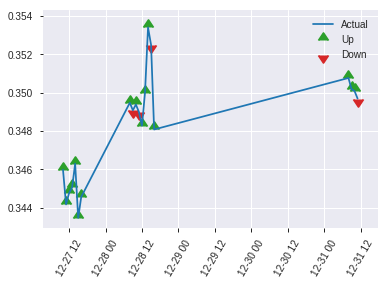


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20280856959923643
RMSE: 0.4503427245989841
LogLoss: 0.5904674954176852
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 308.21873965260795
Residual deviance: 263.3485029562876
AIC: 365.3485029562876
AUC: 0.7502424046541695
pr_auc: 0.6542026963411305
Gini: 0.5004848093083389
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37125979447597296: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   55   0.4622   (55.0/119.0)
1      14   90   0.1346   (14.0/104.0)
Total  78   145  0.3094   (69.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37126      0.722892  144
max f2                       0.269613     0.854271  180
max f0point5                 0.435829     0.678105  126
max accuracy                 0.435829     0.70852   126
max precision                0.991605     1         0
max recall                   0.113594     1         213
max specificity              0.991605     1         0
max absolute_mcc             0.435829     0.431549  126
max min_per_class_accuracy   0.519787     0.672269  108
max mean_per_class_accuracy  0.435829     0.714165  126

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 49.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.891679           1.42949    1.42949            0.666667         0.926636  0.666667                    0.926636            0.0192308       0.0192308                  42.9487   42.9487
    2        0.0224215                   0.880597           1.07212    1.28654            0.5              0.884057  0.6                         0.909604            0.00961538      0.0288462                  7.21154   28.6538
    3        0.0313901                   0.872516           1.07212    1.22527            0.5              0.876573  0.571429                    0.900167            0.00961538      0.0384615                  7.21154   22.5275
    4        0.0403587                   0.868999           1.07212    1.19124            0.5              0.871709  0.555556                    0.893843            0.00961538      0.0480769                  7.21154   19.1239
    5        0.0538117                   0.859589           1.42949    1.2508             0.666667         0.864893  0.583333                    0.886605            0.0192308       0.0673077                  42.9487   25.0801
    6        0.103139                    0.821444           1.75437    1.49164            0.818182         0.841494  0.695652                    0.86503             0.0865385       0.153846                   75.4371   49.1639
    7        0.152466                    0.775426           1.75437    1.57664            0.818182         0.791968  0.735294                    0.841392            0.0865385       0.240385                   75.4371   57.664
    8        0.201794                    0.736593           1.55944    1.57244            0.727273         0.758301  0.733333                    0.821081            0.0769231       0.317308                   55.9441   57.2436
    9        0.300448                    0.656507           1.26705    1.47216            0.590909         0.684855  0.686567                    0.77635             0.125           0.442308                   26.7045   47.2158
    10       0.399103                    0.60322            1.36451    1.44555            0.636364         0.629668  0.674157                    0.740092            0.134615        0.576923                   36.451    44.5549
    11       0.502242                    0.494277           1.0255     1.35929            0.478261         0.549717  0.633929                    0.700997            0.105769        0.682692                   2.55017   35.9289
    12       0.600897                    0.403101           1.26705    1.34414            0.590909         0.448906  0.626866                    0.659609            0.125           0.807692                   26.7045   34.4145
    13       0.699552                    0.345433           0.77972    1.26455            0.363636         0.370132  0.589744                    0.618785            0.0769231       0.884615                   -22.028   26.4546
    14       0.798206                    0.283098           0.682255   1.19258            0.318182         0.315392  0.55618                     0.581287            0.0673077       0.951923                   -31.7745  19.2578
    15       0.896861                    0.165288           0.38986    1.10428            0.181818         0.220391  0.515                       0.541588            0.0384615       0.990385                   -61.014   10.4279
    16       1                           0.0442794          0.0932274  1                  0.0434783        0.10945   0.466368                    

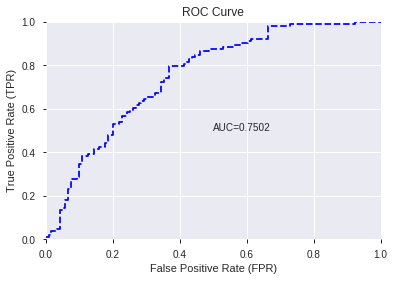

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


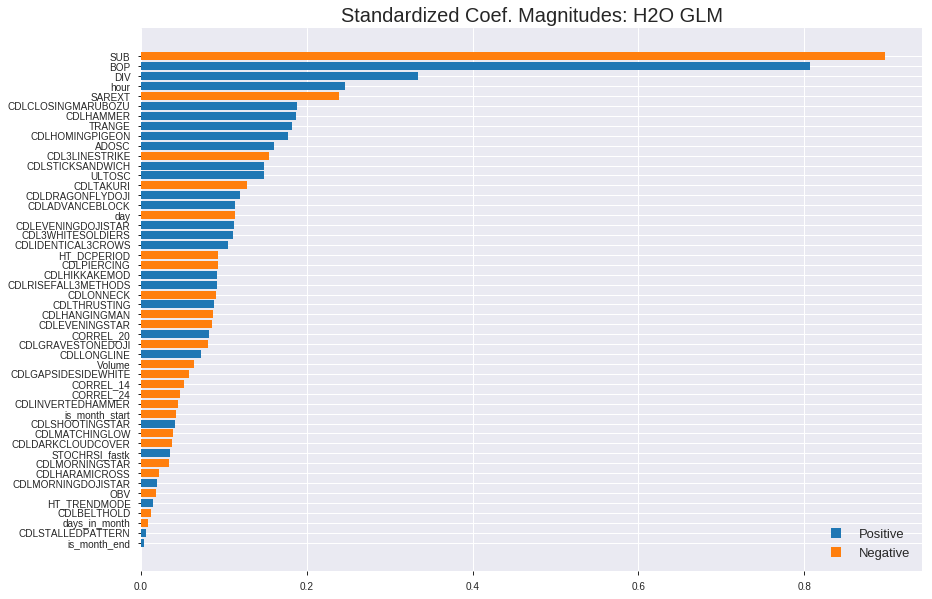

'log_likelihood'
--2019-08-25 17:52:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


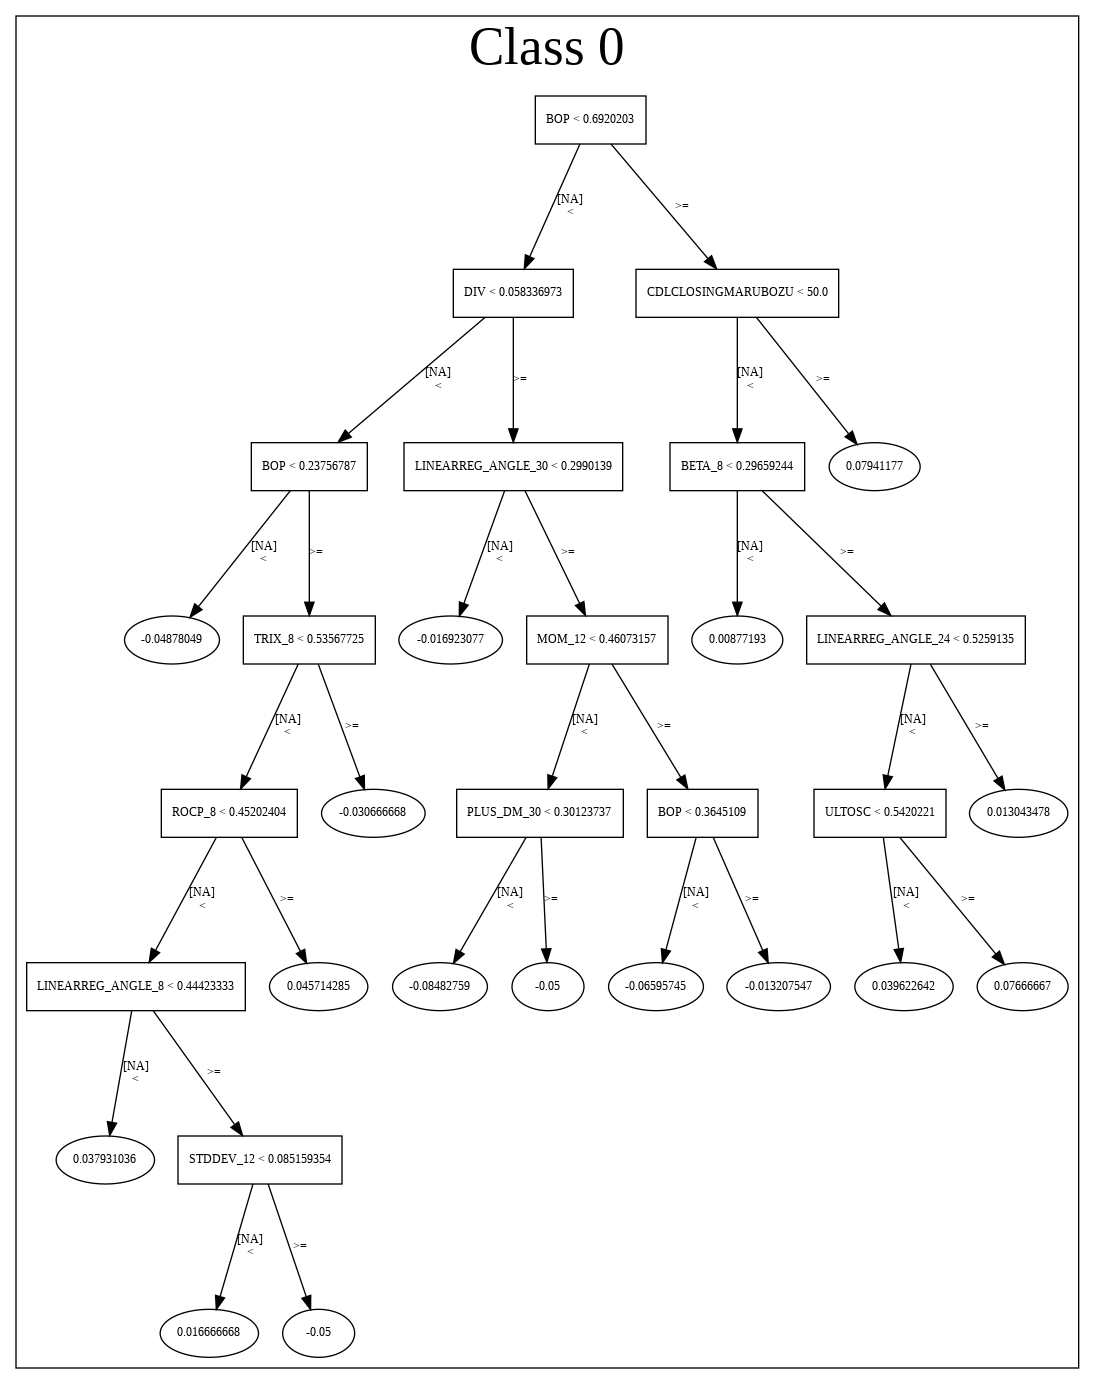

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_175159_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_175159_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a49b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['SUB',
 'BOP',
 'DIV',
 'hour',
 'SAREXT',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'TRANGE',
 'CDLHOMINGPIGEON',
 'ADOSC',
 'CDL3LINESTRIKE',
 'CDLSTICKSANDWICH',
 'ULTOSC',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLADVANCEBLOCK',
 'day',
 'CDLEVENINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CDLIDENTICAL3CROWS',
 'HT_DCPERIOD',
 'CDLPIERCING',
 'CDLHIKKAKEMOD',
 'CDLRISEFALL3METHODS',
 'CDLONNECK',
 'CDLTHRUSTING',
 'CDLHANGINGMAN',
 'CDLEVENINGSTAR',
 'CORREL_20',
 'CDLGRAVESTONEDOJI',
 'CDLLONGLINE',
 'Volume',
 'CDLGAPSIDESIDEWHITE',
 'CORREL_14',
 'CORREL_24',
 'CDLINVERTEDHAMMER',
 'is_month_start',
 'CDLSHOOTINGSTAR',
 'CDLMATCHINGLOW',
 'CDLDARKCLOUDCOVER',
 'STOCHRSI_fastk',
 'CDLMORNINGSTAR',
 'CDLHARAMICROSS',
 'CDLMORNINGDOJISTAR',
 'OBV',
 'HT_TRENDMODE',
 'CDLBELTHOLD',
 'days_in_month',
 'CDLSTALLEDPATTERN',
 'is_month_end']

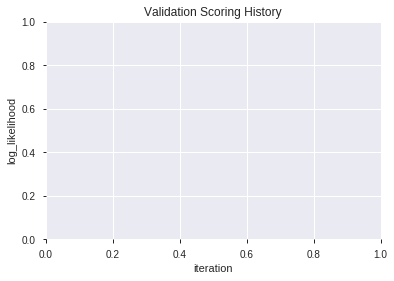

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_175210_model_2  0.785795  0.578825              0.254000  0.441909  0.195284
1  XGBoost_grid_1_AutoML_20190825_175210_model_3  0.783775  0.564709              0.292380  0.436418  0.190461
2  XGBoost_grid_1_AutoML_20190825_175210_model_1  0.783048  0.558829              0.257636  0.434758  0.189015
3               XGBoost_3_AutoML_20190825_175210  0.782321  0.560262              0.264181  0.434717  0.188978
4  XGBoost_grid_1_AutoML_20190825_175210_model_6  0.778281  0.577459              0.261797  0.440652  0.194174
5               XGBoost_1_AutoML_20190825_175210  0.770120  0.574984              0.270806  0.441981  0.195347
6  XGBoost_grid_1_AutoML_20190825_175210_model_7  0.769069  0.575571              0.261797  0.441196  0.194654
7               XGBoost_2_AutoML_20190825_175210  0.767857  0.570827              0.251616  0.440164  0.193744
8  XGBoost_grid_1_AutoML_20190825_175210_model_4  0.761797  0.580425              0.273796  0.444251  0.197359
9  XGBoost_grid_1_AutoML_20190825_175210_model_5  0.753636  0.597637              0.294198  0.451371  0.203736

variable  relative_importance  scaled_importance  percentage
0                  BOP          2442.983887           1.000000    0.313265
1                  SUB           509.788818           0.208675    0.065370
2                  DIV           482.472504           0.197493    0.061868
3               SAREXT           445.012482           0.182159    0.057064
4                 hour           400.252106           0.163837    0.051325
5               Volume           347.593994           0.142283    0.044572
6               TRANGE           332.045929           0.135918    0.042578
7                  OBV           330.735107           0.135382    0.042410
8            CORREL_20           310.349792           0.127037    0.039796
9                ADOSC           302.011505           0.123624    0.038727
10              ULTOSC           277.874695           0.113744    0.035632
11           CORREL_24           268.525604           0.109917    0.034433
12         HT_DCPERIOD           222.570282           0.091106    0.028540
13                 day           206.900497           0.084692    0.026531
14           CORREL_14           196.614212           0.080481    0.025212
15      STOCHRSI_fastk           195.350082           0.079964    0.025050
16  CDLCLOSINGMARUBOZU           142.786026           0.058447    0.018310
17           CDLHAMMER           102.591980           0.041995    0.013155
18   CDLGRAVESTONEDOJI            81.932205           0.033538    0.010506
19     CDLADVANCEBLOCK            71.349823           0.029206    0.009149
20         CDLLONGLINE            38.184761           0.015630    0.004896
21         CDLBELTHOLD            21.303329           0.008720    0.002732
22       days_in_month            13.818853           0.005657    0.001772
23        HT_TRENDMODE             9.616415           0.003936    0.001233
24        is_month_end             7.566429           0.003097    0.000970
25    CDLDRAGONFLYDOJI             7.510537           0.003074    0.000963
26      CDLMATCHINGLOW             6.734641           0.002757    0.000864
27      CDLEVENINGSTAR             6.125645           0.002507    0.000785
28       CDLHANGINGMAN             4.962595           0.002031    0.000636
29      CDLHARAMICROSS             4.611661           0.001888    0.000591
30    CDLSTICKSANDWICH             4.005905           0.001640    0.000514
31        CDLTHRUSTING             2.900805           0.001187    0.000372
32   CDLSTALLEDPATTERN             0.929313           0.000380    0.000119
33      is_month_start             0.443590           0.000182    0.000057

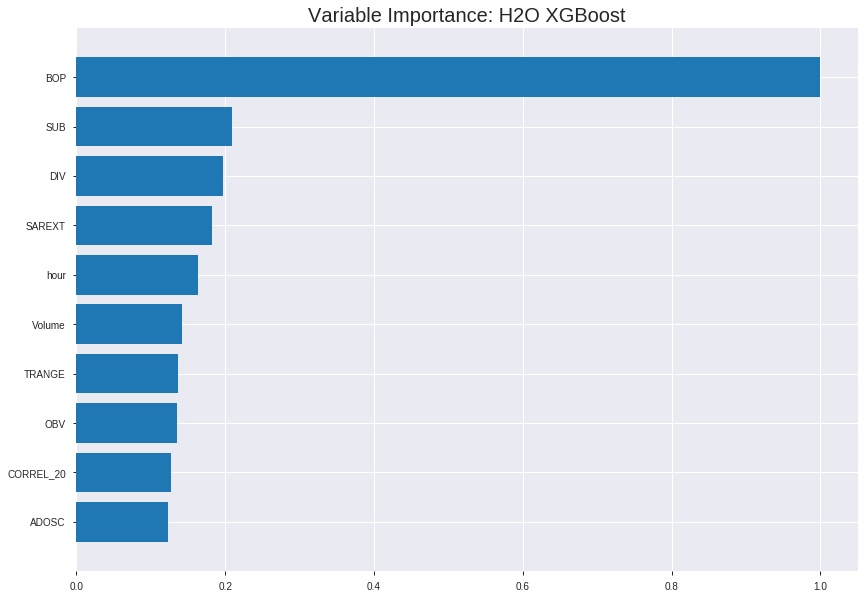

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_175210_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15037095358213026
RMSE: 0.38777693791937945
LogLoss: 0.47042619465540525
Mean Per-Class Error: 0.19790076906963527
AUC: 0.8829629297130869
pr_auc: 0.867374597470788
Gini: 0.7659258594261737
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5080571174621582: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      689  157  0.1856   (157.0/846.0)
1      150  561  0.211    (150.0/711.0)
Total  839  718  0.1972   (307.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.508057     0.785164  185
max f2                       0.257868     0.862069  297
max f0point5                 0.586262     0.803602  145
max accuracy                 0.530418     0.806037  173
max precision                0.869456     1         0
max recall                   0.123885     1         374
max specificity              0.869456     1         0
max absolute_mcc             0.530418     0.608193  173
max min_per_class_accuracy   0.500437     0.796062  189
max mean_per_class_accuracy  0.530418     0.802099  173

Gains/Lift Table: Avg response rate: 45.66 %, avg score: 45.74 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102762                   0.840969           2.18987    2.18987            1                0.855175  1                           0.855175            0.0225035       0.0225035                  118.987    118.987
    2        0.0205523                   0.824585           2.18987    2.18987            1                0.831621  1                           0.843398            0.0225035       0.045007                   118.987    118.987
    3        0.0301863                   0.814181           2.18987    2.18987            1                0.819119  1                           0.83565             0.021097        0.0661041                  118.987    118.987
    4        0.0404624                   0.801934           2.05301    2.15511            0.9375           0.808115  0.984127                    0.828657            0.021097        0.0872011                  105.301    115.511
    5        0.0500963                   0.79639            2.18987    2.1618             1                0.799079  0.987179                    0.822969            0.021097        0.108298                   118.987    116.18
    6        0.100193                    0.756875           2.10565    2.13372            0.961538         0.776756  0.974359                    0.799862            0.105485        0.213783                   110.565    113.372
    7        0.150289                    0.723196           1.99335    2.08693            0.910256         0.739775  0.952991                    0.779833            0.0998594       0.313643                   99.3346    108.693
    8        0.200385                    0.692606           1.90912    2.04248            0.871795         0.708756  0.932692                    0.762064            0.0956399       0.409283                   90.912     104.248
    9        0.299936                    0.628854           1.68126    1.92259            0.767742         0.659491  0.877944                    0.728019            0.16737         0.576653                   68.1258    92.2587
    10       0.400128                    0.548868           1.4178     1.79619            0.647436         0.589741  0.820225                    0.693394            0.142053        0.718706                   41.7803    79.6188
    11       0.500321                    0.478202           0.996673   1.63608            0.455128         0.514504  0.747112                    0.65757             0.0998594       0.818565                   -0.332684  63.608
    12       0.599872                    0.386612           0.762924   1.49118            0.348387         0.433455  0.680942                    0.620378            0.0759494       0.894515                   -23.7076   49.1177
    13       0.700064                    0.27906            0.547468   1.35611            0.25             0.330779  0.619266                    0.578931            0.0548523       0.949367                   -45.2532   35.6114
    14       0.799615                    0.203131           0.367334   1.23301            0.167742         0.238141  0.563052                    0.536503            0.0365682       0.985935                   -63.2666   23.3013
    15       0.899807                    0.138937           0.112301   1.10822            0.0512821        0.171265  0.506067                    0.495834            0.0112518       0.997187                   -88.7699   10.8223
    16       1                           0.0787901          0.0280753  1                  0.0128205        0.112118  0.456647    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1974839184057765
RMSE: 0.4443916272903626
LogLoss: 0.578504734818885
Mean Per-Class Error: 0.2953548889435291
AUC: 0.762498975493812
pr_auc: 0.691440662484205
Gini: 0.5249979509876239
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39031079411506653: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      154  95   0.3815   (95.0/249.0)
1      41   155  0.2092   (41.0/196.0)
Total  195  250  0.3056   (136.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390311     0.695067  224
max f2                       0.18543      0.820643  357
max f0point5                 0.631744     0.660828  97
max accuracy                 0.439317     0.696629  201
max precision                0.843804     1         0
max recall                   0.125457     1         390
max specificity              0.843804     1         0
max absolute_mcc             0.390311     0.409517  224
max min_per_class_accuracy   0.463428     0.688776  188
max mean_per_class_accuracy  0.390311     0.704645  224

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 45.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.814491           1.36224   1.36224            0.6              0.828414  0.6                         0.828414            0.0153061       0.0153061                  36.2245   36.2245
    2        0.0202247                   0.800473           2.27041   1.76587            1                0.80686   0.777778                    0.818835            0.0204082       0.0357143                  127.041   76.5873
    3        0.0314607                   0.790352           1.81633   1.78389            0.8              0.79685   0.785714                    0.810983            0.0204082       0.0561224                  81.6327   78.3892
    4        0.0404494                   0.782609           2.27041   1.89201            1                0.785823  0.833333                    0.805392            0.0204082       0.0765306                  127.041   89.2007
    5        0.0516854                   0.773643           1.81633   1.87555            0.8              0.779303  0.826087                    0.79972             0.0204082       0.0969388                  81.6327   87.5555
    6        0.101124                    0.722257           2.06401   1.96769            0.909091         0.747233  0.866667                    0.77406             0.102041        0.19898                    106.401   96.7687
    7        0.150562                    0.690993           1.3416    1.76211            0.590909         0.704566  0.776119                    0.751241            0.0663265       0.265306                   34.1605   76.2108
    8        0.2                         0.658927           1.75441   1.7602             0.772727         0.678815  0.775281                    0.733338            0.0867347       0.352041                   75.4406   76.0204
    9        0.301124                    0.599735           1.26134   1.59267            0.555556         0.627754  0.701493                    0.697881            0.127551        0.479592                   26.1338   59.2674
    10       0.4                         0.512998           1.1352    1.47959            0.5              0.551166  0.651685                    0.661614            0.112245        0.591837                   13.5204   47.9592
    11       0.501124                    0.444308           1.26134   1.43555            0.555556         0.477065  0.632287                    0.624373            0.127551        0.719388                   26.1338   43.555
    12       0.6                         0.372125           0.928803  1.35204            0.409091         0.403253  0.595506                    0.587934            0.0918367       0.811224                   -7.11967  35.2041
    13       0.698876                    0.314737           0.774003  1.27026            0.340909         0.339599  0.559486                    0.5528              0.0765306       0.887755                   -22.5997  27.0261
    14       0.8                         0.255172           0.554989  1.17985            0.244444         0.288052  0.519663                    0.519334            0.0561224       0.943878                   -44.5011  17.9847
    15       0.898876                    0.183302           0.464402  1.10115            0.204545         0.216762  0.485                       0.486051            0.0459184       0.989796                   -53.5598  10.1148
    16       1                           0.102187           0.100907  1                  0.0444444        0.15067   0.440449                    0.452136          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:52:14  0.678 sec   0                  0.5              0.693147            0.5             0                  1                0.543353                         0.5                0.693147              0.5               0                    1                  0.559551
    2019-08-25 17:52:14  0.738 sec   5                  0.476502         0.647038            0.815196        0.679429           1.85096          0.268465                         0.486906           0.667228              0.740493          0.604432             1.70281            0.323596
    2019-08-25 17:52:14  0.782 sec   10                 0.458714         0.612798            0.828422        0.786077           2.13513          0.260116                         0.476166           0.646169              0.749221          0.668821             2.27041            0.32809
    2019-08-25 17:52:14  0.829 sec   15                 0.444779         0.585974            0.83401         0.800365           2.05301          0.254978                         0.467079           0.62832               0.757561          0.684969             1.76587            0.341573
    2019-08-25 17:52:14  0.877 sec   20                 0.434547         0.565939            0.839007        0.806837           2.18987          0.240206                         0.460025           0.614294              0.760245          0.69365              1.81633            0.298876
    2019-08-25 17:52:14  0.932 sec   25                 0.426591         0.550046            0.84485         0.81883            2.06821          0.250482                         0.455087           0.604214              0.762345          0.690155             1.36224            0.292135
    2019-08-25 17:52:14  0.994 sec   30                 0.419678         0.536233            0.851562        0.825714           2.05301          0.242132                         0.452531           0.59865               0.761259          0.687789             1.36224            0.301124
    2019-08-25 17:52:14  1.048 sec   35                 0.414076         0.524706            0.854421        0.83015            2.05301          0.232498                         0.450639           0.594328              0.761013          0.688016             1.81633            0.301124
    2019-08-25 17:52:14  1.100 sec   40                 0.409093         0.514529            0.859831        0.83977            2.18987          0.231856                         0.448822           0.590192              0.760891          0.691289             2.27041            0.294382
    2019-08-25 17:52:14  1.153 sec   45                 0.404783         0.505547            0.864034        0.844479           2.18987          0.225434                         0.447739           0.587396              0.760583          0.69135              2.27041            0.31236
    2019-08-25 17:52:14  1.216 sec   50                 0.40079          0.497246            0.868675        0.850407           2.18987          0.22158                          0.447265           0.585925              0.759907          0.692262             2.27041            0.31236
    2019-08-25 17:52:14  1.275 sec   55                 0.397123         0.489763            0.873143        0.854268           2.18987          0.208092                         0.447062           0.584939              0.759087          0.69

Variable Importances: 


variable           relative_importance    scaled_importance       percentage
-----------------  ---------------------  ----------------------  ----------------------
BOP                2442.98388671875       1.0                     0.31326507241114016
SUB                509.788818359375       0.20867465443830197     0.0653704807329843
DIV                482.4725036621094      0.19749311744750542     0.061867695737894586
SAREXT             445.0124816894531      0.1821594010950124      0.05706417797439898
hour               400.2521057128906      0.1638373907780792      0.05132453208574724
---                ---                    ---                     ---
CDLHARAMICROSS     4.611660957336426      0.00188771648573192     0.0005913556415945129
CDLSTICKSANDWICH   4.0059051513671875     0.0016397591376452537   0.0005136792649912691
CDLTHRUSTING       2.9008045196533203     0.0011874022319277283   0.0003719716461659892
CDLSTALLEDPATTERN  0.9293127059936523     0.0003804006694623934   0.00011916624326438286
is_month_start     0.443589985370636      0.00018157712287101326  5.688177054439446e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7488789237668162)

('F1', 0.75)

('auc', 0.7857950872656755)

('logloss', 0.5788246788450573)

('mean_per_class_error', 0.24983839689722043)

('rmse', 0.4419091918923719)

('mse', 0.19528373387896916)

xgboost prediction progress: |████████████████████████████████████████████| 100%


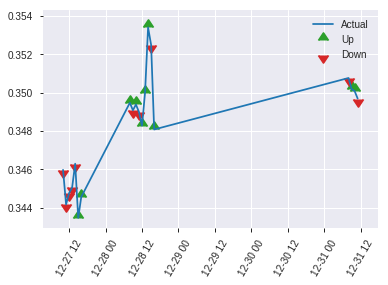


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19528373387896916
RMSE: 0.4419091918923719
LogLoss: 0.5788246788450573
Mean Per-Class Error: 0.24983839689722043
AUC: 0.7857950872656755
pr_auc: 0.6880160577503284
Gini: 0.571590174531351
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4567759335041046: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      78   41   0.3445   (41.0/119.0)
1      17   87   0.1635   (17.0/104.0)
Total  95   128  0.2601   (58.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456776     0.75      127
max f2                       0.297431     0.847176  185
max f0point5                 0.536833     0.737705  95
max accuracy                 0.536833     0.748879  95
max precision                0.771638     0.8       14
max recall                   0.244023     1         203
max specificity              0.836806     0.991597  0
max absolute_mcc             0.493663     0.499195  111
max min_per_class_accuracy   0.500168     0.739496  107
max mean_per_class_accuracy  0.493663     0.750162  111

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 49.38 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.809125           0.714744   0.714744           0.333333         0.822414  0.333333                    0.822414            0.00961538      0.00961538                 -28.5256  -28.5256
    2        0.0224215                   0.790831           2.14423    1.28654            1                0.796706  0.6                         0.812131            0.0192308       0.0288462                  114.423   28.6538
    3        0.0313901                   0.783181           2.14423    1.53159            1                0.787933  0.714286                    0.805217            0.0192308       0.0480769                  114.423   53.1593
    4        0.0403587                   0.778925           2.14423    1.66774            1                0.781266  0.777778                    0.799895            0.0192308       0.0673077                  114.423   66.7735
    5        0.0538117                   0.773655           1.42949    1.60817            0.666667         0.776516  0.75                        0.79405             0.0192308       0.0865385                  42.9487   60.8173
    6        0.103139                    0.733992           1.36451    1.49164            0.636364         0.758759  0.695652                    0.777172            0.0673077       0.153846                   36.451    49.1639
    7        0.152466                    0.698302           1.36451    1.45051            0.636364         0.719283  0.676471                    0.758443            0.0673077       0.221154                   36.451    45.0509
    8        0.201794                    0.664614           1.55944    1.47714            0.727273         0.687399  0.688889                    0.741077            0.0769231       0.298077                   55.9441   47.7137
    9        0.300448                    0.599939           1.85184    1.60017            0.863636         0.636789  0.746269                    0.706833            0.182692        0.480769                   85.1836   60.0172
    10       0.399103                    0.548611           1.55944    1.5901             0.727273         0.576476  0.741573                    0.67461             0.153846        0.634615                   55.9441   59.0104
    11       0.502242                    0.493663           1.30518    1.53159            0.608696         0.523324  0.714286                    0.643542            0.134615        0.769231                   30.5184   53.1593
    12       0.600897                    0.433501           0.77972    1.40815            0.363636         0.465738  0.656716                    0.614351            0.0769231       0.846154                   -22.028   40.8152
    13       0.699552                    0.366708           0.58479    1.29204            0.272727         0.396961  0.602564                    0.583693            0.0576923       0.903846                   -41.521   29.2036
    14       0.798206                    0.313676           0.58479    1.20462            0.272727         0.341084  0.561798                    0.553708            0.0576923       0.961538                   -41.521   20.4624
    15       0.896861                    0.252277           0.292395   1.10428            0.136364         0.28586   0.515                       0.524244            0.0288462       0.990385                   -70.7605  10.4279
    16       1                           0.200956           0.0932274  1                  0.0434783        0.228858  0.466368                  

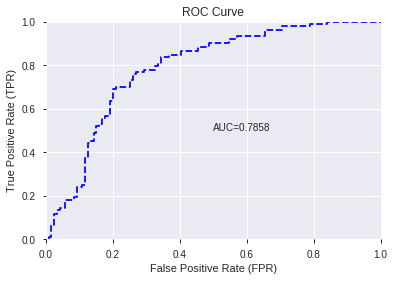

This function is available for GLM models only


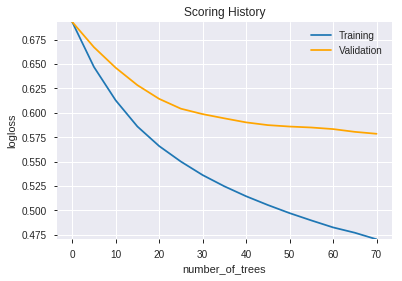

--2019-08-25 17:52:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.237.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.237.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

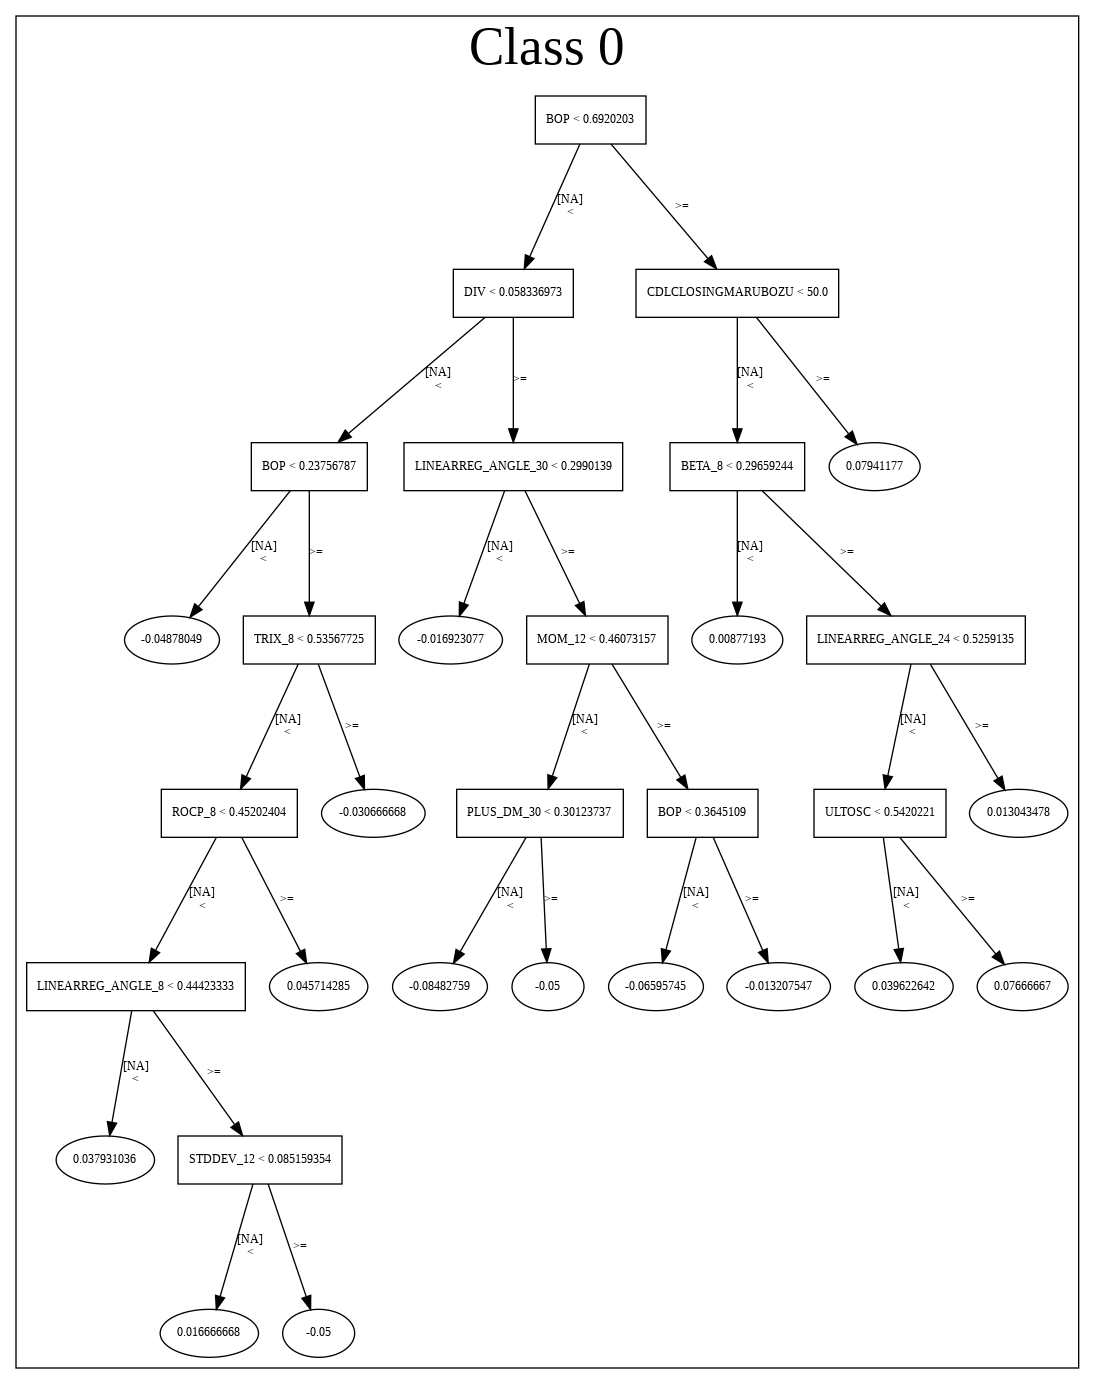

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_175210_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_175210_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a49b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'DIV',
 'SAREXT',
 'hour',
 'Volume',
 'TRANGE',
 'OBV',
 'CORREL_20',
 'ADOSC',
 'ULTOSC',
 'CORREL_24',
 'HT_DCPERIOD',
 'day',
 'CORREL_14',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'CDLGRAVESTONEDOJI',
 'CDLADVANCEBLOCK',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'days_in_month',
 'HT_TRENDMODE',
 'is_month_end',
 'CDLDRAGONFLYDOJI',
 'CDLMATCHINGLOW',
 'CDLEVENINGSTAR',
 'CDLHANGINGMAN',
 'CDLHARAMICROSS',
 'CDLSTICKSANDWICH',
 'CDLTHRUSTING',
 'CDLSTALLEDPATTERN',
 'is_month_start']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 918 936 938] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


46

['hour',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_175234_model_8  0.772220  0.578232              0.289431  0.443742  0.196907
1  DeepLearning_grid_1_AutoML_20190825_175234_model_9  0.769392  0.583900              0.297229  0.447840  0.200561
2  DeepLearning_grid_1_AutoML_20190825_175234_model_5  0.760100  0.591142              0.279210  0.449459  0.202013
3  DeepLearning_grid_1_AutoML_20190825_175234_model_7  0.759858  0.731043              0.290603  0.474472  0.225124
4  DeepLearning_grid_1_AutoML_20190825_175234_model_6  0.755495  0.613691              0.319974  0.453810  0.205944
5  DeepLearning_grid_1_AutoML_20190825_175234_model_4  0.747172  0.672692              0.282765  0.468523  0.219513
6               DeepLearning_1_AutoML_20190825_175234  0.743940  0.621886              0.282240  0.455765  0.207721
7  DeepLearning_grid_1_AutoML_20190825_175234_model_3  0.738526  0.678487              0.303814  0.467052  0.218138
8  DeepLearning_grid_1_AutoML_20190825_175234_model_1  0.712750  0.840490              0.355365  0.490243  0.240338
9  DeepLearning_grid_1_AutoML_20190825_175234_model_2  0.708226  0.654580              0.363163  0.474523  0.225172

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.050705
1                  SUB             0.693393           0.693393    0.035158
2   CDLCLOSINGMARUBOZU             0.663745           0.663745    0.033655
3                  DIV             0.617674           0.617674    0.031319
4         STOCHF_fastk             0.587450           0.587450    0.029786
5          CDLLONGLINE             0.579932           0.579932    0.029405
6                 hour             0.553312           0.553312    0.028056
7               TRANGE             0.551033           0.551033    0.027940
8          CDLBELTHOLD             0.511894           0.511894    0.025955
9                ADOSC             0.480573           0.480573    0.024367
10            WILLR_30             0.451547           0.451547    0.022896
11              CCI_12             0.442568           0.442568    0.022440
12             WILLR_8             0.441172           0.441172    0.022370
13      STOCHRSI_fastk             0.437352           0.437352    0.022176
14         CDLMARUBOZU             0.435074           0.435074    0.022060
15              ULTOSC             0.433421           0.433421    0.021976
16          MINUS_DM_8             0.422421           0.422421    0.021419
17              CCI_14             0.419860           0.419860    0.021289
18              RSI_24             0.408995           0.408995    0.020738
19              CMO_24             0.402898           0.402898    0.020429
20      STOCHRSI_fastd             0.398817           0.398817    0.020222
21        CDLENGULFING             0.392414           0.392414    0.019897
22         STOCH_slowk             0.386439           0.386439    0.019594
23               CCI_8             0.384941           0.384941    0.019518
24            WILLR_24             0.381092           0.381092    0.019323
25        STOCHF_fastd             0.376322           0.376322    0.019081
26            WILLR_20             0.369730           0.369730    0.018747
27          MINUS_DI_8             0.367748           0.367748    0.018647
28               ROC_8             0.360653           0.360653    0.018287
29              CCI_30             0.358429           0.358429    0.018174
30            WILLR_12             0.357915           0.357915    0.018148
31              CMO_12             0.354007           0.354007    0.017950
32           ROCR100_8             0.350690           0.350690    0.017782
33              RSI_14             0.348301           0.348301    0.017660
34              RSI_20             0.348173           0.348173    0.017654
35               MOM_8             0.346839           0.346839    0.017586
36              ROCP_8             0.344039           0.344039    0.017444
37              RSI_12             0.343269           0.343269    0.017405
38              ROCR_8             0.341718           0.341718    0.017327
39              CMO_20             0.340611           0.340611    0.017271
40            WILLR_14             0.333661           0.333661    0.016918
41              CCI_24             0.326654           0.326654    0.016563
42               CMO_8             0.325842           0.325842    0.016522
43              CMO_14             0.324179           0.324179    0.016437
44              CCI_20             0.322051           0.322051    0.016330
45               RSI_8             0.303185           0.303185    0.015373

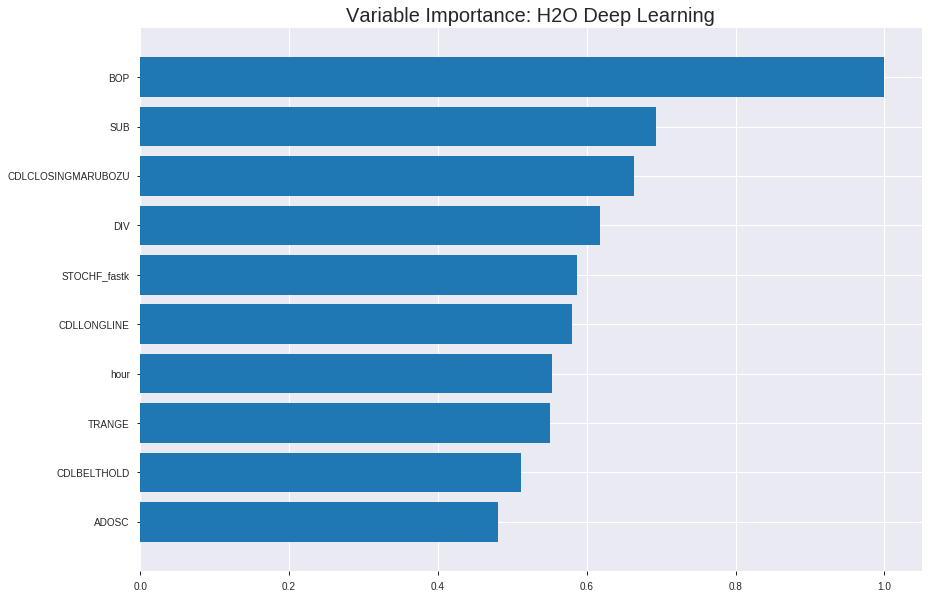

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_175234_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18999809790886715
RMSE: 0.43588771250044106
LogLoss: 0.560050043806636
Mean Per-Class Error: 0.27828650088278417
AUC: 0.788599781215815
pr_auc: 0.7333687428788399
Gini: 0.57719956243163
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41185289498986954: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      430  416   0.4917   (416.0/846.0)
1      78   633   0.1097   (78.0/711.0)
Total  508  1049  0.3173   (494.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411853     0.719318  244
max f2                       0.309352     0.840491  293
max f0point5                 0.545117     0.690483  168
max accuracy                 0.494239     0.716121  202
max precision                0.954012     1         0
max recall                   0.123291     1         367
max specificity              0.954012     1         0
max absolute_mcc             0.494239     0.44358   202
max min_per_class_accuracy   0.518734     0.70922   185
max mean_per_class_accuracy  0.494239     0.721713  202

Gains/Lift Table: Avg response rate: 45.66 %, avg score: 49.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.933136           2.05301   2.05301            0.9375           0.941538  0.9375                      0.941538            0.021097        0.021097                   105.301   105.301
    2        0.0205523                   0.919097           1.64241   1.84771            0.75             0.924034  0.84375                     0.932786            0.0168776       0.0379747                  64.2405   84.7706
    3        0.0301863                   0.898268           1.89789   1.86372            0.866667         0.908245  0.851064                    0.924954            0.0182841       0.0562588                  89.789    86.3722
    4        0.0404624                   0.879577           2.05301   1.91179            0.9375           0.890459  0.873016                    0.916193            0.021097        0.0773558                  105.301   91.1794
    5        0.0500963                   0.860578           2.04388   1.9372             0.933333         0.869875  0.884615                    0.907286            0.0196906       0.0970464                  104.388   93.7196
    6        0.100193                    0.770984           1.71259   1.82489            0.782051         0.805757  0.833333                    0.856522            0.0857947       0.182841                   71.2593   82.4895
    7        0.150289                    0.708079           1.74067   1.79682            0.794872         0.737519  0.820513                    0.816854            0.0872011       0.270042                   74.0669   79.6819
    8        0.200385                    0.664753           1.54414   1.73365            0.705128         0.689274  0.791667                    0.784959            0.0773558       0.347398                   54.4142   73.365
    9        0.299936                    0.60473            1.41282   1.62717            0.645161         0.634374  0.743041                    0.734979            0.140647        0.488045                   41.2822   62.7165
    10       0.400128                    0.553958           1.29146   1.54311            0.589744         0.576033  0.704655                    0.695179            0.129395        0.61744                    29.1464   54.3105
    11       0.500321                    0.511267           1.0809    1.45055            0.49359          0.53271   0.662388                    0.662643            0.108298        0.725738                   8.08991   45.0545
    12       0.599872                    0.465063           0.988975  1.37395            0.451613         0.489604  0.627409                    0.633927            0.0984529       0.824191                   -1.10249  37.3946
    13       0.700064                    0.393996           0.814184  1.29383            0.371795         0.430944  0.590826                    0.604876            0.0815752       0.905767                   -18.5816  29.3833
    14       0.799615                    0.296388           0.607513  1.20839            0.277419         0.348804  0.551807                    0.572996            0.0604782       0.966245                   -39.2487  20.8388
    15       0.899807                    0.190575           0.224602  1.09884            0.102564         0.245297  0.501784                    0.536507            0.0225035       0.988748                   -77.5398  9.88444
    16       1                           0.0103657          0.112301  1                  0.0512821        0.116477  0.456647                    0.494423          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19684128711606977
RMSE: 0.44366799198958423
LogLoss: 0.5773272421371595
Mean Per-Class Error: 0.2895459388574707
AUC: 0.7623248094418491
pr_auc: 0.6871081147699494
Gini: 0.5246496188836982
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4159654126563856: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      148  101  0.4056   (101.0/249.0)
1      34   162  0.1735   (34.0/196.0)
Total  182  263  0.3034   (135.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415965     0.705882  233
max f2                       0.244771     0.831146  321
max f0point5                 0.533519     0.666667  147
max accuracy                 0.533519     0.701124  147
max precision                0.956795     1         0
max recall                   0.0446301    1         395
max specificity              0.956795     1         0
max absolute_mcc             0.415965     0.425012  233
max min_per_class_accuracy   0.490879     0.683673  188
max mean_per_class_accuracy  0.415965     0.710454  233

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 45.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.928528           2.27041   2.27041            1                0.941379   1                           0.941379            0.0255102       0.0255102                  127.041   127.041
    2        0.0202247                   0.921703           1.70281   2.01814            0.75             0.925045   0.888889                    0.934119            0.0153061       0.0408163                  70.2806   101.814
    3        0.0314607                   0.909234           1.81633   1.94606            0.8              0.916559   0.857143                    0.927848            0.0204082       0.0612245                  81.6327   94.6064
    4        0.0404494                   0.876767           1.70281   1.89201            0.75             0.892436   0.833333                    0.919978            0.0153061       0.0765306                  70.2806   89.2007
    5        0.0516854                   0.839106           1.81633   1.87555            0.8              0.8615     0.826087                    0.907266            0.0204082       0.0969388                  81.6327   87.5555
    6        0.101124                    0.706121           1.96081   1.91723            0.863636         0.770848   0.844444                    0.840573            0.0969388       0.193878                   96.0807   91.7234
    7        0.150562                    0.646097           1.1352    1.66045            0.5              0.67336    0.731343                    0.785667            0.0561224       0.25                       13.5204   66.0448
    8        0.2                         0.609803           1.3416    1.58163            0.590909         0.626062   0.696629                    0.746214            0.0663265       0.316327                   34.1605   58.1633
    9        0.301124                    0.554487           1.71542   1.62656            0.755556         0.580745   0.716418                    0.690646            0.173469        0.489796                   71.542    62.6561
    10       0.4                         0.517641           1.1352    1.5051             0.5              0.53575    0.662921                    0.652357            0.112245        0.602041                   13.5204   50.5102
    11       0.501124                    0.477329           1.00907   1.40501            0.444444         0.499702   0.618834                    0.621552            0.102041        0.704082                   0.907029  40.5006
    12       0.6                         0.408148           1.2384    1.37755            0.545455         0.444639   0.606742                    0.592398            0.122449        0.826531                   23.8404   37.7551
    13       0.698876                    0.338019           0.774003  1.29216            0.340909         0.37681    0.569132                    0.561897            0.0765306       0.903061                   -22.5997  29.2162
    14       0.8                         0.248155           0.605442  1.20536            0.266667         0.293161   0.530899                    0.527927            0.0612245       0.964286                   -39.4558  20.5357
    15       0.898876                    0.141977           0.1032    1.08412            0.0454545        0.202605   0.4775                      0.492142            0.0102041       0.97449                    -89.68    8.41199
    16       1                           0.0136245          0.252268  1                  0.111111         0.0876712  0.440449                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:59:01  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 17:59:03  1 min 38.143 sec  717 obs/sec       0.83815   1             1305       0.52592          0.780128            -0.11475       0.732347        0.675775           1.77927          0.359666                         0.517059           0.754954              -0.0847873       0.713651          0.641948             2.27041            0.4
    2019-08-25 17:59:15  1 min 49.965 sec  1040 obs/sec      8.34168   10            12988      0.440405         0.568555            0.218295       0.771267        0.715689           2.05301          0.308285                         0.450605           0.5891                0.176134         0.745748          0.659865             1.36224            0.337079
    2019-08-25 17:59:27  2 min  2.114 sec  1156 obs/sec      17.456    21            27179      0.435888         0.56005             0.234251       0.7886          0.733369           2.05301          0.317277                         0.443668           0.577327              0.201305         0.762325          0.687108             2.27041            0.303371
    2019-08-25 17:59:39  2 min 14.139 sec  1240 obs/sec      27.4265   33            42703      0.430668         0.550349            0.252479       0.797176        0.750849           2.05301          0.305716                         0.448212           0.607077              0.184863         0.772119          0.693421             1.81633            0.307865
    2019-08-25 17:59:51  2 min 25.807 sec  1294 obs/sec      37.3783   45            58198      0.427391         0.536816            0.263812       0.801859        0.757942           2.05301          0.288375                         0.441844           0.58145               0.207859         0.773185          0.707307             2.27041            0.303371
    2019-08-25 18:00:03  2 min 37.690 sec  1299 obs/sec      46.4875   56            72381      0.422442         0.524933            0.280764       0.809451        0.763807           2.18987          0.312781                         0.441477           0.587128              0.209175         0.771699          0.701763             1.81633            0.303371
    2019-08-25 18:00:14  2 min 49.523 sec  1340 obs/sec      57.1985   69            89058      0.42061          0.520976            0.286988       0.81854         0.782512           2.18987          0.278741                         0.453128           0.651358              0.16688          0.770418          0.695299             2.27041            0.314607
    2019-08-25 18:00:16  2 min 50.675 sec  1340 obs/sec      57.1985   69            89058      0.435888         0.56005             0.234251       0.7886          0.733369           2.05301          0.317277                         0.443668           0.577327              0.201305         0.762325          0.687108             2.27041            0.303371

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.05070471437551659
SUB                 0.6933932900428772     0.6933932900428772   0.03515830872152382
CDLCLOSINGMARUBOZU  0.6637447476387024     0.6637447476387024   0.033654987847269745
DIV                 0.6176735162734985     0.6176735162734985   0.03131895921996874
STOCHF_fastk        0.5874499678611755     0.5874499678611755   0.029786482830307305
---                 ---                    ---                  ---
CCI_24              0.326654314994812      0.326654314994812    0.01656291374134197
CMO_8               0.32584232091903687    0.32584232091903687  0.016521741813655177
CMO_14              0.3241786062717438     0.3241786062717438   0.01643738363766182
CCI_20              0.32205140590667725    0.32205140590667725  0.016329524550731625
RSI_8               0.30318483710289       0.30318483710289     0.015372900568289563


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.717948717948718)

('auc', 0.7722204266321914)

('logloss', 0.5782317387601765)

('mean_per_class_error', 0.2894311570782159)

('rmse', 0.44374151408339774)

('mse', 0.19690653132102628)

deeplearning prediction progress: |███████████████████████████████████████| 100%


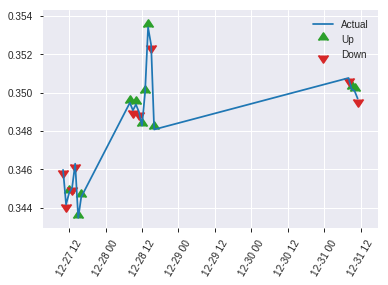


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19690653132102628
RMSE: 0.44374151408339774
LogLoss: 0.5782317387601765
Mean Per-Class Error: 0.2894311570782159
AUC: 0.7722204266321914
pr_auc: 0.7000486927899687
Gini: 0.5444408532643827
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46138605535309996: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      73   46   0.3866   (46.0/119.0)
1      20   84   0.1923   (20.0/104.0)
Total  93   130  0.296    (66.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.461386     0.717949  129
max f2                       0.272804     0.837521  180
max f0point5                 0.566571     0.723684  68
max accuracy                 0.566571     0.717489  68
max precision                0.940193     1         0
max recall                   0.117027     1         211
max specificity              0.940193     1         0
max absolute_mcc             0.566571     0.443769  68
max min_per_class_accuracy   0.513077     0.705882  108
max mean_per_class_accuracy  0.461386     0.710569  129

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 48.20 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.920948           1.42949    1.42949            0.666667         0.932242  0.666667                    0.932242            0.0192308       0.0192308                  42.9487   42.9487
    2        0.0224215                   0.909835           1.07212    1.28654            0.5              0.915569  0.6                         0.925573            0.00961538      0.0288462                  7.21154   28.6538
    3        0.0313901                   0.890326           2.14423    1.53159            1                0.901621  0.714286                    0.918729            0.0192308       0.0480769                  114.423   53.1593
    4        0.0403587                   0.881222           2.14423    1.66774            1                0.885906  0.777778                    0.911435            0.0192308       0.0673077                  114.423   66.7735
    5        0.0538117                   0.869462           2.14423    1.78686            1                0.877043  0.833333                    0.902837            0.0288462       0.0961538                  114.423   78.6859
    6        0.103139                    0.769947           1.16958    1.49164            0.545455         0.803053  0.695652                    0.855114            0.0576923       0.153846                   16.958    49.1639
    7        0.152466                    0.702801           1.9493     1.63971            0.909091         0.734864  0.764706                    0.81621             0.0961538       0.25                       94.9301   63.9706
    8        0.201794                    0.661387           1.55944    1.62009            0.727273         0.681192  0.755556                    0.783205            0.0769231       0.326923                   55.9441   62.0085
    9        0.300448                    0.571946           1.85184    1.69618            0.863636         0.614014  0.791045                    0.72765             0.182692        0.509615                   85.1836   69.6183
    10       0.399103                    0.538955           1.07212    1.54192            0.5              0.553842  0.719101                    0.684686            0.105769        0.615385                   7.21154   54.1919
    11       0.502242                    0.507792           1.0255     1.43587            0.478261         0.524847  0.669643                    0.651862            0.105769        0.721154                   2.55017   43.5869
    12       0.600897                    0.43945            0.877185   1.34414            0.409091         0.477315  0.626866                    0.623205            0.0865385       0.807692                   -12.2815  34.4145
    13       0.699552                    0.379977           0.682255   1.2508             0.318182         0.40756   0.583333                    0.592794            0.0673077       0.875                      -31.7745  25.0801
    14       0.798206                    0.28393            0.682255   1.18053            0.318182         0.332405  0.550562                    0.560611            0.0673077       0.942308                   -31.7745  18.0532
    15       0.896861                    0.186624           0.487325   1.10428            0.227273         0.234406  0.515                       0.524728            0.0480769       0.990385                   -51.2675  10.4279
    16       1                           0.0281903          0.0932274  1                  0.0434783        0.110375  0.466368                   

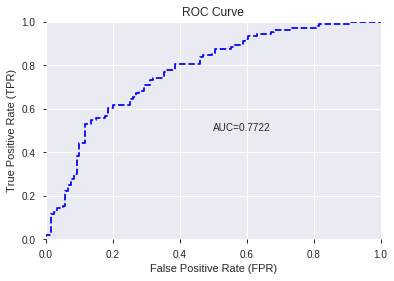

This function is available for GLM models only


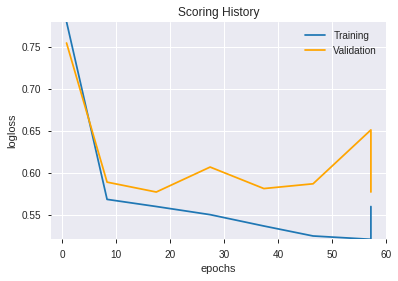

--2019-08-25 18:01:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


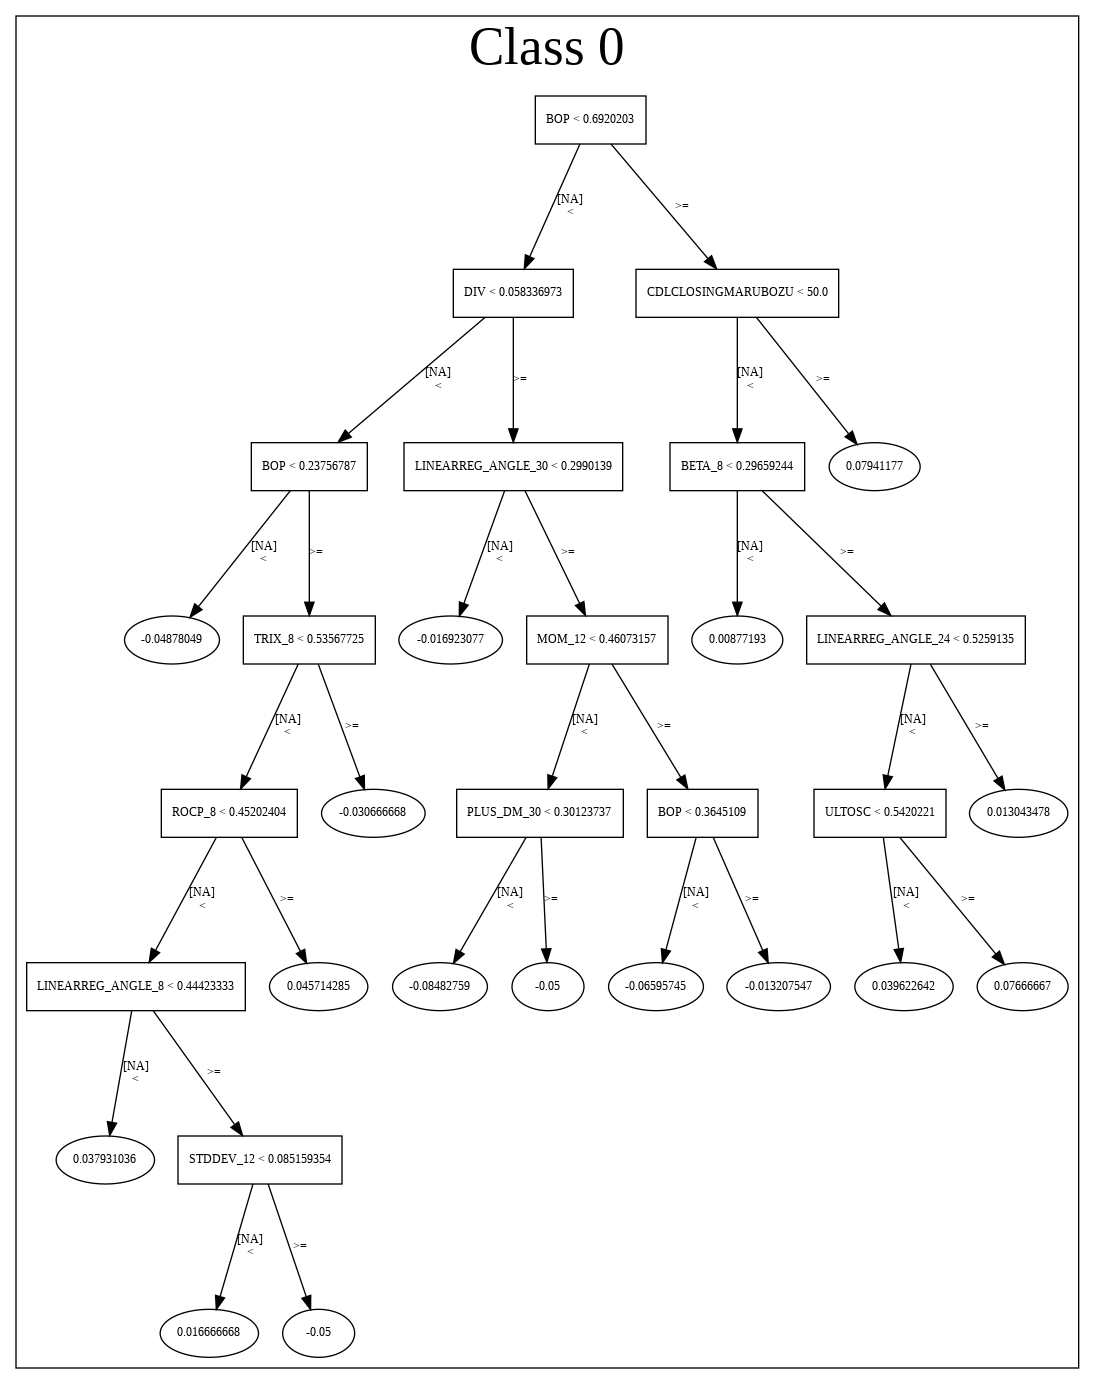

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_175234_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_175234_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a49b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'hour',
 'TRANGE',
 'CDLBELTHOLD',
 'ADOSC',
 'WILLR_30',
 'CCI_12',
 'WILLR_8',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'ULTOSC',
 'MINUS_DM_8',
 'CCI_14',
 'RSI_24',
 'CMO_24',
 'STOCHRSI_fastd',
 'CDLENGULFING',
 'STOCH_slowk',
 'CCI_8',
 'WILLR_24',
 'STOCHF_fastd',
 'WILLR_20',
 'MINUS_DI_8',
 'ROC_8',
 'CCI_30',
 'WILLR_12',
 'CMO_12',
 'ROCR100_8',
 'RSI_14',
 'RSI_20',
 'MOM_8',
 'ROCP_8',
 'RSI_12',
 'ROCR_8',
 'CMO_20',
 'WILLR_14',
 'CCI_24',
 'CMO_8',
 'CMO_14',
 'CCI_20',
 'RSI_8']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_180144_model_1  0.757676  0.579209              0.280422  0.445655  0.198609

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.629653           1.000000    0.116133
1                  SUB             0.522421           0.829697    0.096356
2         STOCHF_fastk             0.348062           0.552784    0.064197
3             WILLR_30             0.240538           0.382017    0.044365
4               CCI_12             0.219736           0.348980    0.040528
5                 hour             0.211773           0.336334    0.039060
6   CDLCLOSINGMARUBOZU             0.211243           0.335492    0.038962
7              WILLR_8             0.209443           0.332632    0.038630
8           MINUS_DM_8             0.208021           0.330374    0.038367
9           MINUS_DI_8             0.204684           0.325075    0.037752
10               ADOSC             0.200177           0.317916    0.036921
11               MOM_8             0.198084           0.314592    0.036535
12         STOCH_slowk             0.170906           0.271430    0.031522
13        STOCHF_fastd             0.170637           0.271002    0.031472
14            WILLR_12             0.128013           0.203307    0.023611
15              CCI_14             0.119976           0.190543    0.022128
16              ULTOSC             0.117590           0.186754    0.021688
17               CCI_8             0.103106           0.163750    0.019017
18              CMO_24             0.096773           0.153693    0.017849
19              RSI_24             0.093640           0.148716    0.017271
20         CDLLONGLINE             0.087202           0.138492    0.016084
21         CDLMARUBOZU             0.074576           0.118440    0.013755
22            WILLR_20             0.073296           0.116407    0.013519
23              ROCP_8             0.072998           0.115933    0.013464
24              ROCR_8             0.071348           0.113314    0.013160
25               ROC_8             0.068300           0.108472    0.012597
26           ROCR100_8             0.065367           0.103815    0.012056
27              TRANGE             0.051868           0.082376    0.009567
28              CCI_24             0.051742           0.082175    0.009543
29              RSI_20             0.050630           0.080409    0.009338
30      STOCHRSI_fastd             0.048352           0.076792    0.008918
31              CMO_20             0.047891           0.076059    0.008833
32              CCI_30             0.040820           0.064830    0.007529
33         CDLBELTHOLD             0.027743           0.044061    0.005117
34              CCI_20             0.024364           0.038695    0.004494
35              CMO_12             0.023414           0.037186    0.004318
36        CDLENGULFING             0.022146           0.035173    0.004085
37              RSI_12             0.020696           0.032869    0.003817
38                 DIV             0.017801           0.028272    0.003283
39              CMO_14             0.015858           0.025185    0.002925
40            WILLR_14             0.014800           0.023505    0.002730
41              RSI_14             0.014348           0.022788    0.002646
42            WILLR_24             0.014021           0.022268    0.002586
43      STOCHRSI_fastk             0.009037           0.014353    0.001667
44               CMO_8             0.006740           0.010704    0.001243
45               RSI_8             0.001966           0.003122    0.000363

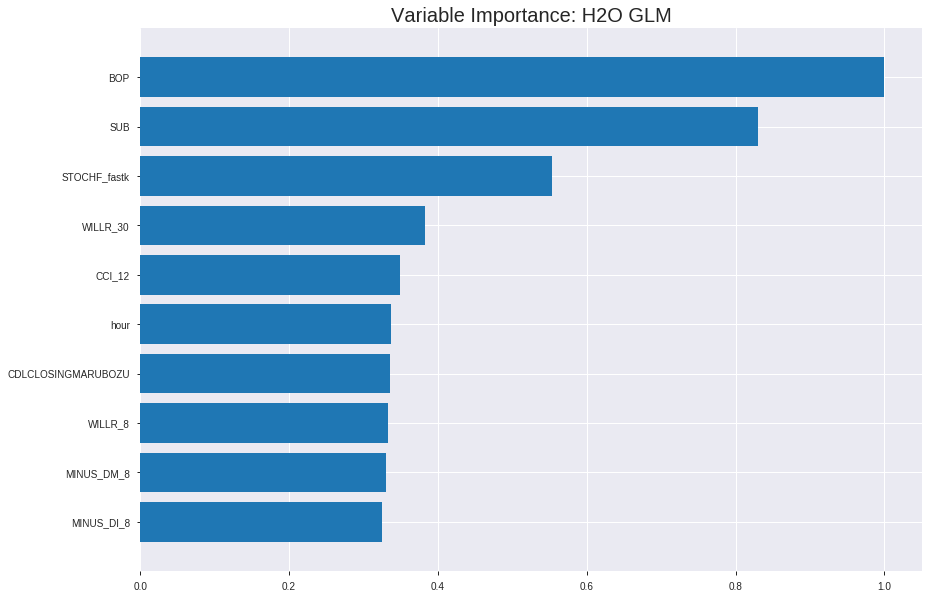

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_180144_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1920980484455712
RMSE: 0.4382899136936318
LogLoss: 0.5660168930678983
Null degrees of freedom: 1556
Residual degrees of freedom: 1510
Null deviance: 2146.7404074571314
Residual deviance: 1762.576605013435
AIC: 1856.576605013435
AUC: 0.7756572669266807
pr_auc: 0.7223055190004222
Gini: 0.5513145338533614
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3443235049155582: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      443  403   0.4764   (403.0/846.0)
1      92   619   0.1294   (92.0/711.0)
Total  535  1022  0.3179   (495.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344324     0.714368  254
max f2                       0.222648     0.826034  312
max f0point5                 0.551821     0.691783  152
max accuracy                 0.502265     0.717405  177
max precision                0.93589      1         0
max recall                   0.0463224    1         388
max specificity              0.93589      1         0
max absolute_mcc             0.502265     0.429813  177
max min_per_class_accuracy   0.474258     0.706856  190
max mean_per_class_accuracy  0.502265     0.714591  177

Gains/Lift Table: Avg response rate: 45.66 %, avg score: 45.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.895188           2.18987   2.18987            1                0.91266    1                           0.91266             0.0225035       0.0225035                  118.987   118.987
    2        0.0205523                   0.872216           1.91614   2.05301            0.875            0.88316    0.9375                      0.89791             0.0196906       0.0421941                  91.6139   105.301
    3        0.0301863                   0.848097           1.60591   1.91032            0.733333         0.860389   0.87234                     0.885935            0.0154712       0.0576653                  60.5907   91.0315
    4        0.0404624                   0.832785           1.77927   1.87703            0.8125           0.840186   0.857143                    0.874317            0.0182841       0.0759494                  77.9272   87.7034
    5        0.0500963                   0.823801           1.60591   1.82489            0.733333         0.827544   0.833333                    0.865322            0.0154712       0.0914205                  60.5907   82.4895
    6        0.100193                    0.765195           1.79682   1.81086            0.820513         0.794231   0.826923                    0.829776            0.0900141       0.181435                   79.6819   81.0857
    7        0.150289                    0.716947           1.54414   1.72195            0.705128         0.741677   0.786325                    0.80041             0.0773558       0.25879                    54.4142   72.1952
    8        0.200385                    0.673784           1.45992   1.65644            0.666667         0.694987   0.75641                     0.774054            0.0731364       0.331927                   45.9916   65.6443
    9        0.299936                    0.604923           1.51172   1.60841            0.690323         0.637862   0.734475                    0.728851            0.150492        0.482419                   51.1719   60.8408
    10       0.400128                    0.536863           1.37569   1.55014            0.628205         0.570235   0.707865                    0.689134            0.137834        0.620253                   37.569    55.0135
    11       0.500321                    0.457957           1.0809    1.45617            0.49359          0.497827   0.664955                    0.650823            0.108298        0.728551                   8.08991   45.6167
    12       0.599872                    0.382319           0.890078  1.36222            0.406452         0.423044   0.622056                    0.613023            0.0886076       0.817159                   -10.9922  36.2223
    13       0.700064                    0.305931           0.743995  1.27374            0.339744         0.346131   0.581651                    0.574825            0.0745429       0.891702                   -25.6005  27.3743
    14       0.799615                    0.229869           0.565129  1.18552            0.258065         0.26921    0.541365                    0.536777            0.0562588       0.947961                   -43.4871  18.5522
    15       0.899807                    0.139227           0.350941  1.09259            0.160256         0.184382   0.498929                    0.497538            0.0351617       0.983122                   -64.9059  9.25921
    16       1                           0.00132961         0.168452  1                  0.0769231        0.0894192  0.456647                   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2003549473744711
RMSE: 0.44761026281182503
LogLoss: 0.5807577087813934
Null degrees of freedom: 444
Residual degrees of freedom: 398
Null deviance: 611.0451593654886
Residual deviance: 516.8743608154401
AIC: 610.8743608154401
AUC: 0.7506761740840914
pr_auc: 0.6749358206874021
Gini: 0.5013523481681827
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22047872504951996: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      83   166  0.6667   (166.0/249.0)
1      6    190  0.0306   (6.0/196.0)
Total  89   356  0.3865   (172.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.220479     0.688406  316
max f2                       0.220479     0.833333  316
max f0point5                 0.496941     0.66048   157
max accuracy                 0.496941     0.698876  157
max precision                0.922136     1         0
max recall                   0.0355698    1         392
max specificity              0.922136     1         0
max absolute_mcc             0.496941     0.384776  157
max min_per_class_accuracy   0.451745     0.668367  186
max mean_per_class_accuracy  0.496941     0.6902    157

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 43.10 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.886768           1.36224    1.36224            0.6              0.908834   0.6                         0.908834            0.0153061       0.0153061                  36.2245   36.2245
    2        0.0202247                   0.858881           2.27041    1.76587            1                0.867561   0.777778                    0.89049             0.0204082       0.0357143                  127.041   76.5873
    3        0.0314607                   0.851689           2.27041    1.94606            1                0.855263   0.857143                    0.877909            0.0255102       0.0612245                  127.041   94.6064
    4        0.0404494                   0.837618           2.27041    2.01814            1                0.843604   0.888889                    0.870286            0.0204082       0.0816327                  127.041   101.814
    5        0.0516854                   0.795351           1.36224    1.87555            0.6              0.820413   0.826087                    0.859444            0.0153061       0.0969388                  36.2245   87.5555
    6        0.101124                    0.728857           1.54801    1.71542            0.681818         0.761188   0.755556                    0.811408            0.0765306       0.173469                   54.8006   71.542
    7        0.150562                    0.673899           1.65121    1.69433            0.727273         0.696521   0.746269                    0.773684            0.0816327       0.255102                   65.1206   69.4334
    8        0.2                         0.649434           1.44481    1.63265            0.636364         0.661985   0.719101                    0.746073            0.0714286       0.326531                   44.4805   63.2653
    9        0.301124                    0.562312           1.4127     1.55879            0.622222         0.603208   0.686567                    0.698096            0.142857        0.469388                   41.2698   55.8788
    10       0.4                         0.497463           1.44481    1.53061            0.636364         0.529063   0.674157                    0.656312            0.142857        0.612245                   44.4805   53.0612
    11       0.501124                    0.435664           0.706349   1.36428            0.311111         0.469419   0.600897                    0.618598            0.0714286       0.683673                   -29.3651  36.4281
    12       0.6                         0.367081           1.1352     1.32653            0.5              0.401362   0.58427                     0.582799            0.112245        0.795918                   13.5204   32.6531
    13       0.698876                    0.288406           0.774003   1.24836            0.340909         0.328968   0.549839                    0.546887            0.0765306       0.872449                   -22.5997  24.8359
    14       0.8                         0.220219           0.958617   1.21173            0.422222         0.250384   0.533708                    0.509408            0.0969388       0.969388                   -4.13832  21.1735
    15       0.898876                    0.111323           0.258001   1.10682            0.113636         0.165554   0.4875                      0.471584            0.0255102       0.994898                   -74.1999  10.6824
    16       1                           0.00642242         0.0504535  1                  0.0222222        0.0704089  0.440449  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-25 18:01:44  0.000 sec   2            .2E2      47            1.3543137367418256  1.3488687649801092
     2019-08-25 18:01:44  0.008 sec   4            .12E2     47            1.344064994198237   1.3390312920908563
     2019-08-25 18:01:44  0.016 sec   6            .76E1     47            1.3311907509232253  1.3269128390124918
     2019-08-25 18:01:44  0.024 sec   8            .47E1     47            1.3154843236709859  1.312394477483033
     2019-08-25 18:01:44  0.032 sec   10           .29E1     47            1.2968354810161116  1.2953626020018196
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-25 18:01:44  0.149 sec   38           .37E-2    47            1.129971881073101   1.161824276083579
     2019-08-25 18:01:44  0.157 sec   40           .23E-2    47            1.1280458174620949  1.1627983914946878
     2019-08-25 18:01:44  0.165 sec   42           .14E-2    47            1.1262897605231716  1.1643812228588077
     2019-08-25 18:01:44  0.173 sec   44           .9E-3     47            1.1248013787875775  1.1665866588150966
     2019-08-25 18:01:44  0.183 sec   46           .56E-3    47            1.1237028835622027  1.1691221003218564


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7130044843049327)

('F1', 0.7264957264957265)

('auc', 0.7576761473820297)

('logloss', 0.5792091145622543)

('mean_per_class_error', 0.2804217840982547)

('rmse', 0.44565518579067737)

('mse', 0.19860854462212318)

glm prediction progress: |████████████████████████████████████████████████| 100%


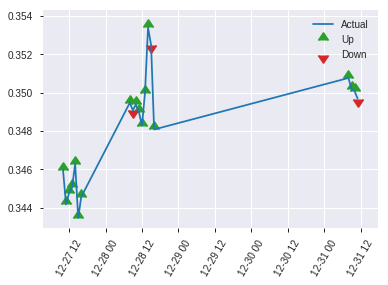


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19860854462212318
RMSE: 0.44565518579067737
LogLoss: 0.5792091145622543
Null degrees of freedom: 222
Residual degrees of freedom: 176
Null deviance: 308.21873965260795
Residual deviance: 258.32726509476544
AIC: 352.32726509476544
AUC: 0.7576761473820297
pr_auc: 0.6584080000906971
Gini: 0.5153522947640594
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43422715518977506: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   45   0.3782   (45.0/119.0)
1      19   85   0.1827   (19.0/104.0)
Total  93   130  0.287    (64.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.434227     0.726496  129
max f2                       0.155186     0.849673  195
max f0point5                 0.554647     0.689655  89
max accuracy                 0.478044     0.713004  119
max precision                0.737693     0.735294  33
max recall                   0.155186     1         195
max specificity              0.899519     0.991597  0
max absolute_mcc             0.434227     0.44432   129
max min_per_class_accuracy   0.511153     0.697479  108
max mean_per_class_accuracy  0.434227     0.719578  129

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 47.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.876013           1.42949   1.42949            0.666667         0.886646   0.666667                    0.886646            0.0192308       0.0192308                  42.9487   42.9487
    2        0.0224215                   0.854531           1.07212   1.28654            0.5              0.860862   0.6                         0.876333            0.00961538      0.0288462                  7.21154   28.6538
    3        0.0313901                   0.836472           1.07212   1.22527            0.5              0.844375   0.571429                    0.867202            0.00961538      0.0384615                  7.21154   22.5275
    4        0.0403587                   0.827781           1.07212   1.19124            0.5              0.831132   0.555556                    0.859186            0.00961538      0.0480769                  7.21154   19.1239
    5        0.0538117                   0.823383           1.42949   1.2508             0.666667         0.825184   0.583333                    0.850686            0.0192308       0.0673077                  42.9487   25.0801
    6        0.103139                    0.772405           1.75437   1.49164            0.818182         0.796499   0.695652                    0.82477             0.0865385       0.153846                   75.4371   49.1639
    7        0.152466                    0.735861           1.75437   1.57664            0.818182         0.753558   0.735294                    0.801731            0.0865385       0.240385                   75.4371   57.664
    8        0.201794                    0.700296           1.36451   1.52479            0.636364         0.719914   0.711111                    0.781731            0.0673077       0.307692                   36.451    52.4786
    9        0.300448                    0.614576           1.46198   1.50416            0.681818         0.649343   0.701493                    0.738261            0.144231        0.451923                   46.1976   50.4162
    10       0.399103                    0.5547             1.55944   1.51783            0.727273         0.581974   0.707865                    0.699628            0.153846        0.605769                   55.9441   51.7826
    11       0.502242                    0.497646           1.11873   1.43587            0.521739         0.527618   0.669643                    0.664304            0.115385        0.721154                   11.8729   43.5869
    12       0.600897                    0.415505           0.97465   1.36015            0.454545         0.46067    0.634328                    0.630872            0.0961538       0.817308                   -2.53497  36.0146
    13       0.699552                    0.343471           0.77972   1.27829            0.363636         0.377548   0.596154                    0.595147            0.0769231       0.894231                   -22.028   27.8291
    14       0.798206                    0.251554           0.682255  1.20462            0.318182         0.295586   0.561798                    0.558122            0.0673077       0.961538                   -31.7745  20.4624
    15       0.896861                    0.132146           0.38986   1.115              0.181818         0.187554   0.52                        0.51736             0.0384615       1                          -61.014   11.5
    16       1                           0.0329688          0         1                  0                0.0868006  0.466368                    0.4

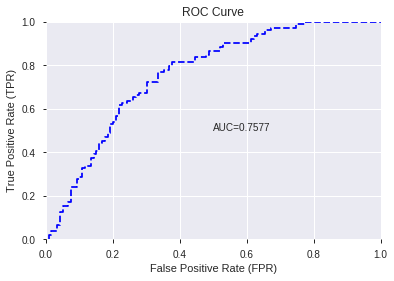

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


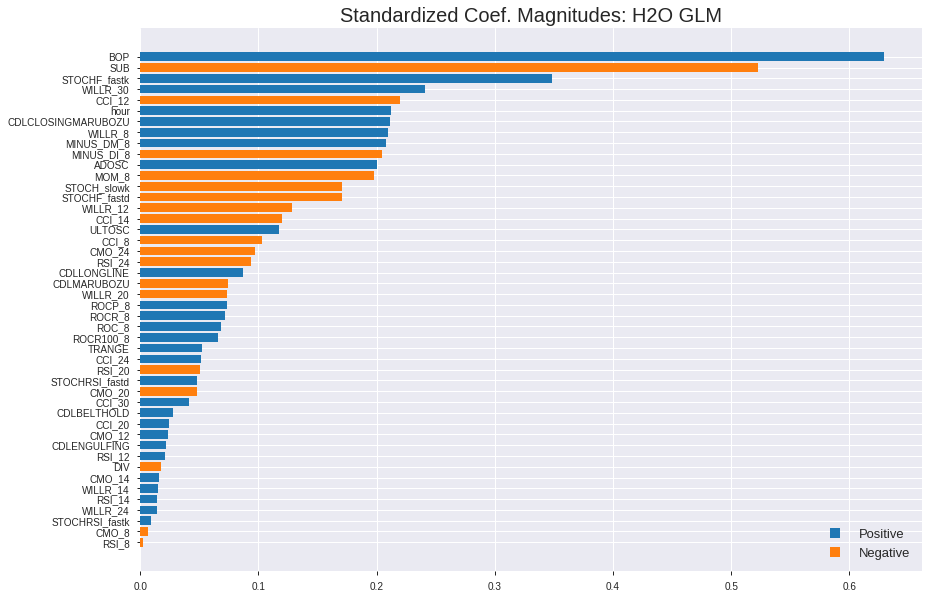

'log_likelihood'
--2019-08-25 18:01:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


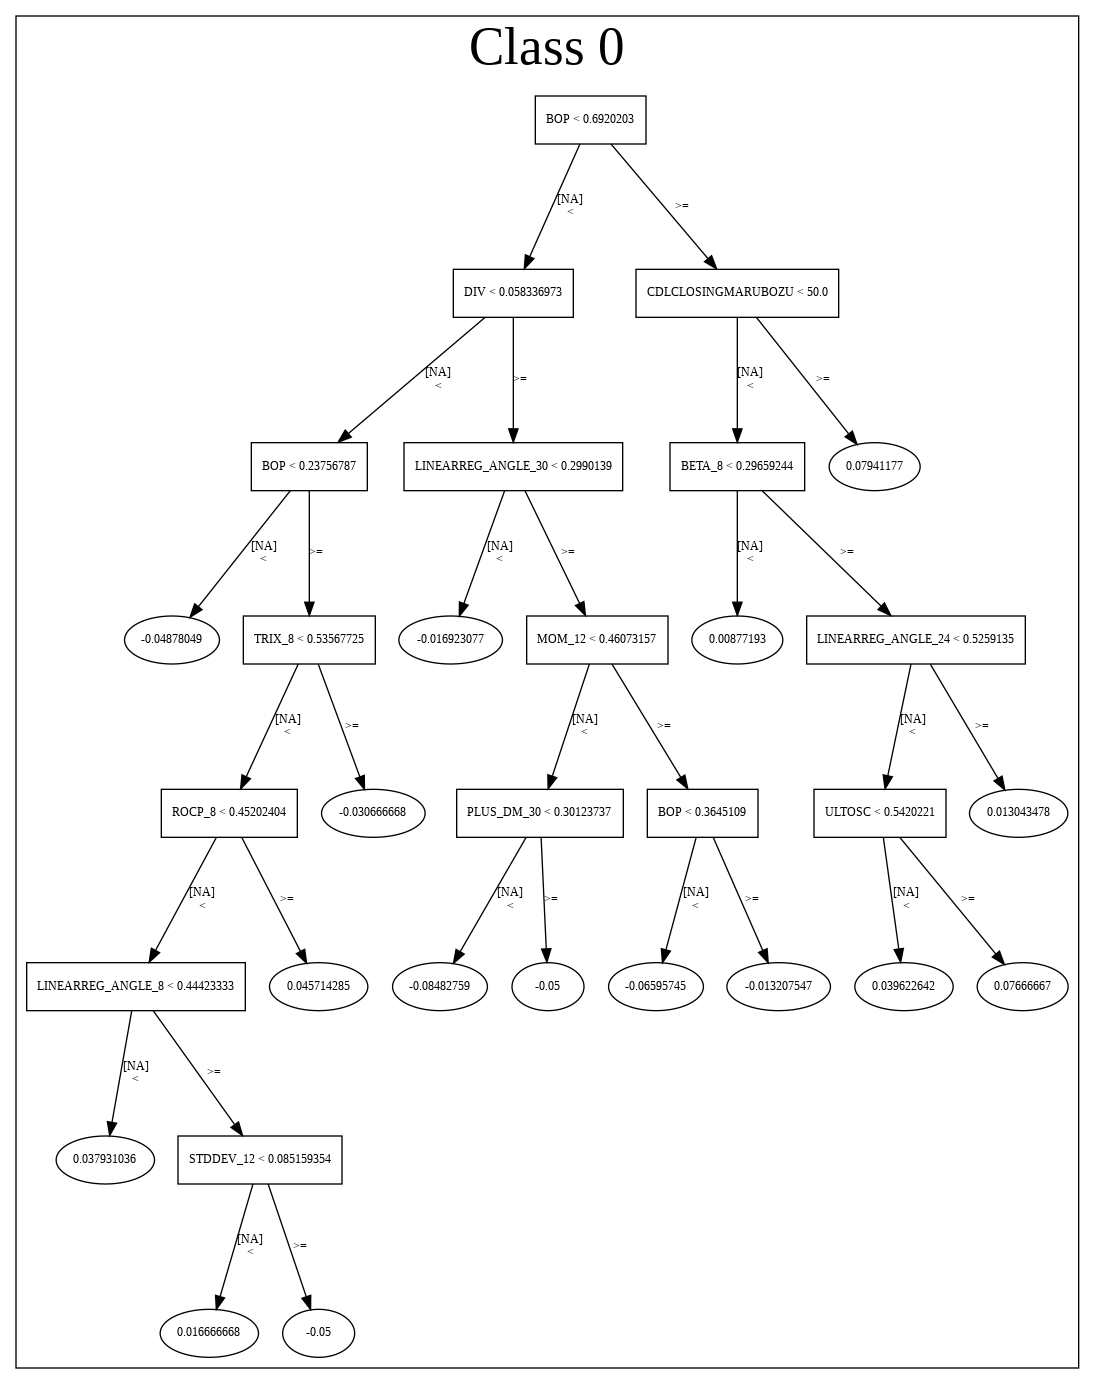

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_180144_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_180144_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a49b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'SUB',
 'STOCHF_fastk',
 'WILLR_30',
 'CCI_12',
 'hour',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'MINUS_DM_8',
 'MINUS_DI_8',
 'ADOSC',
 'MOM_8',
 'STOCH_slowk',
 'STOCHF_fastd',
 'WILLR_12',
 'CCI_14',
 'ULTOSC',
 'CCI_8',
 'CMO_24',
 'RSI_24',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'WILLR_20',
 'ROCP_8',
 'ROCR_8',
 'ROC_8',
 'ROCR100_8',
 'TRANGE',
 'CCI_24',
 'RSI_20',
 'STOCHRSI_fastd',
 'CMO_20',
 'CCI_30',
 'CDLBELTHOLD',
 'CCI_20',
 'CMO_12',
 'CDLENGULFING',
 'RSI_12',
 'DIV',
 'CMO_14',
 'WILLR_14',
 'RSI_14',
 'WILLR_24',
 'STOCHRSI_fastk',
 'CMO_8',
 'RSI_8']

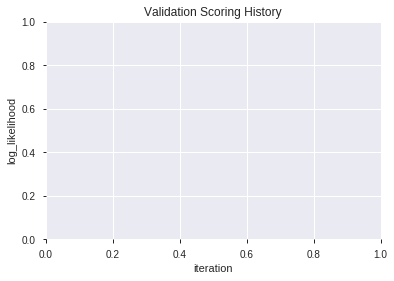

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_180154_model_1  0.787411  0.555016              0.258807  0.434608  0.188884
1               XGBoost_3_AutoML_20190825_180154  0.786684  0.554828              0.266605  0.434532  0.188818
2  XGBoost_grid_1_AutoML_20190825_180154_model_6  0.785795  0.555692              0.270806  0.435297  0.189483
3               XGBoost_2_AutoML_20190825_180154  0.784825  0.556569              0.303733  0.435739  0.189868
4  XGBoost_grid_1_AutoML_20190825_180154_model_2  0.784179  0.562221              0.291168  0.437118  0.191072
5  XGBoost_grid_1_AutoML_20190825_180154_model_7  0.782563  0.559950              0.303773  0.436317  0.190372
6  XGBoost_grid_1_AutoML_20190825_180154_model_4  0.780462  0.559528              0.264827  0.435733  0.189863
7               XGBoost_1_AutoML_20190825_180154  0.777957  0.561126              0.311530  0.437689  0.191572
8  XGBoost_grid_1_AutoML_20190825_180154_model_5  0.777634  0.563286              0.288138  0.439250  0.192941
9  XGBoost_grid_1_AutoML_20190825_180154_model_3  0.773028  0.566723              0.276220  0.440402  0.193954

variable  relative_importance  scaled_importance  percentage
0                  BOP          2355.191650           1.000000    0.289461
1                  SUB           695.337463           0.295236    0.085459
2                  DIV           665.330322           0.282495    0.081771
3         STOCHF_fastk           516.643433           0.219364    0.063497
4                CCI_8           398.429199           0.169171    0.048968
5              WILLR_8           328.258850           0.139377    0.040344
6               TRANGE           306.423828           0.130106    0.037661
7       STOCHRSI_fastk           301.438049           0.127989    0.037048
8                 hour           266.820862           0.113291    0.032793
9           MINUS_DM_8           162.159393           0.068852    0.019930
10              CCI_12           154.217941           0.065480    0.018954
11              CCI_14           150.029114           0.063701    0.018439
12               ADOSC           145.300079           0.061694    0.017858
13      STOCHRSI_fastd           141.728500           0.060177    0.017419
14            WILLR_14           140.639481           0.059715    0.017285
15            WILLR_12           132.628464           0.056313    0.016300
16               MOM_8           114.904060           0.048788    0.014122
17              ULTOSC            93.552116           0.039722    0.011498
18         STOCH_slowk            93.538849           0.039716    0.011496
19            WILLR_30            87.718132           0.037245    0.010781
20              CCI_30            83.838722           0.035597    0.010304
21          MINUS_DI_8            79.813263           0.033888    0.009809
22              CCI_20            78.710411           0.033420    0.009674
23            WILLR_20            66.712700           0.028326    0.008199
24              CMO_14            66.663033           0.028305    0.008193
25              CMO_20            58.952496           0.025031    0.007245
26              CCI_24            57.317024           0.024336    0.007044
27               ROC_8            56.271614           0.023893    0.006916
28  CDLCLOSINGMARUBOZU            52.711411           0.022381    0.006478
29            WILLR_24            46.572182           0.019774    0.005724
30         CDLLONGLINE            46.351692           0.019681    0.005697
31              CMO_24            44.870438           0.019052    0.005515
32               CMO_8            37.269276           0.015824    0.004581
33         CDLBELTHOLD            25.954426           0.011020    0.003190
34              RSI_24            25.473392           0.010816    0.003131
35              CMO_12            14.198261           0.006028    0.001745
36        STOCHF_fastd            11.956808           0.005077    0.001470
37              RSI_20            11.066790           0.004699    0.001360
38               RSI_8             8.614365           0.003658    0.001059
39              RSI_12             6.562119           0.002786    0.000807
40              RSI_14             3.629917           0.001541    0.000446
41              ROCP_8             2.671967           0.001135    0.000328

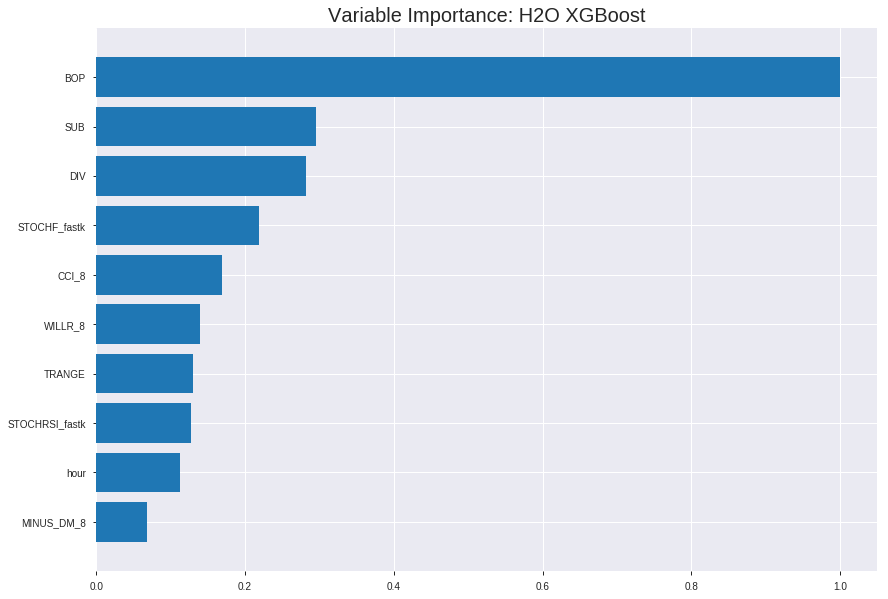

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_180154_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13613231217814262
RMSE: 0.3689611255649335
LogLoss: 0.4348681419247918
Mean Per-Class Error: 0.17667654187988147
AUC: 0.9142095008196094
pr_auc: 0.9041508943768809
Gini: 0.8284190016392188
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4446283628543218: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      642  204  0.2411   (204.0/846.0)
1      83   628  0.1167   (83.0/711.0)
Total  725  832  0.1843   (287.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444628     0.813999  215
max f2                       0.3085       0.886561  274
max f0point5                 0.610723     0.846183  135
max accuracy                 0.556115     0.830443  161
max precision                0.939441     1         0
max recall                   0.132212     1         357
max specificity              0.939441     1         0
max absolute_mcc             0.556115     0.660436  161
max min_per_class_accuracy   0.496987     0.815603  190
max mean_per_class_accuracy  0.556115     0.823323  161

Gains/Lift Table: Avg response rate: 45.66 %, avg score: 45.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.896518           2.18987   2.18987            1                0.918189   1                           0.918189            0.0225035       0.0225035                  118.987   118.987
    2        0.0205523                   0.880735           2.18987   2.18987            1                0.888211   1                           0.9032              0.0225035       0.045007                   118.987   118.987
    3        0.0301863                   0.868429           2.18987   2.18987            1                0.875728   1                           0.894432            0.021097        0.0661041                  118.987   118.987
    4        0.0404624                   0.855801           2.18987   2.18987            1                0.860169   1                           0.88573             0.0225035       0.0886076                  118.987   118.987
    5        0.0500963                   0.844275           2.18987   2.18987            1                0.849894   1                           0.878839            0.021097        0.109705                   118.987   118.987
    6        0.100193                    0.782288           2.13372   2.1618             0.974359         0.811083   0.987179                    0.844961            0.106892        0.216596                   113.372   116.18
    7        0.150289                    0.730172           2.10565   2.14308            0.961538         0.753802   0.978632                    0.814575            0.105485        0.322082                   110.565   114.308
    8        0.200385                    0.686658           2.0495    2.11969            0.935897         0.707655   0.967949                    0.787845            0.102672        0.424754                   104.95    111.969
    9        0.299936                    0.619148           1.87905   2.03982            0.858065         0.652792   0.931478                    0.74302             0.18706         0.611814                   87.9053   103.982
    10       0.400128                    0.548606           1.36165   1.87               0.621795         0.582189   0.853933                    0.702748            0.136428        0.748242                   36.1652   87.0004
    11       0.500321                    0.47095            0.968598  1.68949            0.442308         0.512014   0.771502                    0.664552            0.0970464       0.845288                   -3.14021  68.9492
    12       0.599872                    0.385751           0.748795  1.53338            0.341935         0.429727   0.700214                    0.625582            0.0745429       0.919831                   -25.1205  53.338
    13       0.700064                    0.288868           0.589581  1.3983             0.269231         0.33796    0.638532                    0.584418            0.0590717       0.978903                   -41.0419  39.8304
    14       0.799615                    0.199624           0.169539  1.24533            0.0774194        0.242688   0.568675                    0.541873            0.0168776       0.995781                   -83.0461  24.5326
    15       0.899807                    0.128477           0.042113  1.11135            0.0192308        0.165364   0.507495                    0.499949            0.00421941      1                          -95.7887  11.1349
    16       1                           0.0404292          0         1                  0                0.0888647  0.456647                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19683469616615576
RMSE: 0.4436605641322606
LogLoss: 0.577749302324526
Mean Per-Class Error: 0.2896074092287517
AUC: 0.7660745020899926
pr_auc: 0.6796057907090708
Gini: 0.5321490041799852
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2931477129459381: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      141  108  0.4337   (108.0/249.0)
1      33   163  0.1684   (33.0/196.0)
Total  174  271  0.3169   (141.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.293148     0.698073  247
max f2                       0.164839     0.827496  322
max f0point5                 0.497325     0.684932  151
max accuracy                 0.497325     0.716854  151
max precision                0.923034     1         0
max recall                   0.0544729    1         399
max specificity              0.923034     1         0
max absolute_mcc             0.452226     0.42069   176
max min_per_class_accuracy   0.42029      0.694779  193
max mean_per_class_accuracy  0.436975     0.710393  184

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 40.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.879605           1.81633   1.81633            0.8              0.901378   0.8                         0.901378            0.0204082       0.0204082                  81.6327   81.6327
    2        0.0202247                   0.86114            1.70281   1.76587            0.75             0.869124   0.777778                    0.887043            0.0153061       0.0357143                  70.2806   76.5873
    3        0.0314607                   0.809526           1.81633   1.78389            0.8              0.836414   0.785714                    0.868961            0.0204082       0.0561224                  81.6327   78.3892
    4        0.0404494                   0.801779           2.27041   1.89201            1                0.805945   0.833333                    0.854958            0.0204082       0.0765306                  127.041   89.2007
    5        0.0516854                   0.776021           0.908163  1.67813            0.4              0.788509   0.73913                     0.840512            0.0102041       0.0867347                  -9.18367  67.8128
    6        0.101124                    0.719466           1.85761   1.76587            0.818182         0.750013   0.777778                    0.796268            0.0918367       0.178571                   85.7607   76.5873
    7        0.150562                    0.678536           1.54801   1.69433            0.681818         0.696652   0.746269                    0.763558            0.0765306       0.255102                   54.8006   69.4334
    8        0.2                         0.638404           1.65121   1.68367            0.727273         0.656722   0.741573                    0.737149            0.0816327       0.336735                   65.1206   68.3673
    9        0.301124                    0.549906           1.56406   1.6435             0.688889         0.592397   0.723881                    0.688538            0.158163        0.494898                   56.4059   64.3504
    10       0.4                         0.47972            1.29      1.55612            0.568182         0.515908   0.685393                    0.645866            0.127551        0.622449                   29.0005   55.6122
    11       0.501124                    0.399054           1.05952   1.45591            0.466667         0.442769   0.641256                    0.604882            0.107143        0.729592                   5.95238   45.5912
    12       0.6                         0.298856           0.877203  1.36054            0.386364         0.346071   0.599251                    0.562232            0.0867347       0.816327                   -12.2797  36.0544
    13       0.698876                    0.238752           0.774003  1.27756            0.340909         0.266197   0.562701                    0.520349            0.0765306       0.892857                   -22.5997  27.7561
    14       0.8                         0.164847           0.655896  1.19898            0.288889         0.203389   0.52809                     0.480284            0.0663265       0.959184                   -34.4104  19.898
    15       0.898876                    0.111638           0.258001  1.09547            0.113636         0.138672   0.4825                      0.442706            0.0255102       0.984694                   -74.1999  9.54719
    16       1                           0.0544729          0.151361  1                  0.0666667        0.0803269  0.440449                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 18:01:57  0.016 sec   0                  0.5              0.693147            0.5             0                  1                0.543353                         0.5                0.693147              0.5               0                    1                  0.559551
    2019-08-25 18:01:57  0.067 sec   5                  0.468922         0.632437            0.842307        0.812861           2.18987          0.251766                         0.477014           0.647883              0.757592          0.680788             1.36224            0.292135
    2019-08-25 18:01:57  0.106 sec   10                 0.447182         0.590627            0.84845         0.824049           2.18987          0.257547                         0.4615             0.617333              0.768144          0.687174             1.36224            0.341573
    2019-08-25 18:01:57  0.143 sec   15                 0.4302           0.557708            0.860165        0.838528           2.18987          0.240848                         0.452816           0.59948               0.771463          0.685281             1.36224            0.316854
    2019-08-25 18:01:58  0.181 sec   20                 0.417697         0.532929            0.868554        0.846653           2.18987          0.231856                         0.447839           0.58854               0.772119          0.6875               1.81633            0.314607
    2019-08-25 18:01:58  0.224 sec   25                 0.408033         0.513378            0.874797        0.856606           2.18987          0.228645                         0.44487            0.581563              0.771617          0.688645             1.36224            0.316854
    2019-08-25 18:01:58  0.266 sec   30                 0.400295         0.49754             0.882444        0.865765           2.18987          0.213231                         0.444003           0.578778              0.769107          0.68749              1.81633            0.334831
    2019-08-25 18:01:58  0.305 sec   35                 0.393403         0.483331            0.888899        0.873573           2.18987          0.203597                         0.443646           0.577512              0.768093          0.687397             1.81633            0.31236
    2019-08-25 18:01:58  0.346 sec   40                 0.387584         0.47135             0.894431        0.879408           2.18987          0.201028                         0.443438           0.576498              0.76754           0.685287             1.36224            0.339326
    2019-08-25 18:01:58  0.384 sec   45                 0.382516         0.461109            0.899448        0.885512           2.18987          0.19589                          0.442495           0.574606              0.769486          0.687575             1.36224            0.321348
    2019-08-25 18:01:58  0.426 sec   50                 0.3778           0.451713            0.904512        0.890644           2.18987          0.196532                         0.443551           0.577369              0.765706          0.680392             1.36224            0.350562
    2019-08-25 18:01:58  0.477 sec   55                 0.37192          0.440674            0.911435        0.899288           2.18987          0.184971                         0.44371            0.577721              0.765962          0.

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ----------------------
BOP           2355.191650390625      1.0                    0.2894610371490667
SUB           695.3374633789062      0.2952360430046445     0.08545933121191086
DIV           665.330322265625       0.28249519403453865    0.08177135185486441
STOCHF_fastk  516.6434326171875      0.21936364819037066    0.06349722911798768
CCI_8         398.42919921875        0.16917060620211852    0.048968299126401556
---           ---                    ---                    ---
RSI_20        11.066789627075195     0.004698891330240446   0.0013601459579021572
RSI_8         8.614364624023438      0.003657606642157841   0.001058734612122324
RSI_12        6.562119007110596      0.002786235678961507   0.0008065066693739318
RSI_14        3.6299166679382324     0.001541240462251208   0.0004461290626993417
ROCP_8        2.671966552734375      0.0011345006901205728  0.00032839374640863294


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7399103139013453)

('F1', 0.7445887445887446)

('auc', 0.7874111182934712)

('logloss', 0.5550161564776184)

('mean_per_class_error', 0.2588073691014867)

('rmse', 0.43460800602632105)

('mse', 0.1888841189021747)

xgboost prediction progress: |████████████████████████████████████████████| 100%


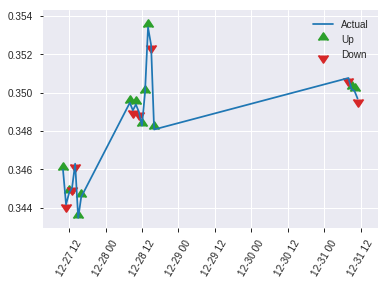


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1888841189021747
RMSE: 0.43460800602632105
LogLoss: 0.5550161564776184
Mean Per-Class Error: 0.2588073691014867
AUC: 0.7874111182934712
pr_auc: 0.7043661919184251
Gini: 0.5748222365869424
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38253888487815857: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      78   41   0.3445   (41.0/119.0)
1      18   86   0.1731   (18.0/104.0)
Total  96   127  0.2646   (59.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382539     0.744589  126
max f2                       0.222664     0.854922  162
max f0point5                 0.462984     0.718284  107
max accuracy                 0.462984     0.73991   107
max precision                0.921307     1         0
max recall                   0.113681     1         195
max specificity              0.921307     1         0
max absolute_mcc             0.382539     0.486012  126
max min_per_class_accuracy   0.462984     0.739496  107
max mean_per_class_accuracy  0.382539     0.741193  126

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 43.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.897859           2.14423   2.14423            1                0.915381   1                           0.915381            0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.858008           1.07212   1.71538            0.5              0.865001   0.8                         0.895229            0.00961538      0.0384615                  7.21154   71.5385
    3        0.0313901                   0.852432           1.07212   1.53159            0.5              0.855914   0.714286                    0.883996            0.00961538      0.0480769                  7.21154   53.1593
    4        0.0403587                   0.84339            2.14423   1.66774            1                0.848988   0.777778                    0.876216            0.0192308       0.0673077                  114.423   66.7735
    5        0.0538117                   0.830502           1.42949   1.60817            0.666667         0.838694   0.75                        0.866836            0.0192308       0.0865385                  42.9487   60.8173
    6        0.103139                    0.771736           1.55944   1.58487            0.727273         0.798522   0.73913                     0.834164            0.0769231       0.163462                   55.9441   58.4866
    7        0.152466                    0.716124           1.75437   1.63971            0.818182         0.742712   0.764706                    0.804576            0.0865385       0.25                       75.4371   63.9706
    8        0.201794                    0.687328           1.16958   1.52479            0.545455         0.701499   0.711111                    0.77938             0.0576923       0.307692                   16.958    52.4786
    9        0.300448                    0.616861           1.46198   1.50416            0.681818         0.645147   0.701493                    0.735303            0.144231        0.451923                   46.1976   50.4162
    10       0.399103                    0.539777           1.75437   1.56601            0.818182         0.57106    0.730337                    0.694704            0.173077        0.625                      75.4371   56.6011
    11       0.502242                    0.450152           1.11873   1.47416            0.521739         0.491225   0.6875                      0.652918            0.115385        0.740385                   11.8729   47.4159
    12       0.600897                    0.337125           0.877185  1.37615            0.409091         0.398835   0.641791                    0.611203            0.0865385       0.826923                   -12.2815  37.6148
    13       0.699552                    0.240946           0.97465   1.31953            0.454545         0.287968   0.615385                    0.565619            0.0961538       0.923077                   -2.53497  31.9527
    14       0.798206                    0.167075           0.487325  1.21667            0.227273         0.209502   0.567416                    0.521604            0.0480769       0.971154                   -51.2675  21.667
    15       0.896861                    0.100996           0.292395  1.115              0.136364         0.132424   0.52                        0.478794            0.0288462       1                          -70.7605  11.5
    16       1                           0.0504426          0         1                  0                0.0751156  0.466368                    0.4

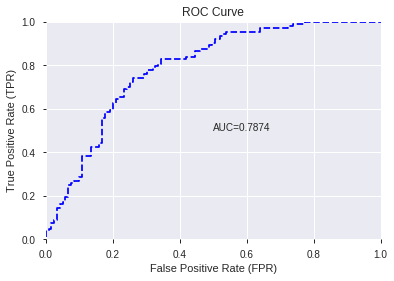

This function is available for GLM models only


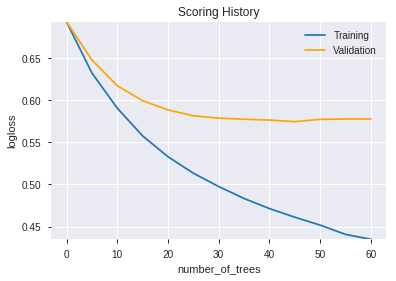

--2019-08-25 18:02:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.252
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.252|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(SharedTreeNode.java:207)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeLeftEdge(SharedTreeSubgraph.java:82)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeLeftChildN

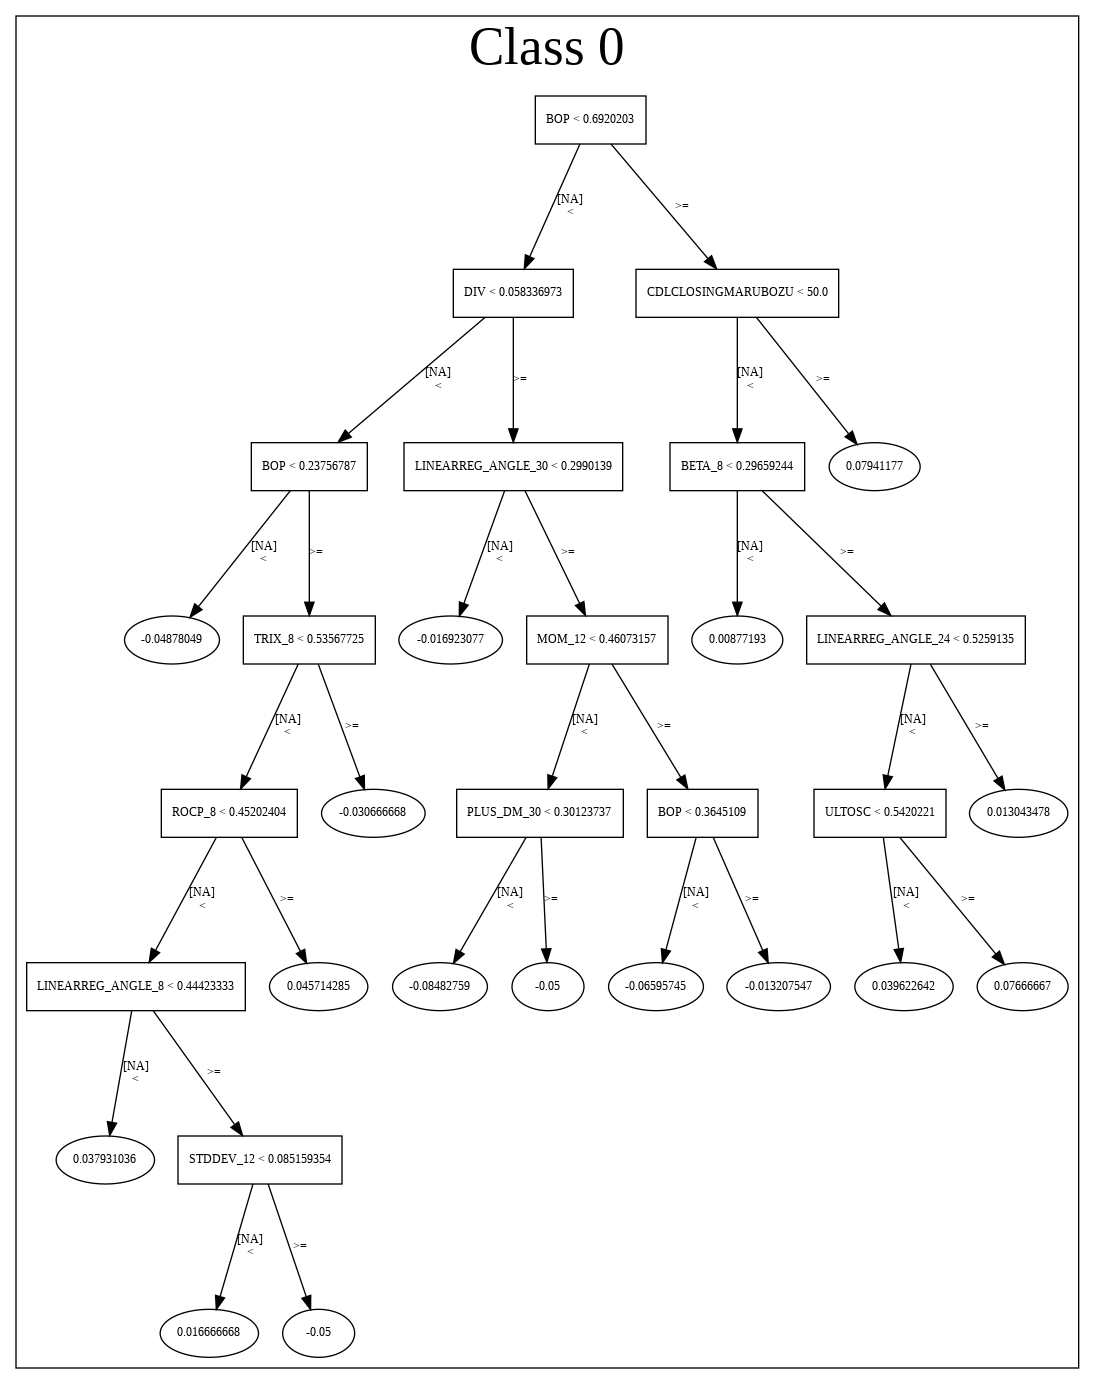

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_180154_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_180154_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a49b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'DIV',
 'STOCHF_fastk',
 'CCI_8',
 'WILLR_8',
 'TRANGE',
 'STOCHRSI_fastk',
 'hour',
 'MINUS_DM_8',
 'CCI_12',
 'CCI_14',
 'ADOSC',
 'STOCHRSI_fastd',
 'WILLR_14',
 'WILLR_12',
 'MOM_8',
 'ULTOSC',
 'STOCH_slowk',
 'WILLR_30',
 'CCI_30',
 'MINUS_DI_8',
 'CCI_20',
 'WILLR_20',
 'CMO_14',
 'CMO_20',
 'CCI_24',
 'ROC_8',
 'CDLCLOSINGMARUBOZU',
 'WILLR_24',
 'CDLLONGLINE',
 'CMO_24',
 'CMO_8',
 'CDLBELTHOLD',
 'RSI_24',
 'CMO_12',
 'STOCHF_fastd',
 'RSI_20',
 'RSI_8',
 'RSI_12',
 'RSI_14',
 'ROCP_8']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

52

['BBANDS_upperband_20_0_5',
 'BBANDS_upperband_20_3_3',
 'BBANDS_upperband_20_5_4',
 'BBANDS_middleband_24_0_2',
 'BBANDS_lowerband_30_5_5',
 'BOP',
 'AROONOSC_8',
 'CCI_8',
 'MFI_8',
 'ROC_8',
 'ROCP_8',
 'ROCR100_12',
 'WILLR_12',
 'aroondown_14',
 'aroonup_14',
 'CCI_14',
 'ROCR_14',
 'ROCR100_14',
 'WILLR_14',
 'aroonup_20',
 'PLUS_DI_20',
 'ROC_20',
 'ROCR_20',
 'WILLR_20',
 'aroonup_24',
 'CMO_24',
 'MFI_24',
 'MINUS_DM_24',
 'WILLR_24',
 'AROONOSC_30',
 'DX_30',
 'MFI_30',
 'WILLR_30',
 'MACDEXT_hist',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'ATR_12',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'CDLBELTHOLD',
 'CDLSHORTLINE',
 'BETA_12',
 'LINEARREG_ANGLE_12',
 'STDDEV_12',
 'BETA_14',
 'CORREL_14',
 'LINEARREG_ANGLE_14',
 'STDDEV_20']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_180312_model_8  0.763817  0.586240              0.291249  0.448962  0.201567
1  DeepLearning_grid_1_AutoML_20190825_180312_model_5  0.758969  0.606639              0.324782  0.453701  0.205845
2  DeepLearning_grid_1_AutoML_20190825_180312_model_4  0.758403  0.660464              0.321186  0.471186  0.222016
3  DeepLearning_grid_1_AutoML_20190825_180312_model_9  0.745071  0.588938              0.332579  0.450076  0.202569
4  DeepLearning_grid_1_AutoML_20190825_180312_model_6  0.743617  0.601616              0.355971  0.455028  0.207050
5  DeepLearning_grid_1_AutoML_20190825_180312_model_7  0.733193  0.838510              0.293673  0.514800  0.265019
6  DeepLearning_grid_1_AutoML_20190825_180312_model_3  0.733193  0.717307              0.352982  0.482338  0.232650
7  DeepLearning_grid_1_AutoML_20190825_180312_model_2  0.726164  0.793064              0.320661  0.502625  0.252632
8               DeepLearning_1_AutoML_20190825_180312  0.721962  0.635347              0.308662  0.464396  0.215664
9  DeepLearning_grid_1_AutoML_20190825_180312_model_1  0.718003  0.851889              0.382959  0.502770  0.252778

variable  relative_importance  scaled_importance  percentage
0                     TRANGE             1.000000           1.000000    0.046451
1                        BOP             0.949416           0.949416    0.044101
2                CDLBELTHOLD             0.538267           0.538267    0.025003
3                  CORREL_14             0.529290           0.529290    0.024586
4                 aroonup_14             0.528785           0.528785    0.024562
5                      ADOSC             0.499214           0.499214    0.023189
6               STOCHF_fastk             0.485144           0.485144    0.022535
7                 aroonup_24             0.482364           0.482364    0.022406
8                      DX_30             0.459854           0.459854    0.021360
9             STOCHRSI_fastk             0.449930           0.449930    0.020900
10                   BETA_12             0.447739           0.447739    0.020798
11                     CCI_8             0.447506           0.447506    0.020787
12              CDLSHORTLINE             0.446841           0.446841    0.020756
13                    ULTOSC             0.427441           0.427441    0.019855
14               AROONOSC_30             0.419882           0.419882    0.019504
15               MINUS_DM_24             0.414638           0.414638    0.019260
16                   BETA_14             0.413876           0.413876    0.019225
17                    ATR_12             0.410113           0.410113    0.019050
18                AROONOSC_8             0.409966           0.409966    0.019043
19                aroonup_20             0.403394           0.403394    0.018738
20                     MFI_8             0.402186           0.402186    0.018682
21               STOCH_slowk             0.398285           0.398285    0.018501
22                    CCI_14             0.396650           0.396650    0.018425
23              aroondown_14             0.385939           0.385939    0.017927
24                    MFI_30             0.385802           0.385802    0.017921
25              STOCHF_fastd             0.384918           0.384918    0.017880
26              MACDEXT_hist             0.381962           0.381962    0.017742
27      HT_PHASOR_quadrature             0.376681           0.376681    0.017497
28                 STDDEV_20             0.376172           0.376172    0.017473
29                 STDDEV_12             0.371177           0.371177    0.017241
30                  WILLR_30             0.370620           0.370620    0.017215
31   BBANDS_upperband_20_3_3             0.365098           0.365098    0.016959
32                   ROCR_20             0.364723           0.364723    0.016942
33                    ROCP_8             0.356667           0.356667    0.016567
34                     ROC_8             0.355810           0.355810    0.016528
35   BBANDS_upperband_20_0_5             0.352048           0.352048    0.016353
36  BBANDS_middleband_24_0_2             0.350694           0.350694    0.016290
37   BBANDS_lowerband_30_5_5             0.349527           0.349527    0.016236
38                  WILLR_20             0.347331           0.347331    0.016134
39                  WILLR_24             0.346256           0.346256    0.016084
40   BBANDS_upperband_20_5_4             0.345937           0.345937    0.016069
41                    ROC_20             0.341129           0.341129    0.015846
42                PLUS_DI_20             0.340373           0.340373    0.015811
43                    MFI_24             0.339461           0.339461    0.015768
44        LINEARREG_ANGLE_14             0.334327           0.334327    0.015530
45                  WILLR_12             0.329017           0.329017    0.015283
46                    CMO_24             0.328524           0.328524    0.015260
47                  WILLR_14             0.327520           0.327520    0.015214
48        LINEARREG_ANGLE_12             0.323439  

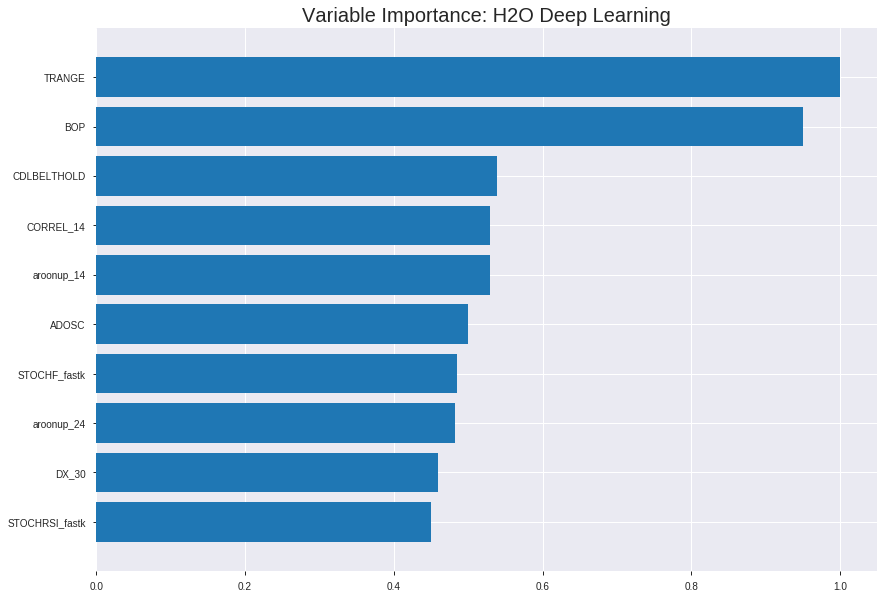

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_180312_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18398562930719664
RMSE: 0.428935460538292
LogLoss: 0.5415015315336188
Mean Per-Class Error: 0.2783313882155789
AUC: 0.7957908981789042
pr_auc: 0.7523586968647674
Gini: 0.5915817963578085
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37968997798832244: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      438  408   0.4823   (408.0/846.0)
1      77   634   0.1083   (77.0/711.0)
Total  515  1042  0.3115   (485.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37969      0.723331  246
max f2                       0.247152     0.837426  299
max f0point5                 0.606217     0.6984    122
max accuracy                 0.503959     0.719974  185
max precision                0.929726     1         0
max recall                   0.0371015    1         382
max specificity              0.929726     1         0
max absolute_mcc             0.501876     0.441668  186
max min_per_class_accuracy   0.512252     0.715893  180
max mean_per_class_accuracy  0.501876     0.721669  186

Gains/Lift Table: Avg response rate: 45.66 %, avg score: 46.26 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.884371           2.18987    2.18987            1                0.90565    1                           0.90565             0.0225035       0.0225035                  118.987   118.987
    2        0.0205523                   0.856563           1.91614    2.05301            0.875            0.865342   0.9375                      0.885496            0.0196906       0.0421941                  91.6139   105.301
    3        0.0301863                   0.836206           1.89789    2.0035             0.866667         0.84891    0.914894                    0.873819            0.0182841       0.0604782                  89.789    100.35
    4        0.0404624                   0.822066           2.05301    2.01607            0.9375           0.829615   0.920635                    0.862593            0.021097        0.0815752                  105.301   101.607
    5        0.0500963                   0.801379           2.04388    2.02142            0.933333         0.814152   0.923077                    0.853277            0.0196906       0.101266                   104.388   102.142
    6        0.100193                    0.75272            1.79682    1.90912            0.820513         0.776511   0.871795                    0.814894            0.0900141       0.19128                    79.6819   90.912
    7        0.150289                    0.712479           1.68452    1.83425            0.769231         0.730545   0.837607                    0.786778            0.0843882       0.275668                   68.4518   83.4253
    8        0.200385                    0.66521            1.40377    1.72663            0.641026         0.68803    0.788462                    0.762091            0.0703235       0.345992                   40.3765   72.6631
    9        0.299936                    0.604172           1.61062    1.68813            0.735484         0.633011   0.770878                    0.719249            0.160338        0.506329                   61.0617   68.8125
    10       0.400128                    0.550114           1.09494    1.53959            0.5              0.574225   0.70305                     0.682934            0.109705        0.616034                   9.49367   53.959
    11       0.500321                    0.50163            1.24935    1.48147            0.570513         0.527272   0.676508                    0.651762            0.125176        0.74121                    24.9351   48.1468
    12       0.599872                    0.435052           0.904206   1.38567            0.412903         0.469459   0.632762                    0.621508            0.0900141       0.831224                   -9.57942  38.5669
    13       0.700064                    0.35171            0.772071   1.29785            0.352564         0.396203   0.592661                    0.589263            0.0773558       0.908579                   -22.7929  29.7852
    14       0.799615                    0.226928           0.536872   1.20311            0.245161         0.294472   0.549398                    0.552562            0.0534459       0.962025                   -46.3128  20.3111
    15       0.899807                    0.097502           0.294791   1.10197            0.134615         0.164027   0.503212                    0.509299            0.0295359       0.991561                   -70.5209  10.1971
    16       1                           0.000116117        0.0842259  1                  0.0384615        0.0433569  0.456647    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19819304250365735
RMSE: 0.4451887717627853
LogLoss: 0.5773546608661787
Mean Per-Class Error: 0.2925887222358823
AUC: 0.755419637734612
pr_auc: 0.657991602706137
Gini: 0.5108392754692239
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4515782626693375: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      152  97   0.3896   (97.0/249.0)
1      39   157  0.199    (39.0/196.0)
Total  191  254  0.3056   (136.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451578     0.697778  224
max f2                       0.245713     0.836252  320
max f0point5                 0.508955     0.660646  189
max accuracy                 0.508955     0.703371  189
max precision                0.925155     1         0
max recall                   0.0159005    1         395
max specificity              0.925155     1         0
max absolute_mcc             0.460166     0.412705  214
max min_per_class_accuracy   0.514538     0.698795  187
max mean_per_class_accuracy  0.480226     0.707411  208

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 46.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.880902           1.36224   1.36224            0.6              0.903257   0.6                         0.903257            0.0153061       0.0153061                  36.2245   36.2245
    2        0.0202247                   0.84895            2.27041   1.76587            1                0.869942   0.777778                    0.888451            0.0204082       0.0357143                  127.041   76.5873
    3        0.0314607                   0.830705           1.81633   1.78389            0.8              0.8382     0.785714                    0.870504            0.0204082       0.0561224                  81.6327   78.3892
    4        0.0404494                   0.823292           1.1352    1.63974            0.5              0.829529   0.722222                    0.861398            0.0102041       0.0663265                  13.5204   63.9739
    5        0.0516854                   0.805514           2.27041   1.77684            1                0.812143   0.782609                    0.850691            0.0255102       0.0918367                  127.041   77.6841
    6        0.101124                    0.750285           1.44481   1.61451            0.636364         0.772454   0.711111                    0.812442            0.0714286       0.163265                   44.4805   61.4512
    7        0.150562                    0.70941            1.54801   1.59267            0.681818         0.732768   0.701493                    0.78628             0.0765306       0.239796                   54.8006   59.2674
    8        0.2                         0.660327           1.65121   1.60714            0.727273         0.685391   0.707865                    0.761341            0.0816327       0.321429                   65.1206   60.7143
    9        0.301124                    0.592609           1.31179   1.50796            0.577778         0.623376   0.664179                    0.71501             0.132653        0.454082                   31.1791   50.7958
    10       0.4                         0.541966           1.39321   1.47959            0.613636         0.565686   0.651685                    0.678098            0.137755        0.591837                   39.3205   47.9592
    11       0.501124                    0.502007           1.26134   1.43555            0.555556         0.523065   0.632287                    0.646813            0.127551        0.719388                   26.1338   43.555
    12       0.6                         0.435218           0.980404  1.36054            0.431818         0.464694   0.599251                    0.616801            0.0969388       0.816327                   -1.95965  36.0544
    13       0.698876                    0.357343           0.774003  1.27756            0.340909         0.396893   0.562701                    0.585689            0.0765306       0.892857                   -22.5997  27.7561
    14       0.8                         0.255015           0.756803  1.21173            0.333333         0.315988   0.533708                    0.551597            0.0765306       0.969388                   -24.3197  21.1735
    15       0.898876                    0.0882544          0.206401  1.10115            0.0909091        0.163483   0.485                       0.508905            0.0204082       0.989796                   -79.3599  10.1148
    16       1                           0.00406775         0.100907  1                  0.0444444        0.0459741  0.440449                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 18:09:25  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 18:09:27  1 min 13.119 sec  668 obs/sec       0.786769  1             1225       0.459623         0.610323            0.148588       0.734512        0.67411            1.91614          0.375723                         0.462797           0.617029              0.13095          0.717574          0.62936              1.81633            0.346067
    2019-08-25 18:09:39  1 min 24.686 sec  987 obs/sec       7.76814   10            12095      0.448232         0.589013            0.190265       0.761469        0.701492           1.91614          0.341683                         0.464273           0.630051              0.125397         0.734407          0.647725             1.81633            0.348315
    2019-08-25 18:09:50  1 min 36.514 sec  1105 obs/sec      16.255    21            25309      0.439372         0.566124            0.221959       0.775843        0.728871           2.05301          0.341683                         0.458335           0.607471              0.147626         0.740083          0.671302             2.27041            0.359551
    2019-08-25 18:10:03  1 min 48.884 sec  1132 obs/sec      24.8137   32            38635      0.428935         0.541502            0.258483       0.795791        0.752359           2.18987          0.311496                         0.445189           0.577355              0.19582          0.75542           0.657992             1.36224            0.305618
    2019-08-25 18:10:15  2 min  0.838 sec  1184 obs/sec      34.1843   44            53225      0.416814         0.513219            0.2998         0.817222        0.782468           2.18987          0.273603                         0.448327           0.586313              0.184441         0.752264          0.659561             1.81633            0.330337
    2019-08-25 18:10:26  2 min 12.614 sec  1217 obs/sec      43.4836   56            67704      0.411749         0.500022            0.316715       0.823674        0.789741           2.18987          0.28966                          0.457195           0.622325              0.151858         0.743095          0.650941             2.27041            0.361798
    2019-08-25 18:10:38  2 min 24.459 sec  1259 obs/sec      53.648    69            83530      0.401972         0.478617            0.348778       0.841649        0.815016           2.18987          0.252408                         0.453127           0.603171              0.166886         0.752653          0.660098             1.81633            0.305618
    2019-08-25 18:10:39  2 min 25.610 sec  1259 obs/sec      53.648    69            83530      0.428935         0.541502            0.258483       0.795791        0.752359           2.18987          0.311496                         0.445189           0.577355              0.19582          0.75542           0.657992             1.36224            0.305618

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
TRANGE              1.0                    1.0                  0.04645055699362067
BOP                 0.9494155645370483     0.9494155645370483   0.0441008817911587
CDLBELTHOLD         0.5382674932479858     0.5382674932479858   0.025002824872928892
CORREL_14           0.5292904376983643     0.5292904376983643   0.024585835642486297
aroonup_14          0.5287848711013794     0.5287848711013794   0.02456235179245898
---                 ---                    ---                  ---
WILLR_14            0.3275204300880432     0.3275204300880432   0.015213506404379804
LINEARREG_ANGLE_12  0.32343918085098267    0.32343918085098267  0.015023930104088552
ROCR100_14          0.32176902890205383    0.32176902890205383  0.014946350615796827
ROCR_14             0.30780312418937683    0.30780312418937683  0.014297626562973148
ROCR100_12          0.30675646662712097    0.30675646662712097  0.014249008736224778


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7130044843049327)

('F1', 0.7105263157894737)

('auc', 0.7638170652876536)

('logloss', 0.5862400716477498)

('mean_per_class_error', 0.2882595345830641)

('rmse', 0.4489618196704951)

('mse', 0.20156671552184216)

deeplearning prediction progress: |███████████████████████████████████████| 100%


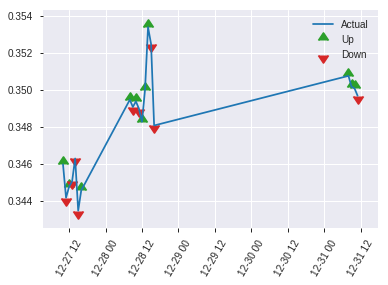


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20156671552184216
RMSE: 0.4489618196704951
LogLoss: 0.5862400716477498
Mean Per-Class Error: 0.2882595345830641
AUC: 0.7638170652876536
pr_auc: 0.6849480564889976
Gini: 0.5276341305753072
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.529252097854635: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   43   0.3613   (43.0/119.0)
1      23   81   0.2212   (23.0/104.0)
Total  99   124  0.296    (66.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.529252     0.710526  123
max f2                       0.317625     0.848586  184
max f0point5                 0.663063     0.697368  68
max accuracy                 0.60039      0.713004  97
max precision                0.929251     1         0
max recall                   0.23134      1         200
max specificity              0.929251     1         0
max absolute_mcc             0.53926      0.423481  118
max min_per_class_accuracy   0.58197      0.697479  108
max mean_per_class_accuracy  0.53926      0.71174   118

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 53.41 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.893663           2.14423    2.14423            1                0.906914  1                           0.906914            0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.87636            1.07212    1.71538            0.5              0.884385  0.8                         0.897902            0.00961538      0.0384615                  7.21154   71.5385
    3        0.0313901                   0.866393           2.14423    1.83791            1                0.872195  0.857143                    0.890557            0.0192308       0.0576923                  114.423   83.7912
    4        0.0403587                   0.850224           1.07212    1.66774            0.5              0.859852  0.777778                    0.883734            0.00961538      0.0673077                  7.21154   66.7735
    5        0.0538117                   0.847233           0.714744   1.42949            0.333333         0.848582  0.666667                    0.874946            0.00961538      0.0769231                  -28.5256  42.9487
    6        0.103139                    0.799              1.55944    1.49164            0.727273         0.823347  0.695652                    0.850268            0.0769231       0.153846                   55.9441   49.1639
    7        0.152466                    0.764174           1.36451    1.45051            0.636364         0.78004   0.676471                    0.827547            0.0673077       0.221154                   36.451    45.0509
    8        0.201794                    0.73854            1.9493     1.57244            0.909091         0.749708  0.733333                    0.80852             0.0961538       0.317308                   94.9301   57.2436
    9        0.300448                    0.668815           1.75437    1.63218            0.818182         0.704223  0.761194                    0.774273            0.173077        0.490385                   75.4371   63.2176
    10       0.399103                    0.608899           1.16958    1.51783            0.545455         0.634952  0.707865                    0.739834            0.115385        0.605769                   16.958    51.7826
    11       0.502242                    0.55853            1.0255     1.41672            0.478261         0.592456  0.660714                    0.709569            0.105769        0.711538                   2.55017   41.6724
    12       0.600897                    0.501892           0.97465    1.34414            0.454545         0.529714  0.626866                    0.680041            0.0961538       0.807692                   -2.53497  34.4145
    13       0.699552                    0.436218           0.682255   1.2508             0.318182         0.469904  0.583333                    0.650406            0.0673077       0.875                      -31.7745  25.0801
    14       0.798206                    0.338219           0.77972    1.19258            0.363636         0.386629  0.55618                     0.617804            0.0769231       0.951923                   -22.028   19.2578
    15       0.896861                    0.232823           0.38986    1.10428            0.181818         0.293699  0.515                       0.582153            0.0384615       0.990385                   -61.014   10.4279
    16       1                           0.00598371         0.0932274  1                  0.0434783        0.116454  0.466368                   

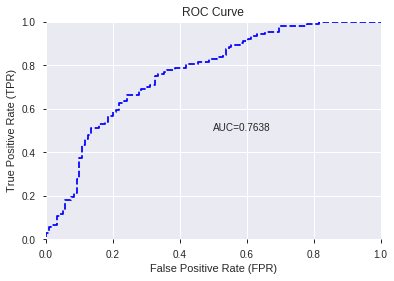

This function is available for GLM models only


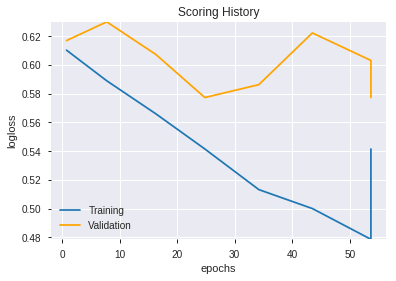

--2019-08-25 18:11:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


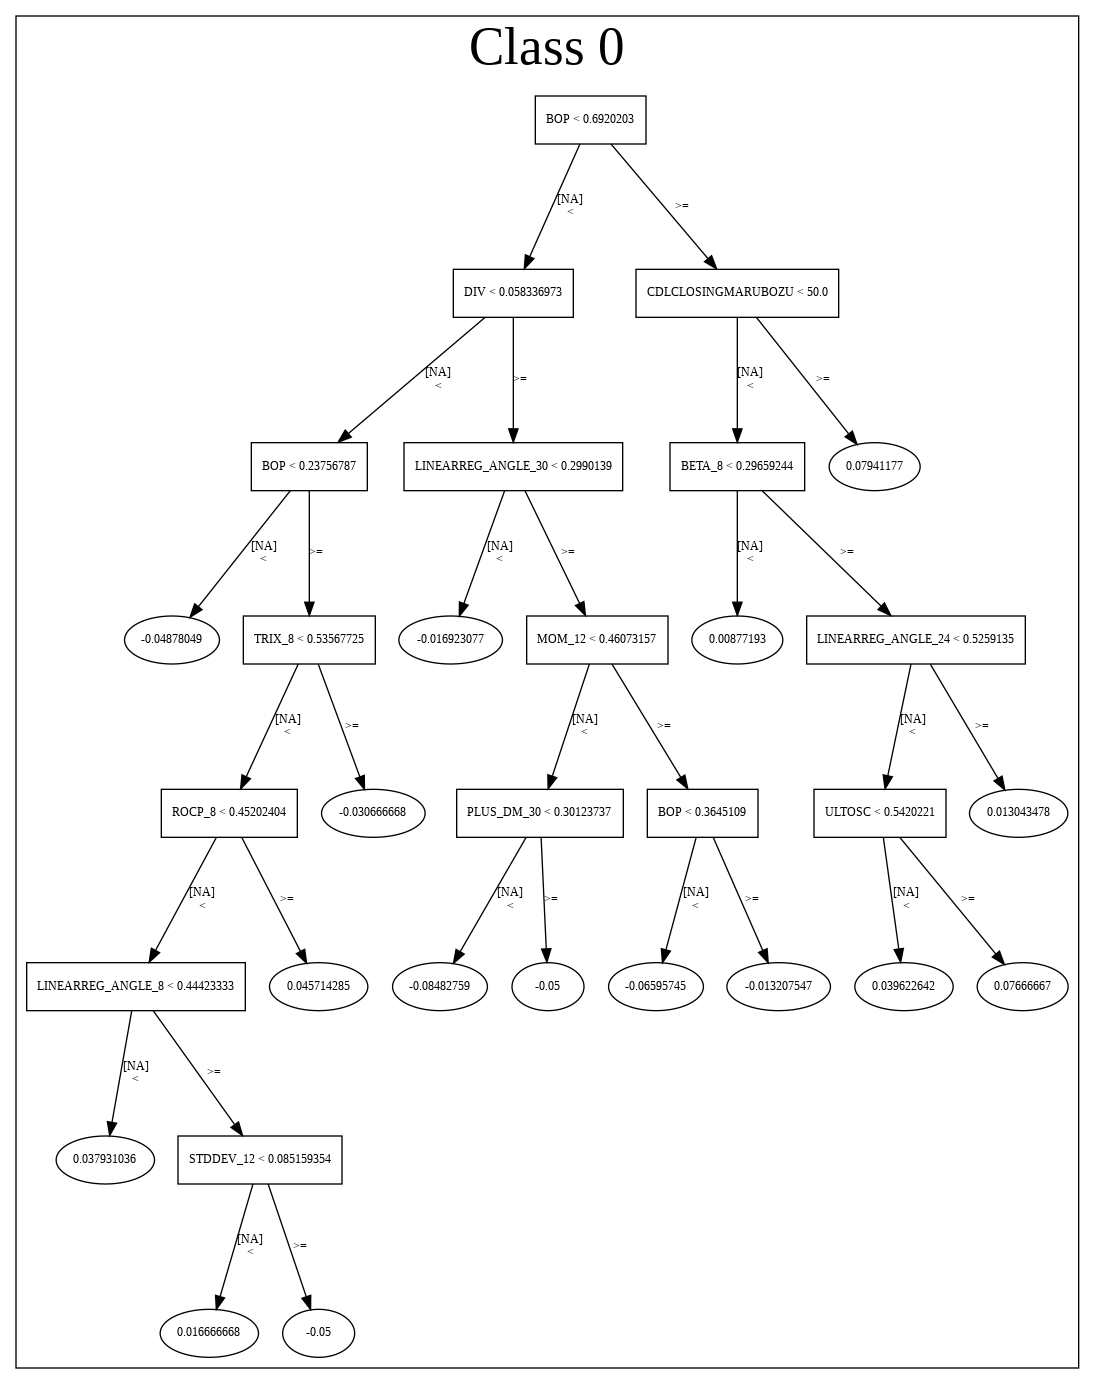

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_180312_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_180312_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a49b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'BOP',
 'CDLBELTHOLD',
 'CORREL_14',
 'aroonup_14',
 'ADOSC',
 'STOCHF_fastk',
 'aroonup_24',
 'DX_30',
 'STOCHRSI_fastk',
 'BETA_12',
 'CCI_8',
 'CDLSHORTLINE',
 'ULTOSC',
 'AROONOSC_30',
 'MINUS_DM_24',
 'BETA_14',
 'ATR_12',
 'AROONOSC_8',
 'aroonup_20',
 'MFI_8',
 'STOCH_slowk',
 'CCI_14',
 'aroondown_14',
 'MFI_30',
 'STOCHF_fastd',
 'MACDEXT_hist',
 'HT_PHASOR_quadrature',
 'STDDEV_20',
 'STDDEV_12',
 'WILLR_30',
 'BBANDS_upperband_20_3_3',
 'ROCR_20',
 'ROCP_8',
 'ROC_8',
 'BBANDS_upperband_20_0_5',
 'BBANDS_middleband_24_0_2',
 'BBANDS_lowerband_30_5_5',
 'WILLR_20',
 'WILLR_24',
 'BBANDS_upperband_20_5_4',
 'ROC_20',
 'PLUS_DI_20',
 'MFI_24',
 'LINEARREG_ANGLE_14',
 'WILLR_12',
 'CMO_24',
 'WILLR_14',
 'LINEARREG_ANGLE_12',
 'ROCR100_14',
 'ROCR_14',
 'ROCR100_12']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_181206_model_1  0.755171  0.58611              0.300824  0.448517  0.201167

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.759584           1.000000    0.144278
1                     TRANGE             0.496609           0.653791    0.094328
2               STOCHF_fastk             0.290421           0.382343    0.055164
3                      ADOSC             0.234212           0.308343    0.044487
4                     CCI_14             0.201203           0.264885    0.038217
5                   WILLR_30             0.191753           0.252445    0.036422
6         LINEARREG_ANGLE_14             0.160219           0.210930    0.030433
7                     ROCP_8             0.158808           0.209072    0.030164
8                      ROC_8             0.158724           0.208961    0.030149
9                    BETA_14             0.155012           0.204074    0.029443
10                     CCI_8             0.153213           0.201706    0.029102
11                   BETA_12             0.135271           0.178086    0.025694
12                    ULTOSC             0.130465           0.171758    0.024781
13                aroonup_14             0.124921           0.164460    0.023728
14              CDLSHORTLINE             0.123777           0.162953    0.023511
15                 STDDEV_12             0.120380           0.158482    0.022865
16              STOCHF_fastd             0.118931           0.156574    0.022590
17               STOCH_slowk             0.118765           0.156355    0.022559
18        LINEARREG_ANGLE_12             0.115911           0.152598    0.022017
19                     MFI_8             0.107784           0.141898    0.020473
20                  WILLR_14             0.102900           0.135469    0.019545
21                 CORREL_14             0.085297           0.112295    0.016202
22                 STDDEV_20             0.084588           0.111361    0.016067
23   BBANDS_upperband_20_3_3             0.075284           0.099112    0.014300
24                  WILLR_24             0.068342           0.089973    0.012981
25                    MFI_30             0.065964           0.086843    0.012530
26   BBANDS_lowerband_30_5_5             0.059785           0.078708    0.011356
27               MINUS_DM_24             0.059197           0.077933    0.011244
28                    ATR_12             0.058716           0.077300    0.011153
29                    CMO_24             0.054468           0.071707    0.010346
30                  WILLR_20             0.053752           0.070766    0.010210
31                   ROCR_20             0.042093           0.055416    0.007995
32               AROONOSC_30             0.042022           0.055322    0.007982
33                    ROC_20             0.040359           0.053134    0.007666
34      HT_PHASOR_quadrature             0.038460           0.050633    0.007305
35                aroonup_20             0.037132           0.048884    0.007053
36              aroondown_14             0.030301           0.039892    0.005756
37                  WILLR_12             0.028131           0.037035    0.005343
38   BBANDS_upperband_20_5_4             0.026032           0.034272    0.004945
39                    MFI_24             0.023340           0.030727    0.004433
40   BBANDS_upperband_20_0_5             0.021381           0.028149    0.004061
41                AROONOSC_8             0.018854           0.024821    0.003581
42                ROCR100_14             0.017520           0.023065    0.003328
43              MACDEXT_hist             0.016417           0.021613    0.003118
44                   ROCR_14             0.015747           0.020731    0.002991
45  BBANDS_middleband_24_0_2             0.015640           0.020590    0.002971
46            STOCHRSI_fastk             0.007505           0.009881    0.001426
47                ROCR100_12             0.006377           0.008396    0.001211
48               CDLBELTHOLD             0.005801  

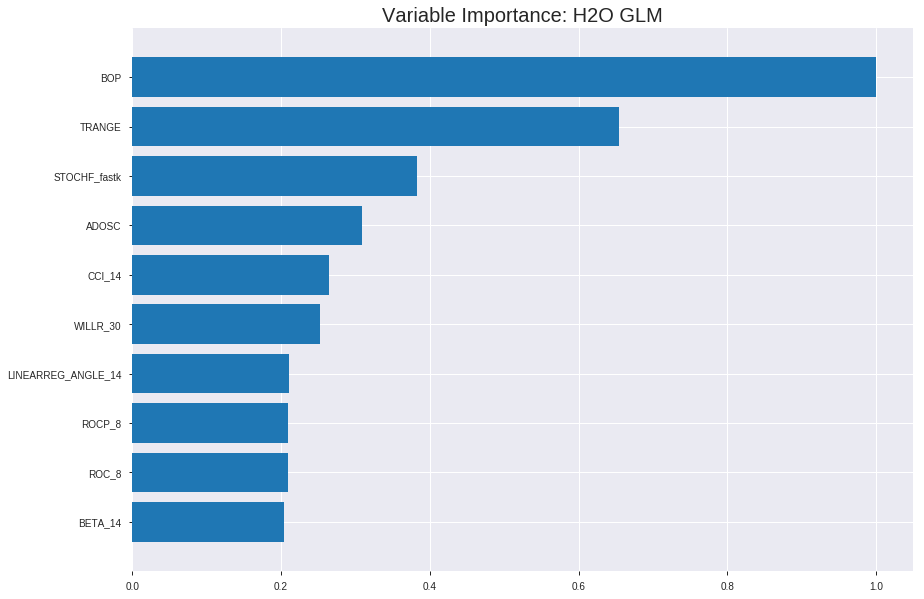

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_181206_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19383310223158143
RMSE: 0.4402648092132523
LogLoss: 0.5698162291034272
Null degrees of freedom: 1556
Residual degrees of freedom: 1504
Null deviance: 2146.7404074571314
Residual deviance: 1774.4077374280723
AIC: 1880.4077374280723
AUC: 0.7713123393615359
pr_auc: 0.7158382345110013
Gini: 0.5426246787230717
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3610428958003788: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      465  381  0.4504   (381.0/846.0)
1      112  599  0.1575   (112.0/711.0)
Total  577  980  0.3166   (493.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.361043     0.708457  252
max f2                       0.197458     0.825523  332
max f0point5                 0.485298     0.683891  184
max accuracy                 0.485298     0.712267  184
max precision                0.945748     1         0
max recall                   0.0455916    1         392
max specificity              0.945748     1         0
max absolute_mcc             0.485298     0.421305  184
max min_per_class_accuracy   0.476633     0.70922   189
max mean_per_class_accuracy  0.469091     0.711232  193

Gains/Lift Table: Avg response rate: 45.66 %, avg score: 45.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.852349           2.05301   2.05301            0.9375           0.885262  0.9375                      0.885262            0.021097        0.021097                   105.301   105.301
    2        0.0205523                   0.838771           2.05301   2.05301            0.9375           0.846137  0.9375                      0.865699            0.021097        0.0421941                  105.301   105.301
    3        0.0301863                   0.823048           1.60591   1.91032            0.733333         0.831602  0.87234                     0.854817            0.0154712       0.0576653                  60.5907   91.0315
    4        0.0404624                   0.810956           1.50554   1.80751            0.6875           0.816099  0.825397                    0.844984            0.0154712       0.0731364                  50.5538   80.7515
    5        0.0500963                   0.794907           1.7519    1.79682            0.8              0.80293   0.820513                    0.836897            0.0168776       0.0900141                  75.1899   79.6819
    6        0.100193                    0.748823           1.68452   1.74067            0.769231         0.768408  0.794872                    0.802652            0.0843882       0.174402                   68.4518   74.0669
    7        0.150289                    0.709818           1.71259   1.73131            0.782051         0.729317  0.790598                    0.778207            0.0857947       0.260197                   71.2593   73.131
    8        0.200385                    0.676364           1.51607   1.6775             0.692308         0.693205  0.766026                    0.756957            0.0759494       0.336146                   51.6066   67.7499
    9        0.299936                    0.609134           1.44108   1.59903            0.658065         0.64156   0.730193                    0.718656            0.14346         0.479606                   44.1078   59.903
    10       0.400128                    0.543816           1.31954   1.52904            0.602564         0.575978  0.698234                    0.682929            0.132208        0.611814                   31.9539   52.9045
    11       0.500321                    0.462724           1.16512   1.45617            0.532051         0.500376  0.664955                    0.646372            0.116737        0.728551                   16.5125   45.6167
    12       0.599872                    0.381607           0.847693  1.35519            0.387097         0.419985  0.618844                    0.608802            0.0843882       0.81294                    -15.2307  35.5189
    13       0.700064                    0.310582           0.729958  1.26571            0.333333         0.346046  0.577982                    0.571197            0.0731364       0.886076                   -27.0042  26.5707
    14       0.799615                    0.236503           0.579257  1.18025            0.264516         0.273603  0.538956                    0.534147            0.0576653       0.943741                   -42.0743  18.0245
    15       0.899807                    0.153147           0.336904  1.08634            0.153846         0.193487  0.496074                    0.496215            0.0337553       0.977496                   -66.3096  8.63398
    16       1                           0.00176573         0.224602  1                  0.102564         0.101302  0.456647                    0.456647           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19997235651622186
RMSE: 0.44718268807750355
LogLoss: 0.5808814013205005
Null degrees of freedom: 444
Residual degrees of freedom: 392
Null deviance: 611.0451593654886
Residual deviance: 516.9844471752455
AIC: 622.9844471752455
AUC: 0.7495901975247931
pr_auc: 0.6676984794764821
Gini: 0.4991803950495861
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3332138524071584: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      132  117  0.4699   (117.0/249.0)
1      30   166  0.1531   (30.0/196.0)
Total  162  283  0.3303   (147.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.333214     0.693111  251
max f2                       0.194461     0.835498  327
max f0point5                 0.503664     0.662393  167
max accuracy                 0.503664     0.701124  167
max precision                0.893174     1         0
max recall                   0.0266243    1         398
max specificity              0.893174     1         0
max absolute_mcc             0.40777      0.405038  215
max min_per_class_accuracy   0.459066     0.688776  187
max mean_per_class_accuracy  0.40777      0.703016  215

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 43.37 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.848588           2.27041    2.27041            1                0.873592   1                           0.873592            0.0255102       0.0255102                  127.041   127.041
    2        0.0202247                   0.839795           2.27041    2.27041            1                0.842428   1                           0.859741            0.0204082       0.0459184                  127.041   127.041
    3        0.0314607                   0.818432           1.36224    1.94606            0.6              0.827506   0.857143                    0.848229            0.0153061       0.0612245                  36.2245   94.6064
    4        0.0404494                   0.801821           1.70281    1.89201            0.75             0.80719    0.833333                    0.839109            0.0153061       0.0765306                  70.2806   89.2007
    5        0.0516854                   0.782953           1.81633    1.87555            0.8              0.793515   0.826087                    0.829197            0.0204082       0.0969388                  81.6327   87.5555
    6        0.101124                    0.716189           1.3416     1.61451            0.590909         0.737633   0.711111                    0.784433            0.0663265       0.163265                   34.1605   61.4512
    7        0.150562                    0.675695           1.85761    1.69433            0.818182         0.698218   0.746269                    0.756124            0.0918367       0.255102                   85.7607   69.4334
    8        0.2                         0.644023           0.928803   1.5051             0.409091         0.65936    0.662921                    0.732204            0.0459184       0.30102                    -7.11967  50.5102
    9        0.301124                    0.567433           1.4127     1.47407            0.622222         0.605379   0.649254                    0.689614            0.142857        0.443878                   41.2698   47.4071
    10       0.4                         0.516175           1.59961    1.5051             0.704545         0.540441   0.662921                    0.65274             0.158163        0.602041                   59.9606   50.5102
    11       0.501124                    0.440296           1.05952    1.41519            0.466667         0.475802   0.623318                    0.617035            0.107143        0.709184                   5.95238   41.5187
    12       0.6                         0.358049           1.0836     1.36054            0.477273         0.401871   0.599251                    0.581577            0.107143        0.816327                   8.36039   36.0544
    13       0.698876                    0.296094           0.567602   1.24836            0.25             0.327318   0.549839                    0.545605            0.0561224       0.872449                   -43.2398  24.8359
    14       0.8                         0.228404           0.756803   1.18622            0.333333         0.261417   0.522472                    0.509682            0.0765306       0.94898                    -24.3197  18.6224
    15       0.898876                    0.132662           0.464402   1.10682            0.204545         0.17968    0.4875                      0.473382            0.0459184       0.994898                   -53.5598  10.6824
    16       1                           0.00736097         0.0504535  1                  0.0222222        0.0808157  0.440449 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-25 18:12:07  0.000 sec   2            .2E2      53            1.3629409283385403  1.3571157850755722
     2019-08-25 18:12:07  0.010 sec   4            .12E2     53            1.3554736422362388  1.3498268039549448
     2019-08-25 18:12:07  0.021 sec   6            .76E1     53            1.3454998010805785  1.340305345665052
     2019-08-25 18:12:07  0.030 sec   8            .47E1     53            1.3326755385956928  1.3283473963942363
     2019-08-25 18:12:07  0.040 sec   10           .29E1     53            1.3168139164108634  1.3137660862351703
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-25 18:12:07  0.185 sec   36           .6E-2     53            1.1379968744625404  1.1620346696873205
     2019-08-25 18:12:07  0.195 sec   38           .37E-2    53            1.1370505860402582  1.1627180735593048
     2019-08-25 18:12:07  0.205 sec   40           .23E-2    53            1.136486794224234   1.1634262163650708
     2019-08-25 18:12:07  0.211 sec   41           .14E-2    53            1.1361311396711546  1.1639985182471686
     2019-08-25 18:12:07  0.217 sec   42           .9E-3     53            1.1358741995962285  1.1643458928842205


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7130044843049327)

('F1', 0.7136929460580912)

('auc', 0.7551712992889463)

('logloss', 0.5861095115636994)

('mean_per_class_error', 0.28765352294764057)

('rmse', 0.4485166385045017)

('mse', 0.20116717501537784)

glm prediction progress: |████████████████████████████████████████████████| 100%


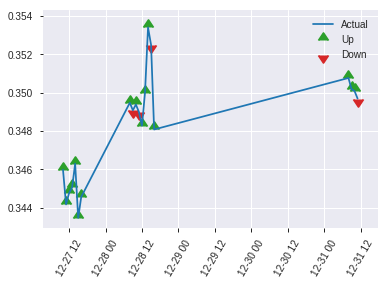


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20116717501537784
RMSE: 0.4485166385045017
LogLoss: 0.5861095115636994
Null degrees of freedom: 222
Residual degrees of freedom: 170
Null deviance: 308.21873965260795
Residual deviance: 261.40484215741
AIC: 367.40484215741
AUC: 0.7551712992889463
pr_auc: 0.6739450645107454
Gini: 0.5103425985778927
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44276643380017455: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   51   0.4286   (51.0/119.0)
1      18   86   0.1731   (18.0/104.0)
Total  86   137  0.3094   (69.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442766     0.713693  136
max f2                       0.26596      0.843072  182
max f0point5                 0.567863     0.692308  103
max accuracy                 0.567863     0.713004  103
max precision                0.885961     1         0
max recall                   0.192006     1         201
max specificity              0.885961     1         0
max absolute_mcc             0.508872     0.425278  120
max min_per_class_accuracy   0.567863     0.692308  103
max mean_per_class_accuracy  0.508872     0.712346  120

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 51.35 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.862521           1.42949    1.42949            0.666667         0.875278  0.666667                    0.875278            0.0192308       0.0192308                  42.9487   42.9487
    2        0.0224215                   0.839994           2.14423    1.71538            1                0.842996  0.8                         0.862365            0.0192308       0.0384615                  114.423   71.5385
    3        0.0313901                   0.829199           1.07212    1.53159            0.5              0.833985  0.714286                    0.854256            0.00961538      0.0480769                  7.21154   53.1593
    4        0.0403587                   0.820719           2.14423    1.66774            1                0.828203  0.777778                    0.848467            0.0192308       0.0673077                  114.423   66.7735
    5        0.0538117                   0.816888           1.42949    1.60817            0.666667         0.818697  0.75                        0.841024            0.0192308       0.0865385                  42.9487   60.8173
    6        0.103139                    0.798799           1.55944    1.58487            0.727273         0.808775  0.73913                     0.825601            0.0769231       0.163462                   55.9441   58.4866
    7        0.152466                    0.765125           1.16958    1.45051            0.545455         0.780609  0.676471                    0.811045            0.0576923       0.221154                   16.958    45.0509
    8        0.201794                    0.727794           1.9493     1.57244            0.909091         0.750231  0.733333                    0.796179            0.0961538       0.317308                   94.9301   57.2436
    9        0.300448                    0.689432           1.36451    1.50416            0.636364         0.707596  0.701493                    0.767092            0.134615        0.451923                   36.451    50.4162
    10       0.399103                    0.621547           1.26705    1.44555            0.590909         0.650207  0.674157                    0.738199            0.125           0.576923                   26.7045   44.5549
    11       0.502242                    0.551408           1.30518    1.41672            0.608696         0.578805  0.660714                    0.705466            0.134615        0.711538                   30.5184   41.6724
    12       0.600897                    0.449952           0.97465    1.34414            0.454545         0.504197  0.626866                    0.672422            0.0961538       0.807692                   -2.53497  34.4145
    13       0.699552                    0.363783           0.77972    1.26455            0.363636         0.405451  0.589744                    0.634772            0.0769231       0.884615                   -22.028   26.4546
    14       0.798206                    0.285037           0.682255   1.19258            0.318182         0.325441  0.55618                     0.59654             0.0673077       0.951923                   -31.7745  19.2578
    15       0.896861                    0.205411           0.38986    1.10428            0.181818         0.242623  0.515                       0.55761             0.0384615       0.990385                   -61.014   10.4279
    16       1                           0.0407627          0.0932274  1                  0.0434783        0.130066  0.466368                   

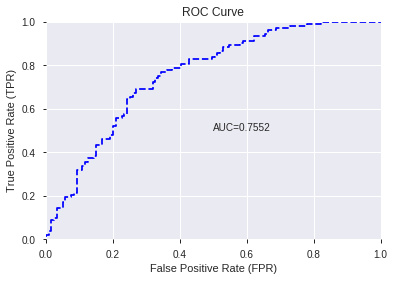

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


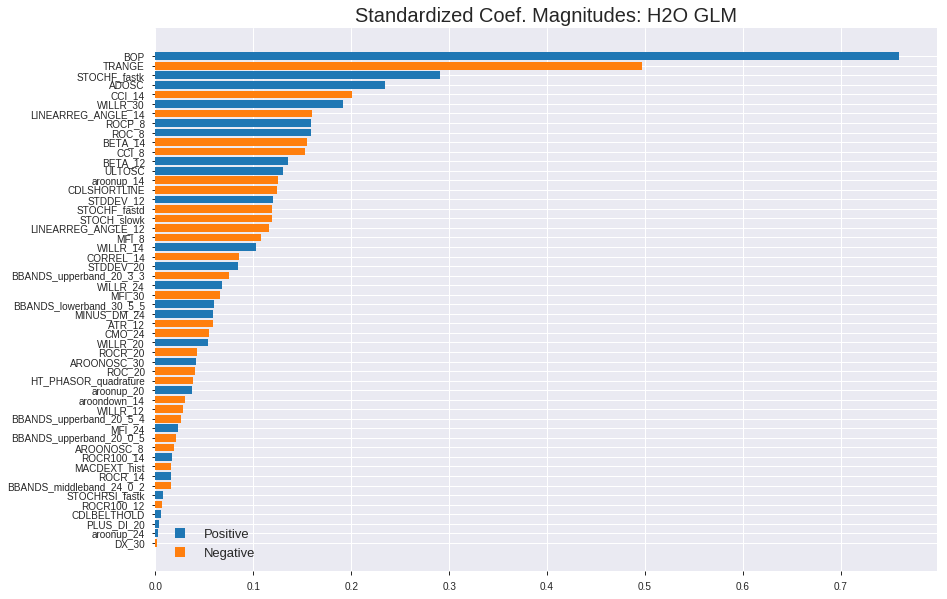

'log_likelihood'
--2019-08-25 18:12:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.147.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.147.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


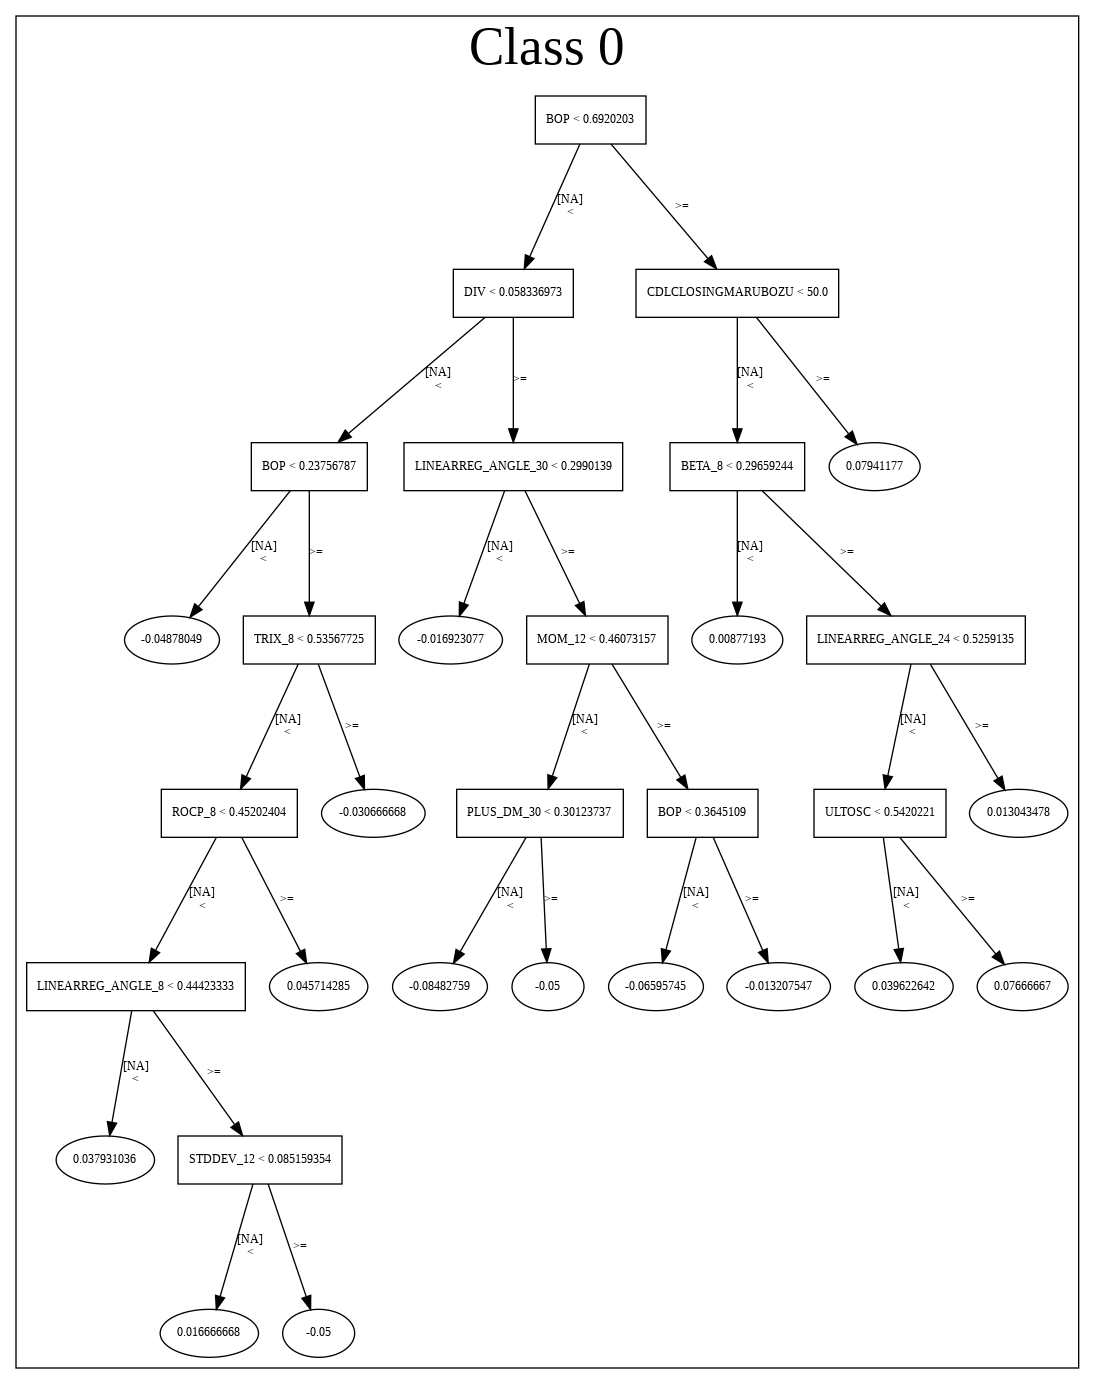

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_181206_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_181206_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a49b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'ADOSC',
 'CCI_14',
 'WILLR_30',
 'LINEARREG_ANGLE_14',
 'ROCP_8',
 'ROC_8',
 'BETA_14',
 'CCI_8',
 'BETA_12',
 'ULTOSC',
 'aroonup_14',
 'CDLSHORTLINE',
 'STDDEV_12',
 'STOCHF_fastd',
 'STOCH_slowk',
 'LINEARREG_ANGLE_12',
 'MFI_8',
 'WILLR_14',
 'CORREL_14',
 'STDDEV_20',
 'BBANDS_upperband_20_3_3',
 'WILLR_24',
 'MFI_30',
 'BBANDS_lowerband_30_5_5',
 'MINUS_DM_24',
 'ATR_12',
 'CMO_24',
 'WILLR_20',
 'ROCR_20',
 'AROONOSC_30',
 'ROC_20',
 'HT_PHASOR_quadrature',
 'aroonup_20',
 'aroondown_14',
 'WILLR_12',
 'BBANDS_upperband_20_5_4',
 'MFI_24',
 'BBANDS_upperband_20_0_5',
 'AROONOSC_8',
 'ROCR100_14',
 'MACDEXT_hist',
 'ROCR_14',
 'BBANDS_middleband_24_0_2',
 'STOCHRSI_fastk',
 'ROCR100_12',
 'CDLBELTHOLD',
 'PLUS_DI_20',
 'aroonup_24',
 'DX_30']

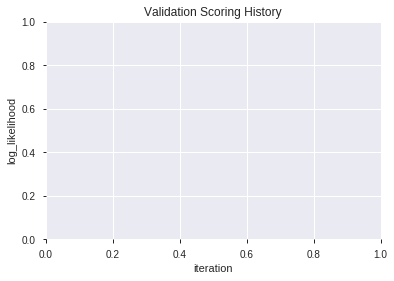

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_181218_model_3  0.800178  0.545139              0.273150  0.427911  0.183108
1               XGBoost_1_AutoML_20190825_181218  0.789108  0.551488              0.284583  0.431858  0.186501
2  XGBoost_grid_1_AutoML_20190825_181218_model_1  0.787088  0.550827              0.269594  0.432746  0.187269
3               XGBoost_2_AutoML_20190825_181218  0.787007  0.555205              0.298360  0.433525  0.187944
4               XGBoost_3_AutoML_20190825_181218  0.786684  0.558359              0.286967  0.434964  0.189193
5  XGBoost_grid_1_AutoML_20190825_181218_model_2  0.784664  0.580606              0.280381  0.443367  0.196574
6  XGBoost_grid_1_AutoML_20190825_181218_model_5  0.782725  0.577359              0.300784  0.442719  0.196000
7  XGBoost_grid_1_AutoML_20190825_181218_model_7  0.779897  0.560709              0.297148  0.436047  0.190137
8  XGBoost_grid_1_AutoML_20190825_181218_model_4  0.779089  0.564336              0.291128  0.437077  0.191036
9  XGBoost_grid_1_AutoML_20190825_181218_model_6  0.776988  0.562189              0.299531  0.437140  0.191092

variable  relative_importance  scaled_importance  percentage
0                        BOP          1414.372070           1.000000    0.181520
1                     TRANGE           786.004822           0.555727    0.100876
2               STOCHF_fastk           562.183899           0.397479    0.072151
3                      CCI_8           325.473633           0.230119    0.041771
4             STOCHRSI_fastk           213.952866           0.151271    0.027459
5                   WILLR_12           211.488037           0.149528    0.027142
6                     ATR_12           184.592880           0.130512    0.023691
7                     MFI_30           178.583237           0.126263    0.022919
8                STOCH_slowk           170.171844           0.120316    0.021840
9       HT_PHASOR_quadrature           156.360657           0.110551    0.020067
10                    CCI_14           152.436020           0.107776    0.019564
11                    ROC_20           147.463837           0.104261    0.018925
12                   BETA_14           146.608856           0.103656    0.018816
13                 STDDEV_20           133.423767           0.094334    0.017124
14                    ULTOSC           131.920029           0.093271    0.016931
15                     MFI_8           129.601776           0.091632    0.016633
16                    MFI_24           127.872513           0.090409    0.016411
17                     ADOSC           119.226509           0.084296    0.015302
18                     ROC_8           118.855881           0.084034    0.015254
19               MINUS_DM_24           117.831825           0.083310    0.015123
20                   ROCR_14           113.541458           0.080277    0.014572
21                PLUS_DI_20           109.614754           0.077501    0.014068
22              MACDEXT_hist           108.788116           0.076916    0.013962
23                   BETA_12           105.750084           0.074768    0.013572
24   BBANDS_lowerband_30_5_5           105.170799           0.074359    0.013498
25                     DX_30           102.088600           0.072179    0.013102
26                 STDDEV_12            94.894150           0.067093    0.012179
27                   ROCR_20            89.822220           0.063507    0.011528
28   BBANDS_upperband_20_5_4            84.796471           0.059953    0.010883
29   BBANDS_upperband_20_0_5            82.832703           0.058565    0.010631
30                 CORREL_14            82.426804           0.058278    0.010579
31                aroonup_14            82.306778           0.058193    0.010563
32                  WILLR_14            80.388588           0.056837    0.010317
33               CDLBELTHOLD            80.387619           0.056836    0.010317
34  BBANDS_middleband_24_0_2            78.928101           0.055804    0.010130
35              aroondown_14            73.237442           0.051781    0.009399
36                  WILLR_20            71.612846           0.050632    0.009191
37               AROONOSC_30            71.406876           0.050487    0.009164
38                  WILLR_30            70.420357           0.049789    0.009038
39        LINEARREG_ANGLE_14            68.056076           0.048118    0.008734
40                AROONOSC_8            66.568794           0.047066    0.008543
41                ROCR100_12            64.096100           0.045318    0.008226
42                    CMO_24            58.286476           0.041210    0.007480
43   BBANDS_upperband_20_3_3            52.360573           0.037020    0.006720
44              STOCHF_fastd            46.128334           0.032614    0.005920
45                aroonup_20            46.024025           0.032540    0.005907
46                aroonup_24            41.289055           0.029192    0.005299
47        LINEARREG_ANGLE_12            36.053062           0.025491    0.004627
48                    ROCP_8            31.666506  

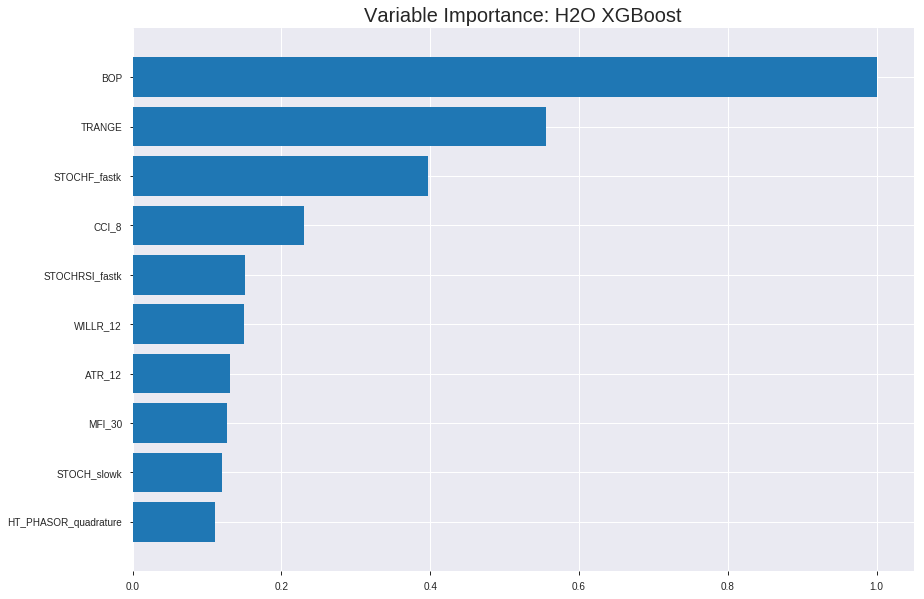

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_181218_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12824816116676857
RMSE: 0.3581175242385781
LogLoss: 0.4191088166260951
Mean Per-Class Error: 0.15013316575395752
AUC: 0.9319832221124976
pr_auc: 0.9255219622282911
Gini: 0.8639664442249952
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4905984103679657: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      724  122  0.1442   (122.0/846.0)
1      111  600  0.1561   (111.0/711.0)
Total  835  722  0.1496   (233.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490598     0.837404  196
max f2                       0.30815      0.890481  279
max f0point5                 0.595051     0.869103  145
max accuracy                 0.497012     0.850996  193
max precision                0.937982     1         0
max recall                   0.165993     1         347
max specificity              0.937982     1         0
max absolute_mcc             0.497012     0.699734  193
max min_per_class_accuracy   0.486714     0.848101  198
max mean_per_class_accuracy  0.497012     0.849867  193

Gains/Lift Table: Avg response rate: 45.66 %, avg score: 45.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.896385           2.18987   2.18987            1                0.910729   1                           0.910729            0.0225035       0.0225035                  118.987   118.987
    2        0.0205523                   0.873123           2.18987   2.18987            1                0.884966   1                           0.897847            0.0225035       0.045007                   118.987   118.987
    3        0.0301863                   0.860403           2.18987   2.18987            1                0.867208   1                           0.888069            0.021097        0.0661041                  118.987   118.987
    4        0.0404624                   0.839461           2.18987   2.18987            1                0.845678   1                           0.877303            0.0225035       0.0886076                  118.987   118.987
    5        0.0500963                   0.830492           2.18987   2.18987            1                0.836075   1                           0.869374            0.021097        0.109705                   118.987   118.987
    6        0.100193                    0.772179           2.18987   2.18987            1                0.801051   1                           0.835213            0.109705        0.219409                   118.987   118.987
    7        0.150289                    0.738291           2.13372   2.17116            0.974359         0.754871   0.991453                    0.808432            0.106892        0.326301                   113.372   117.116
    8        0.200385                    0.702991           2.13372   2.1618             0.974359         0.719524   0.987179                    0.786205            0.106892        0.433193                   113.372   116.18
    9        0.299936                    0.628212           1.90731   2.07733            0.870968         0.665028   0.948608                    0.745986            0.189873        0.623066                   90.7309   107.733
    10       0.400128                    0.547809           1.43184   1.9157             0.653846         0.586484   0.874799                    0.706046            0.14346         0.766526                   43.184    91.57
    11       0.500321                    0.466547           1.06686   1.74571            0.487179         0.504734   0.797176                    0.665732            0.106892        0.873418                   6.68614   74.5714
    12       0.599872                    0.377229           0.706411  1.57324            0.322581         0.418945   0.718415                    0.624777            0.0703235       0.943741                   -29.3589  57.3239
    13       0.700064                    0.287598           0.364979  1.40031            0.166667         0.333827   0.63945                     0.583137            0.0365682       0.980309                   -63.5021  40.0314
    14       0.799615                    0.207796           0.15541   1.24533            0.0709677        0.247605   0.568675                    0.541364            0.0154712       0.995781                   -84.459   24.5326
    15       0.899807                    0.129923           0.042113  1.11135            0.0192308        0.17081    0.507495                    0.500103            0.00421941      1                          -95.7887  11.1349
    16       1                           0.0486661          0         1                  0                0.0944561  0.456647                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19935836968143386
RMSE: 0.4464956547173039
LogLoss: 0.5821901744973218
Mean Per-Class Error: 0.29166666666666674
AUC: 0.7551942463732481
pr_auc: 0.6688174472461691
Gini: 0.5103884927464961
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4083573818206787: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      158  91   0.3655   (91.0/249.0)
1      44   152  0.2245   (44.0/196.0)
Total  202  243  0.3034   (135.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408357     0.692483  222
max f2                       0.152099     0.820578  354
max f0point5                 0.526981     0.669014  154
max accuracy                 0.526981     0.703371  154
max precision                0.816569     0.833333  17
max recall                   0.088944     1         388
max specificity              0.89354      0.995984  0
max absolute_mcc             0.42592      0.413936  211
max min_per_class_accuracy   0.45686      0.690763  195
max mean_per_class_accuracy  0.42592      0.708333  211

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 43.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.863571           1.81633   1.81633            0.8              0.87785   0.8                         0.87785             0.0204082       0.0204082                  81.6327   81.6327
    2        0.0202247                   0.849251           1.70281   1.76587            0.75             0.859209  0.777778                    0.869565            0.0153061       0.0357143                  70.2806   76.5873
    3        0.0314607                   0.827364           1.81633   1.78389            0.8              0.837723  0.785714                    0.858193            0.0204082       0.0561224                  81.6327   78.3892
    4        0.0404494                   0.81359            2.27041   1.89201            1                0.821573  0.833333                    0.850055            0.0204082       0.0765306                  127.041   89.2007
    5        0.0516854                   0.791334           1.81633   1.87555            0.8              0.799027  0.826087                    0.838962            0.0204082       0.0969388                  81.6327   87.5555
    6        0.101124                    0.723807           1.54801   1.71542            0.681818         0.752423  0.755556                    0.796654            0.0765306       0.173469                   54.8006   71.542
    7        0.150562                    0.685102           1.54801   1.66045            0.681818         0.704658  0.731343                    0.766446            0.0765306       0.25                       54.8006   66.0448
    8        0.2                         0.643577           1.54801   1.63265            0.681818         0.662659  0.719101                    0.740791            0.0765306       0.326531                   54.8006   63.2653
    9        0.301124                    0.574942           1.4127    1.55879            0.622222         0.608086  0.686567                    0.696226            0.142857        0.469388                   41.2698   55.8788
    10       0.4                         0.509898           1.39321   1.51786            0.613636         0.540765  0.668539                    0.657797            0.137755        0.607143                   39.3205   51.7857
    11       0.501124                    0.442948           1.16043   1.44573            0.511111         0.475092  0.636771                    0.620929            0.117347        0.72449                    16.0431   44.5731
    12       0.6                         0.35575            0.877203  1.35204            0.386364         0.400655  0.595506                    0.584629            0.0867347       0.811224                   -12.2797  35.2041
    13       0.698876                    0.279497           0.774003  1.27026            0.340909         0.321665  0.559486                    0.547425            0.0765306       0.887755                   -22.5997  27.0261
    14       0.8                         0.217364           0.554989  1.17985            0.244444         0.250673  0.519663                    0.509914            0.0561224       0.943878                   -44.5011  17.9847
    15       0.898876                    0.143626           0.412801  1.09547            0.181818         0.172888  0.4825                      0.472841            0.0408163       0.984694                   -58.7199  9.54719
    16       1                           0.0632949          0.151361  1                  0.0666667        0.105252  0.440449                    0.435669          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 18:12:22  1.463 sec   0                  0.5              0.693147            0.5             0                  1                0.543353                         0.5                0.693147              0.5               0                    1                  0.559551
    2019-08-25 18:12:22  1.521 sec   5                  0.471371         0.637138            0.838999        0.812995           2.18987          0.258189                         0.48195            0.657467              0.735636          0.64077              1.81633            0.310112
    2019-08-25 18:12:22  1.571 sec   10                 0.450517         0.597146            0.857233        0.834821           2.18987          0.240848                         0.469372           0.632628              0.750246          0.66525              1.81633            0.316854
    2019-08-25 18:12:23  1.619 sec   15                 0.432967         0.563449            0.868055        0.849239           2.18987          0.220295                         0.460529           0.614849              0.750625          0.672846             1.81633            0.319101
    2019-08-25 18:12:23  1.674 sec   20                 0.420463         0.53927             0.879227        0.862597           2.18987          0.211946                         0.456463           0.606103              0.75126           0.667091             1.81633            0.337079
    2019-08-25 18:12:23  1.726 sec   25                 0.411303         0.521126            0.885653        0.872219           2.18987          0.215157                         0.453812           0.600112              0.752397          0.66851              1.81633            0.332584
    2019-08-25 18:12:23  1.779 sec   30                 0.402036         0.502676            0.890083        0.876916           2.18987          0.199743                         0.450903           0.593703              0.754498          0.667083             1.36224            0.303371
    2019-08-25 18:12:23  1.835 sec   35                 0.393809         0.486223            0.895281        0.882049           2.18987          0.203597                         0.448587           0.58845               0.756424          0.674115             1.81633            0.298876
    2019-08-25 18:12:23  1.893 sec   40                 0.386924         0.472512            0.900723        0.888596           2.18987          0.18754                          0.446404           0.583363              0.759846          0.67298              1.81633            0.289888
    2019-08-25 18:12:23  1.955 sec   45                 0.380644         0.459991            0.9065          0.895659           2.18987          0.191394                         0.445267           0.580325              0.760266          0.673551             1.81633            0.303371
    2019-08-25 18:12:23  2.025 sec   50                 0.374447         0.448421            0.913334        0.902224           2.18987          0.179191                         0.445949           0.581693              0.757684          0.667535             1.36224            0.298876
    2019-08-25 18:12:23  2.097 sec   55                 0.369257         0.438712            0.919356        0.910381           2.18987          0.168272                         0.445747           0.580684              0.75669           0

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ---------------------
BOP                 1414.3720703125        1.0                   0.1815203368080663
TRANGE              786.0048217773438      0.5557270525030087    0.10087576174370008
STOCHF_fastk        562.1838989257812      0.3974794968919097    0.0721506121501202
CCI_8               325.4736328125         0.23011882067254613   0.04177124583435559
STOCHRSI_fastk      213.95286560058594     0.15127056740685912   0.02745868434484037
---                 ---                    ---                   ---
LINEARREG_ANGLE_12  36.053062438964844     0.025490507905037364  0.004627045580331059
ROCP_8              31.666505813598633     0.02238909158224684   0.004064075444836089
WILLR_24            28.215625762939453     0.019949224362656795  0.003621189925369143
CDLSHORTLINE        26.928001403808594     0.01903883848459971   0.0034559363741589145
ROCR100_14          9.298171997070312      0.006574063637311445  0.001193326245642435


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309417040358744)

('F1', 0.751937984496124)

('auc', 0.8001777634130575)

('logloss', 0.5451387662013176)

('mean_per_class_error', 0.2660391079508726)

('rmse', 0.42791068822960343)

('mse', 0.18310755710113288)

xgboost prediction progress: |████████████████████████████████████████████| 100%


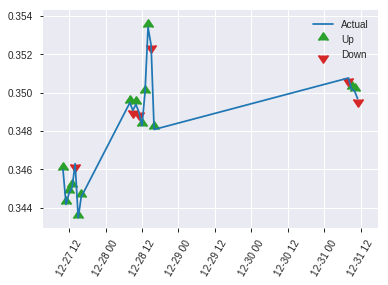


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18310755710113288
RMSE: 0.42791068822960343
LogLoss: 0.5451387662013176
Mean Per-Class Error: 0.2660391079508726
AUC: 0.8001777634130575
pr_auc: 0.7251552558555096
Gini: 0.6003555268261149
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37594708800315857: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   57   0.479    (57.0/119.0)
1      7    97   0.0673   (7.0/104.0)
Total  69   154  0.287    (64.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375947     0.751938  153
max f2                       0.293788     0.867347  171
max f0point5                 0.560187     0.714286  92
max accuracy                 0.516479     0.730942  117
max precision                0.904901     1         0
max recall                   0.172144     1         199
max specificity              0.904901     1         0
max absolute_mcc             0.375947     0.489638  153
max min_per_class_accuracy   0.538934     0.705882  108
max mean_per_class_accuracy  0.516479     0.733961  117

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 49.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.887561           1.42949   1.42949            0.666667         0.899448  0.666667                    0.899448            0.0192308       0.0192308                  42.9487   42.9487
    2        0.0224215                   0.862724           2.14423   1.71538            1                0.86557   0.8                         0.885897            0.0192308       0.0384615                  114.423   71.5385
    3        0.0313901                   0.852472           2.14423   1.83791            1                0.857767  0.857143                    0.87786             0.0192308       0.0576923                  114.423   83.7912
    4        0.0403587                   0.84657            1.07212   1.66774            0.5              0.850685  0.777778                    0.871821            0.00961538      0.0673077                  7.21154   66.7735
    5        0.0538117                   0.837662           2.14423   1.78686            1                0.842974  0.833333                    0.864609            0.0288462       0.0961538                  114.423   78.6859
    6        0.103139                    0.781952           1.55944   1.67809            0.727273         0.804626  0.782609                    0.835921            0.0769231       0.173077                   55.9441   67.8094
    7        0.152466                    0.73609            1.75437   1.70277            0.818182         0.758271  0.794118                    0.810799            0.0865385       0.259615                   75.4371   70.2771
    8        0.201794                    0.706882           1.75437   1.71538            0.818182         0.72095   0.8                         0.788836            0.0865385       0.346154                   75.4371   71.5385
    9        0.300448                    0.637942           1.16958   1.53617            0.545455         0.669817  0.716418                    0.749755            0.115385        0.461538                   16.958    53.6165
    10       0.399103                    0.565975           1.55944   1.54192            0.727273         0.598989  0.719101                    0.712487            0.153846        0.615385                   55.9441   54.1919
    11       0.502242                    0.530637           1.11873   1.45501            0.521739         0.548621  0.678571                    0.678836            0.115385        0.730769                   11.8729   45.5014
    12       0.600897                    0.434587           0.97465   1.37615            0.454545         0.486407  0.641791                    0.647243            0.0961538       0.826923                   -2.53497  37.6148
    13       0.699552                    0.364319           1.07212   1.33327            0.5              0.397726  0.621795                    0.612055            0.105769        0.932692                   7.21154   33.3272
    14       0.798206                    0.258539           0.487325  1.22872            0.227273         0.311711  0.573034                    0.574934            0.0480769       0.980769                   -51.2675  22.8717
    15       0.896861                    0.171123           0.19493   1.115              0.0909091        0.208861  0.52                        0.534666            0.0192308       1                          -80.507   11.5
    16       1                           0.0659567          0         1                  0                0.128886  0.466368                    0.492814            

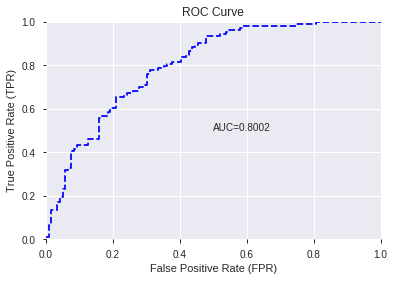

This function is available for GLM models only


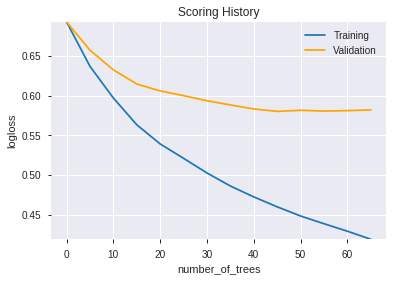

--2019-08-25 18:12:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

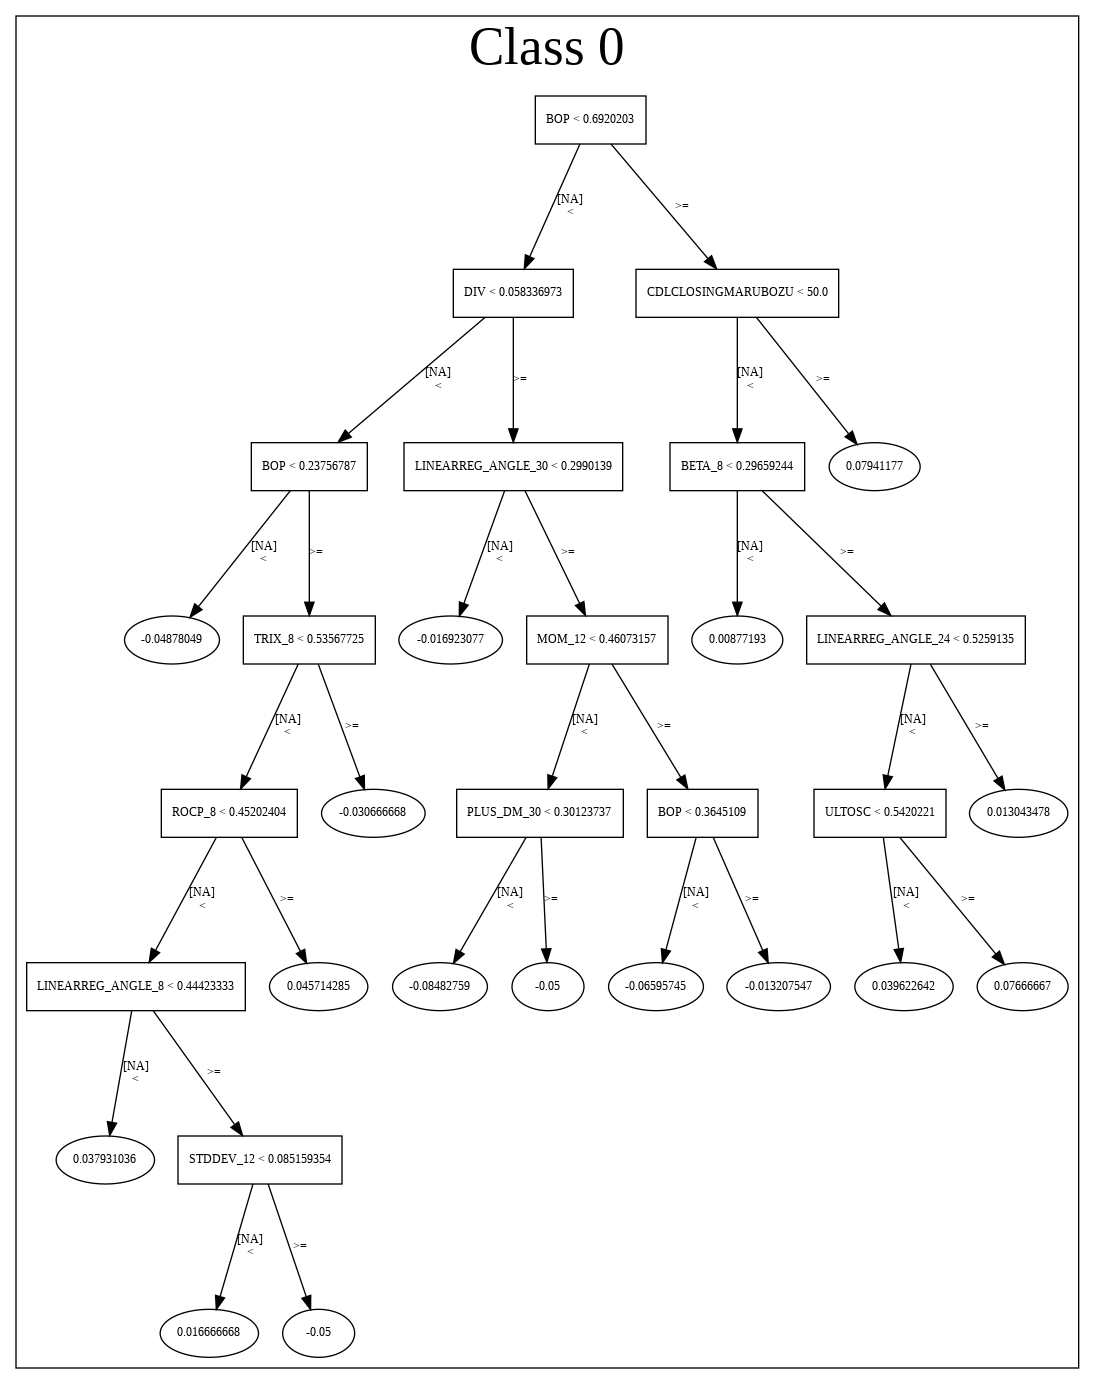

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_181218_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_181218_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a49b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'CCI_8',
 'STOCHRSI_fastk',
 'WILLR_12',
 'ATR_12',
 'MFI_30',
 'STOCH_slowk',
 'HT_PHASOR_quadrature',
 'CCI_14',
 'ROC_20',
 'BETA_14',
 'STDDEV_20',
 'ULTOSC',
 'MFI_8',
 'MFI_24',
 'ADOSC',
 'ROC_8',
 'MINUS_DM_24',
 'ROCR_14',
 'PLUS_DI_20',
 'MACDEXT_hist',
 'BETA_12',
 'BBANDS_lowerband_30_5_5',
 'DX_30',
 'STDDEV_12',
 'ROCR_20',
 'BBANDS_upperband_20_5_4',
 'BBANDS_upperband_20_0_5',
 'CORREL_14',
 'aroonup_14',
 'WILLR_14',
 'CDLBELTHOLD',
 'BBANDS_middleband_24_0_2',
 'aroondown_14',
 'WILLR_20',
 'AROONOSC_30',
 'WILLR_30',
 'LINEARREG_ANGLE_14',
 'AROONOSC_8',
 'ROCR100_12',
 'CMO_24',
 'BBANDS_upperband_20_3_3',
 'STOCHF_fastd',
 'aroonup_20',
 'aroonup_24',
 'LINEARREG_ANGLE_12',
 'ROCP_8',
 'WILLR_24',
 'CDLSHORTLINE',
 'ROCR100_14']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.722
GLM             0.713
XGBoost         0.749
dtype: float64

DeepLearning    GLM  XGBoost
All          0.722  0.695    0.726
DLF          0.722  0.709    0.749
Fwe          0.717  0.713    0.740
RFE          0.713  0.713    0.731
XGBF         0.704  0.709    0.749





F1


DeepLearning    0.730
GLM             0.731
XGBoost         0.752
dtype: float64

DeepLearning    GLM  XGBoost
All          0.721  0.731    0.735
DLF          0.723  0.723    0.750
Fwe          0.718  0.726    0.745
RFE          0.711  0.714    0.752
XGBF         0.730  0.723    0.750





auc


DeepLearning    0.772
GLM             0.758
XGBoost         0.800
dtype: float64

DeepLearning    GLM  XGBoost
All          0.762  0.746    0.791
DLF          0.768  0.750    0.786
Fwe          0.772  0.758    0.787
RFE          0.764  0.755    0.800
XGBF         0.768  0.750    0.786





logloss


DeepLearning    0.631
GLM             0.599
XGBoost         0.579
dtype: float64

DeepLearning    GLM  XGBoost
All          0.631  0.599    0.564
DLF          0.578  0.590    0.579
Fwe          0.578  0.579    0.555
RFE          0.586  0.586    0.545
XGBF         0.577  0.590    0.579





mean_per_class_error


DeepLearning    0.289
GLM             0.298
XGBoost         0.274
dtype: float64

DeepLearning    GLM  XGBoost
All          0.277  0.298    0.274
DLF          0.279  0.286    0.250
Fwe          0.289  0.280    0.259
RFE          0.288  0.288    0.266
XGBF         0.286  0.286    0.250





rmse


DeepLearning    0.456
GLM             0.453
XGBoost         0.442
dtype: float64

DeepLearning    GLM  XGBoost
All          0.456  0.453    0.437
DLF          0.446  0.450    0.442
Fwe          0.444  0.446    0.435
RFE          0.449  0.449    0.428
XGBF         0.444  0.450    0.442





mse


DeepLearning    0.208
GLM             0.206
XGBoost         0.195
dtype: float64

DeepLearning    GLM  XGBoost
All          0.208  0.206    0.191
DLF          0.199  0.203    0.195
Fwe          0.197  0.199    0.189
RFE          0.202  0.201    0.183
XGBF         0.197  0.203    0.195

{'F1':       DeepLearning    GLM  XGBoost
 All          0.721    NaN      NaN
 DLF          0.723    NaN      NaN
 DLF            NaN  0.723      NaN
 DLF            NaN    NaN    0.750
 All            NaN  0.731      NaN
 All            NaN    NaN    0.735
 XGBF         0.730    NaN      NaN
 XGBF           NaN  0.723      NaN
 XGBF           NaN    NaN    0.750
 Fwe          0.718    NaN      NaN
 Fwe            NaN  0.726      NaN
 Fwe            NaN    NaN    0.745
 RFE          0.711    NaN      NaN
 RFE            NaN  0.714      NaN
 RFE            NaN    NaN    0.752,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.722    NaN      NaN
 DLF          0.722    NaN      NaN
 DLF            NaN  0.709      NaN
 DLF            NaN    NaN    0.749
 All            NaN  0.695      NaN
 All            NaN    NaN    0.726
 XGBF         0.704    NaN      NaN
 XGBF           NaN  0.709      NaN
 XGBF           NaN    NaN    0.749
 Fwe          0.717    NaN      NaN
 Fwe     